# Install environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab/DASC7606_A2/maps_generation"

/content/drive/MyDrive/Colab/DASC7606_A2/maps_generation


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 676 kB 52.4 MB/s 
     |████████████████████████████████| 125 kB 65.3 MB/s 
     |████████████████████████████████| 1.8 MB 6.7 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 793 kB 4.4 MB/s 
     |████████████████████████████████| 381 kB 12.2 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 181 kB 64.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=553c50b01cdb313e439dc42a4e2aeb7dfcbab515cafd6927ab4b8a77de43151e
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=8030ff903ad60ddd211986dd3eaab854d8a97964431fe5d581cb83ad8b699069
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa

In [5]:
!pip install -r requirements_seg.txt

     |████████████████████████████████| 58 kB 2.7 MB/s 
     |████████████████████████████████| 376 kB 9.3 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=566c75741d8ae588bced5ba0c051876a08ffffc0daf55895431d211a3303e565
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=105b65ade1bd4ea513a34b3d58349b632143dae510f3ef57e78e22ff0bd25374
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch


# Datasets preparation

Download the provided dataset from this google link:

- `https://drive.google.com/file/d/15fziaX7zUI1iHDBfGWflB5RVibIhcXGz/view`

And unzip and move the dataset to the main directory.
- `tar -xvf maps.tar`
- `mv maps to maps_generation`


In [ ]:
%cd "/content/drive/MyDrive/Colab/"
!tar -xvf maps.tar
!mv maps to maps_generation/
!mv maps maps_generation/
%cd maps_generation/

/content/drive/MyDrive/Colab/DASC7606_A2


# Training

### import some necessary tools

In [2]:
import time
import os
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from tensorboardX import SummaryWriter
from util import util
import datetime
import ipdb

### initialize and modify the optional arguments

In [3]:
opt = TrainOptions().parse()

----------------- Options ---------------
               batch_size: 32                            
                    beta1: 0.5                           
          checkpoints_dir: ./train_output/ckpt/          
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

In [4]:
opt.num_threads = 2
opt.save_epoch_freq = 5 

# trial 32: resunet - add 2 dropout layers
opt.netG = 'res_unet_G'
opt.lr = 0.0002
opt.n_epochs = 200
opt.batch_size = 1
opt.load_width = 286
opt.load_height = 286
opt.ngf = 64
opt.ndf = 64
opt.gan_mode = 'lsgan'

### prepare datasets and models

In [5]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)
model = create_model(opt)
model.setup(opt)

dataset [MapDataset] was created
The number of training images = 1096
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 43.897 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------


### prepare some parameters for training

In [6]:
total_iters = 0
log_name = os.path.join(opt.checkpoints_dir, opt.name, 'loss_log.txt')
writer = SummaryWriter('./train_output/runs/' + opt.name)
step_per_batch = dataset_size / opt.batch_size
load_flag = False

### training loop

In [7]:
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)

        vis = model.optimize_parameters()

        if total_iters % opt.display_freq == 0:
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            writer.add_image('vis', util.tensor2im(vis).transpose((2,0,1)), total_iters)

        if total_iters % opt.print_freq == 0:
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            t_per_batch = (time.time() - iter_start_time)
            batch_left = (step_per_batch-total_iters % step_per_batch) + step_per_batch*(opt.n_epochs + opt.n_epochs_decay + 1 - epoch)
            eta = t_per_batch * batch_left
            eta = str(datetime.timedelta(seconds=int(eta)))
            util.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data, eta, log_name)
            writer.add_scalar('G_GAN', losses['G_GAN'], total_iters)
            writer.add_scalar('G_L1', losses['G_L1'], total_iters)
            writer.add_scalar('D_real', losses['D_real'], total_iters)
            writer.add_scalar('D_fake', losses['D_fake'], total_iters)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()

    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
        if epoch > 1:
            load_flag = False

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))
    model.update_learning_rate()                     # update learning rates at the end of every epoch.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 1, iters: 50, time: 0.069, data: 0.232 ETA:    4:38:22) G_GAN: 0.612 G_L1: 9.598 D_real: 0.495 D_fake: 0.622 
(epoch: 1, iters: 100, time: 0.070, data: 0.002 ETA:    4:43:00) G_GAN: 0.564 G_L1: 9.647 D_real: 0.527 D_fake: 0.548 
(epoch: 1, iters: 150, time: 0.072, data: 0.002 ETA:    4:49:47) G_GAN: 0.413 G_L1: 5.776 D_real: 0.389 D_fake: 0.477 
(epoch: 1, iters: 200, time: 0.052, data: 0.003 ETA:    3:31:15) G_GAN: 0.430 G_L1: 5.329 D_real: 0.392 D_fake: 0.243 
(epoch: 1, iters: 250, time: 0.052, data: 0.003 ETA:    3:30:45) G_GAN: 0.459 G_L1: 4.875 D_real: 0.363 D_fake: 0.434 
(epoch: 1, iters: 300, time: 0.052, data: 0.002 ETA:    3:29:07) G_GAN: 0.357 G_L1: 12.088 D_real: 0.357 D_fake: 0.315 
(epoch: 1, iters: 350, time: 0.054, data: 0.002 ETA:    3:36:05) G_GAN: 0.324 G_L1: 10.216 D_real: 0.275 D_fake: 0.266 
(epoch: 1, iters: 400, time: 0.129, data: 0.002 ETA:    8:41:39) G_GAN: 0.472 G_L1: 5.814 D_real: 0.394 D_fake: 0.199 
(epoch: 1, iters: 450, time: 0.069, data: 0.043

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 2, iters: 4, time: 0.052, data: 0.002 ETA:    3:29:23) G_GAN: 0.325 G_L1: 6.647 D_real: 0.167 D_fake: 0.193 
(epoch: 2, iters: 54, time: 0.055, data: 0.002 ETA:    3:39:55) G_GAN: 0.287 G_L1: 6.579 D_real: 0.059 D_fake: 0.286 
(epoch: 2, iters: 104, time: 0.129, data: 0.002 ETA:    8:37:26) G_GAN: 0.128 G_L1: 7.505 D_real: 0.150 D_fake: 0.400 
(epoch: 2, iters: 154, time: 0.052, data: 0.049 ETA:    3:27:01) G_GAN: 0.477 G_L1: 5.278 D_real: 0.214 D_fake: 0.107 
(epoch: 2, iters: 204, time: 0.066, data: 0.002 ETA:    4:24:16) G_GAN: 0.471 G_L1: 6.495 D_real: 0.172 D_fake: 0.056 
(epoch: 2, iters: 254, time: 0.068, data: 0.003 ETA:    4:33:26) G_GAN: 0.379 G_L1: 4.236 D_real: 0.312 D_fake: 0.103 
(epoch: 2, iters: 304, time: 0.068, data: 0.002 ETA:    4:33:54) G_GAN: 0.514 G_L1: 4.456 D_real: 1.060 D_fake: 0.062 
(epoch: 2, iters: 354, time: 0.052, data: 0.003 ETA:    3:29:22) G_GAN: 0.350 G_L1: 6.915 D_real: 0.478 D_fake: 0.088 
(epoch: 2, iters: 404, time: 0.053, data: 0.003 ETA

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 3, iters: 8, time: 0.066, data: 0.002 ETA:    4:24:33) G_GAN: 0.770 G_L1: 9.472 D_real: 0.192 D_fake: 0.053 
(epoch: 3, iters: 58, time: 0.067, data: 0.002 ETA:    4:26:13) G_GAN: 0.434 G_L1: 8.051 D_real: 0.552 D_fake: 0.022 
(epoch: 3, iters: 108, time: 0.052, data: 0.002 ETA:    3:28:28) G_GAN: 0.280 G_L1: 6.679 D_real: 0.237 D_fake: 0.087 
(epoch: 3, iters: 158, time: 0.052, data: 0.003 ETA:    3:29:41) G_GAN: 0.513 G_L1: 4.876 D_real: 0.316 D_fake: 0.112 
(epoch: 3, iters: 208, time: 0.142, data: 0.002 ETA:    9:26:46) G_GAN: 0.515 G_L1: 3.806 D_real: 0.197 D_fake: 0.153 
(epoch: 3, iters: 258, time: 0.069, data: 0.065 ETA:    4:34:38) G_GAN: 1.039 G_L1: 8.298 D_real: 0.050 D_fake: 0.110 
(epoch: 3, iters: 308, time: 0.066, data: 0.002 ETA:    4:24:09) G_GAN: 0.306 G_L1: 3.585 D_real: 0.290 D_fake: 0.249 
(epoch: 3, iters: 358, time: 0.068, data: 0.002 ETA:    4:31:49) G_GAN: 0.644 G_L1: 7.750 D_real: 0.098 D_fake: 0.142 
(epoch: 3, iters: 408, time: 0.054, data: 0.003 ETA

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 4, iters: 12, time: 0.054, data: 0.002 ETA:    3:36:08) G_GAN: 0.730 G_L1: 7.005 D_real: 0.086 D_fake: 0.053 
(epoch: 4, iters: 62, time: 0.054, data: 0.003 ETA:    3:35:10) G_GAN: 1.231 G_L1: 4.457 D_real: 0.066 D_fake: 0.045 
(epoch: 4, iters: 112, time: 0.054, data: 0.002 ETA:    3:33:22) G_GAN: 1.105 G_L1: 5.022 D_real: 0.064 D_fake: 0.060 
(epoch: 4, iters: 162, time: 0.054, data: 0.002 ETA:    3:36:10) G_GAN: 0.881 G_L1: 8.554 D_real: 0.124 D_fake: 0.018 
(epoch: 4, iters: 212, time: 0.053, data: 0.002 ETA:    3:30:43) G_GAN: 1.245 G_L1: 5.007 D_real: 0.087 D_fake: 0.015 
(epoch: 4, iters: 262, time: 0.054, data: 0.003 ETA:    3:35:12) G_GAN: 0.988 G_L1: 11.109 D_real: 0.017 D_fake: 0.024 
(epoch: 4, iters: 312, time: 0.127, data: 0.002 ETA:    8:24:42) G_GAN: 1.006 G_L1: 6.202 D_real: 0.158 D_fake: 0.014 
(epoch: 4, iters: 362, time: 0.052, data: 0.044 ETA:    3:26:51) G_GAN: 1.117 G_L1: 6.176 D_real: 0.023 D_fake: 0.045 
(epoch: 4, iters: 412, time: 0.054, data: 0.002 E

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 5, iters: 16, time: 0.127, data: 0.003 ETA:    8:23:02) G_GAN: 0.656 G_L1: 3.314 D_real: 0.025 D_fake: 0.029 
(epoch: 5, iters: 66, time: 0.053, data: 0.047 ETA:    3:30:30) G_GAN: 1.405 G_L1: 7.695 D_real: 0.078 D_fake: 0.063 
(epoch: 5, iters: 116, time: 0.067, data: 0.003 ETA:    4:24:49) G_GAN: 0.467 G_L1: 6.406 D_real: 0.118 D_fake: 0.881 
(epoch: 5, iters: 166, time: 0.053, data: 0.002 ETA:    3:29:51) G_GAN: 0.535 G_L1: 4.553 D_real: 0.093 D_fake: 0.029 
(epoch: 5, iters: 216, time: 0.067, data: 0.003 ETA:    4:24:48) G_GAN: 0.583 G_L1: 4.058 D_real: 0.094 D_fake: 0.141 
(epoch: 5, iters: 266, time: 0.072, data: 0.003 ETA:    4:43:26) G_GAN: 0.890 G_L1: 4.057 D_real: 0.514 D_fake: 0.039 
(epoch: 5, iters: 316, time: 0.067, data: 0.003 ETA:    4:25:34) G_GAN: 1.032 G_L1: 7.274 D_real: 0.109 D_fake: 0.026 
(epoch: 5, iters: 366, time: 0.052, data: 0.003 ETA:    3:24:33) G_GAN: 0.353 G_L1: 3.891 D_real: 0.145 D_fake: 0.069 
(epoch: 5, iters: 416, time: 0.141, data: 0.003 ET

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 6, iters: 20, time: 0.053, data: 0.009 ETA:    3:29:52) G_GAN: 0.671 G_L1: 4.646 D_real: 0.107 D_fake: 0.016 
(epoch: 6, iters: 70, time: 0.053, data: 0.003 ETA:    3:29:26) G_GAN: 0.184 G_L1: 3.015 D_real: 0.026 D_fake: 0.158 
(epoch: 6, iters: 120, time: 0.124, data: 0.002 ETA:    8:10:13) G_GAN: 0.278 G_L1: 5.287 D_real: 0.165 D_fake: 0.021 
(epoch: 6, iters: 170, time: 0.056, data: 0.089 ETA:    3:39:24) G_GAN: 0.713 G_L1: 3.038 D_real: 0.295 D_fake: 0.107 
(epoch: 6, iters: 220, time: 0.058, data: 0.002 ETA:    3:50:09) G_GAN: 0.202 G_L1: 4.253 D_real: 0.341 D_fake: 0.033 
(epoch: 6, iters: 270, time: 0.068, data: 0.004 ETA:    4:26:53) G_GAN: 0.726 G_L1: 3.861 D_real: 0.147 D_fake: 0.020 
(epoch: 6, iters: 320, time: 0.053, data: 0.002 ETA:    3:27:42) G_GAN: 0.358 G_L1: 3.905 D_real: 0.037 D_fake: 0.059 
(epoch: 6, iters: 370, time: 0.068, data: 0.002 ETA:    4:28:31) G_GAN: 1.035 G_L1: 7.871 D_real: 0.045 D_fake: 0.012 
(epoch: 6, iters: 420, time: 0.070, data: 0.002 ET

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 7, iters: 24, time: 0.054, data: 0.002 ETA:    3:33:06) G_GAN: 0.784 G_L1: 3.802 D_real: 0.096 D_fake: 0.012 
(epoch: 7, iters: 74, time: 0.053, data: 0.004 ETA:    3:26:48) G_GAN: 0.641 G_L1: 5.964 D_real: 0.020 D_fake: 0.009 
(epoch: 7, iters: 124, time: 0.055, data: 0.002 ETA:    3:34:35) G_GAN: 1.288 G_L1: 3.190 D_real: 0.100 D_fake: 0.057 
(epoch: 7, iters: 174, time: 0.054, data: 0.002 ETA:    3:30:59) G_GAN: 1.074 G_L1: 5.724 D_real: 0.012 D_fake: 0.024 
(epoch: 7, iters: 224, time: 0.129, data: 0.003 ETA:    8:27:35) G_GAN: 1.202 G_L1: 5.194 D_real: 0.012 D_fake: 0.020 
(epoch: 7, iters: 274, time: 0.052, data: 0.056 ETA:    3:25:53) G_GAN: 0.662 G_L1: 6.300 D_real: 0.029 D_fake: 0.059 
(epoch: 7, iters: 324, time: 0.051, data: 0.002 ETA:    3:20:57) G_GAN: 1.128 G_L1: 7.043 D_real: 0.041 D_fake: 0.006 
(epoch: 7, iters: 374, time: 0.051, data: 0.002 ETA:    3:19:33) G_GAN: 0.915 G_L1: 5.811 D_real: 0.037 D_fake: 0.008 
(epoch: 7, iters: 424, time: 0.051, data: 0.002 ET

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 8, iters: 28, time: 0.052, data: 0.002 ETA:    3:23:03) G_GAN: 1.066 G_L1: 4.326 D_real: 0.005 D_fake: 0.001 
(epoch: 8, iters: 78, time: 0.055, data: 0.003 ETA:    3:33:49) G_GAN: 0.950 G_L1: 4.277 D_real: 0.008 D_fake: 0.003 
(epoch: 8, iters: 128, time: 0.051, data: 0.002 ETA:    3:18:05) G_GAN: 1.016 G_L1: 4.984 D_real: 0.017 D_fake: 0.011 
(epoch: 8, iters: 178, time: 0.051, data: 0.003 ETA:    3:18:24) G_GAN: 0.997 G_L1: 1.816 D_real: 0.030 D_fake: 0.006 
(epoch: 8, iters: 228, time: 0.051, data: 0.002 ETA:    3:20:16) G_GAN: 1.011 G_L1: 5.499 D_real: 0.048 D_fake: 0.017 
(epoch: 8, iters: 278, time: 0.055, data: 0.002 ETA:    3:35:11) G_GAN: 1.029 G_L1: 3.992 D_real: 0.010 D_fake: 0.001 
(epoch: 8, iters: 328, time: 0.128, data: 0.003 ETA:    8:19:34) G_GAN: 0.962 G_L1: 4.468 D_real: 0.008 D_fake: 0.001 
saving the latest model (epoch 8, total_iters 8000)
(epoch: 8, iters: 378, time: 0.053, data: 0.002 ETA:    3:24:59) G_GAN: 1.008 G_L1: 6.482 D_real: 0.008 D_fake: 0.003

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 9, iters: 32, time: 0.120, data: 0.002 ETA:    7:47:46) G_GAN: 0.980 G_L1: 3.161 D_real: 0.010 D_fake: 0.004 
(epoch: 9, iters: 82, time: 0.057, data: 0.080 ETA:    3:41:34) G_GAN: 1.030 G_L1: 5.999 D_real: 0.005 D_fake: 0.002 
(epoch: 9, iters: 132, time: 0.051, data: 0.002 ETA:    3:18:56) G_GAN: 1.000 G_L1: 3.155 D_real: 0.006 D_fake: 0.001 
(epoch: 9, iters: 182, time: 0.054, data: 0.002 ETA:    3:29:56) G_GAN: 0.855 G_L1: 7.252 D_real: 0.027 D_fake: 0.002 
(epoch: 9, iters: 232, time: 0.053, data: 0.002 ETA:    3:24:27) G_GAN: 0.951 G_L1: 1.614 D_real: 0.014 D_fake: 0.004 
(epoch: 9, iters: 282, time: 0.054, data: 0.003 ETA:    3:29:27) G_GAN: 1.059 G_L1: 4.262 D_real: 0.010 D_fake: 0.007 
(epoch: 9, iters: 332, time: 0.051, data: 0.002 ETA:    3:18:49) G_GAN: 0.988 G_L1: 2.797 D_real: 0.004 D_fake: 0.002 
(epoch: 9, iters: 382, time: 0.053, data: 0.003 ETA:    3:26:34) G_GAN: 0.999 G_L1: 3.051 D_real: 0.014 D_fake: 0.004 
(epoch: 9, iters: 432, time: 0.129, data: 0.003 ET

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 10, iters: 36, time: 0.050, data: 0.002 ETA:    3:14:09) G_GAN: 1.081 G_L1: 1.801 D_real: 0.010 D_fake: 0.007 
(epoch: 10, iters: 86, time: 0.051, data: 0.003 ETA:    3:17:31) G_GAN: 1.019 G_L1: 3.000 D_real: 0.010 D_fake: 0.003 
(epoch: 10, iters: 136, time: 0.135, data: 0.003 ETA:    8:44:11) G_GAN: 0.930 G_L1: 4.412 D_real: 0.011 D_fake: 0.009 
saving the latest model (epoch 10, total_iters 10000)
(epoch: 10, iters: 186, time: 0.052, data: 0.003 ETA:    3:19:40) G_GAN: 0.974 G_L1: 5.823 D_real: 0.016 D_fake: 0.003 
(epoch: 10, iters: 236, time: 0.051, data: 0.002 ETA:    3:17:42) G_GAN: 1.015 G_L1: 4.234 D_real: 0.006 D_fake: 0.002 
(epoch: 10, iters: 286, time: 0.053, data: 0.002 ETA:    3:26:19) G_GAN: 1.009 G_L1: 7.996 D_real: 0.017 D_fake: 0.005 
(epoch: 10, iters: 336, time: 0.051, data: 0.002 ETA:    3:16:19) G_GAN: 1.217 G_L1: 4.482 D_real: 0.044 D_fake: 0.021 
(epoch: 10, iters: 386, time: 0.057, data: 0.003 ETA:    3:41:35) G_GAN: 0.986 G_L1: 3.156 D_real: 0.006 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 11, iters: 40, time: 0.055, data: 0.003 ETA:    3:31:54) G_GAN: 1.045 G_L1: 3.128 D_real: 0.013 D_fake: 0.008 
(epoch: 11, iters: 90, time: 0.052, data: 0.002 ETA:    3:22:10) G_GAN: 1.021 G_L1: 3.902 D_real: 0.004 D_fake: 0.001 
(epoch: 11, iters: 140, time: 0.065, data: 0.002 ETA:    4:09:31) G_GAN: 1.005 G_L1: 3.108 D_real: 0.031 D_fake: 0.002 
(epoch: 11, iters: 190, time: 0.052, data: 0.003 ETA:    3:19:04) G_GAN: 1.020 G_L1: 3.665 D_real: 0.004 D_fake: 0.001 
(epoch: 11, iters: 240, time: 0.117, data: 0.003 ETA:    7:31:57) G_GAN: 0.930 G_L1: 5.512 D_real: 0.009 D_fake: 0.005 
(epoch: 11, iters: 290, time: 0.051, data: 0.031 ETA:    3:15:07) G_GAN: 1.017 G_L1: 3.421 D_real: 0.012 D_fake: 0.007 
(epoch: 11, iters: 340, time: 0.054, data: 0.002 ETA:    3:29:30) G_GAN: 1.251 G_L1: 4.930 D_real: 0.012 D_fake: 0.116 
(epoch: 11, iters: 390, time: 0.055, data: 0.002 ETA:    3:32:33) G_GAN: 0.967 G_L1: 5.958 D_real: 0.009 D_fake: 0.001 
(epoch: 11, iters: 440, time: 0.059, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 12, iters: 44, time: 0.052, data: 0.002 ETA:    3:18:52) G_GAN: 1.050 G_L1: 3.596 D_real: 0.028 D_fake: 0.003 
(epoch: 12, iters: 94, time: 0.056, data: 0.002 ETA:    3:35:25) G_GAN: 0.957 G_L1: 4.899 D_real: 0.005 D_fake: 0.002 
(epoch: 12, iters: 144, time: 0.055, data: 0.002 ETA:    3:30:21) G_GAN: 1.023 G_L1: 3.841 D_real: 0.007 D_fake: 0.001 
(epoch: 12, iters: 194, time: 0.051, data: 0.002 ETA:    3:16:49) G_GAN: 0.967 G_L1: 8.407 D_real: 0.002 D_fake: 0.001 
(epoch: 12, iters: 244, time: 0.053, data: 0.002 ETA:    3:23:25) G_GAN: 0.983 G_L1: 3.081 D_real: 0.006 D_fake: 0.004 
(epoch: 12, iters: 294, time: 0.052, data: 0.003 ETA:    3:20:19) G_GAN: 1.020 G_L1: 3.909 D_real: 0.002 D_fake: 0.001 
(epoch: 12, iters: 344, time: 0.136, data: 0.003 ETA:    8:39:17) G_GAN: 1.004 G_L1: 2.454 D_real: 0.005 D_fake: 0.002 
(epoch: 12, iters: 394, time: 0.052, data: 0.048 ETA:    3:20:13) G_GAN: 0.974 G_L1: 4.152 D_real: 0.003 D_fake: 0.001 
(epoch: 12, iters: 444, time: 0.053, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 13, iters: 48, time: 0.125, data: 0.002 ETA:    7:58:36) G_GAN: 0.228 G_L1: 4.424 D_real: 0.455 D_fake: 0.052 
(epoch: 13, iters: 98, time: 0.053, data: 0.035 ETA:    3:23:52) G_GAN: 0.842 G_L1: 2.941 D_real: 0.040 D_fake: 0.081 
(epoch: 13, iters: 148, time: 0.068, data: 0.003 ETA:    4:19:47) G_GAN: 0.395 G_L1: 3.875 D_real: 0.237 D_fake: 0.119 
(epoch: 13, iters: 198, time: 0.067, data: 0.002 ETA:    4:16:28) G_GAN: 0.657 G_L1: 5.672 D_real: 0.017 D_fake: 0.064 
(epoch: 13, iters: 248, time: 0.053, data: 0.002 ETA:    3:23:41) G_GAN: 0.144 G_L1: 2.727 D_real: 0.118 D_fake: 0.358 
(epoch: 13, iters: 298, time: 0.067, data: 0.002 ETA:    4:14:42) G_GAN: 0.143 G_L1: 3.805 D_real: 0.189 D_fake: 0.398 
(epoch: 13, iters: 348, time: 0.052, data: 0.002 ETA:    3:17:00) G_GAN: 0.229 G_L1: 4.266 D_real: 0.311 D_fake: 0.102 
(epoch: 13, iters: 398, time: 0.052, data: 0.003 ETA:    3:16:41) G_GAN: 0.417 G_L1: 3.113 D_real: 0.023 D_fake: 0.337 
(epoch: 13, iters: 448, time: 0.131, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 14, iters: 2, time: 0.052, data: 0.003 ETA:    3:18:30) G_GAN: 0.604 G_L1: 6.397 D_real: 0.117 D_fake: 0.079 
(epoch: 14, iters: 52, time: 0.066, data: 0.002 ETA:    4:11:38) G_GAN: 0.984 G_L1: 5.127 D_real: 0.031 D_fake: 0.024 
(epoch: 14, iters: 102, time: 0.066, data: 0.002 ETA:    4:11:52) G_GAN: 0.421 G_L1: 2.777 D_real: 0.164 D_fake: 0.187 
(epoch: 14, iters: 152, time: 0.144, data: 0.003 ETA:    9:05:55) G_GAN: 0.508 G_L1: 4.138 D_real: 0.006 D_fake: 0.290 
(epoch: 14, iters: 202, time: 0.065, data: 0.076 ETA:    4:08:01) G_GAN: 0.523 G_L1: 2.896 D_real: 0.245 D_fake: 0.025 
(epoch: 14, iters: 252, time: 0.066, data: 0.002 ETA:    4:11:55) G_GAN: 0.672 G_L1: 5.117 D_real: 0.026 D_fake: 0.265 
(epoch: 14, iters: 302, time: 0.066, data: 0.003 ETA:    4:10:49) G_GAN: 0.656 G_L1: 5.842 D_real: 0.017 D_fake: 0.137 
(epoch: 14, iters: 352, time: 0.053, data: 0.002 ETA:    3:20:23) G_GAN: 0.502 G_L1: 4.125 D_real: 0.144 D_fake: 0.249 
(epoch: 14, iters: 402, time: 0.068, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 15, iters: 6, time: 0.052, data: 0.002 ETA:    3:16:08) G_GAN: 0.480 G_L1: 2.970 D_real: 0.669 D_fake: 0.091 
(epoch: 15, iters: 56, time: 0.069, data: 0.002 ETA:    4:20:32) G_GAN: 0.485 G_L1: 5.509 D_real: 0.198 D_fake: 0.203 
(epoch: 15, iters: 106, time: 0.052, data: 0.003 ETA:    3:15:29) G_GAN: 0.440 G_L1: 2.718 D_real: 0.017 D_fake: 0.057 
(epoch: 15, iters: 156, time: 0.053, data: 0.006 ETA:    3:19:06) G_GAN: 1.058 G_L1: 6.583 D_real: 0.012 D_fake: 0.526 
(epoch: 15, iters: 206, time: 0.067, data: 0.002 ETA:    4:13:00) G_GAN: 0.701 G_L1: 3.035 D_real: 0.086 D_fake: 0.488 
(epoch: 15, iters: 256, time: 0.143, data: 0.002 ETA:    9:01:09) G_GAN: 0.871 G_L1: 6.791 D_real: 0.015 D_fake: 0.016 
(epoch: 15, iters: 306, time: 0.054, data: 0.058 ETA:    3:23:33) G_GAN: 0.268 G_L1: 5.624 D_real: 0.271 D_fake: 0.064 
(epoch: 15, iters: 356, time: 0.068, data: 0.003 ETA:    4:17:05) G_GAN: 0.451 G_L1: 2.796 D_real: 0.157 D_fake: 0.273 
(epoch: 15, iters: 406, time: 0.055, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 16, iters: 10, time: 0.067, data: 0.033 ETA:    4:13:02) G_GAN: 0.495 G_L1: 2.312 D_real: 0.516 D_fake: 0.025 
(epoch: 16, iters: 60, time: 0.066, data: 0.003 ETA:    4:08:05) G_GAN: 0.350 G_L1: 4.235 D_real: 0.371 D_fake: 0.099 
(epoch: 16, iters: 110, time: 0.055, data: 0.002 ETA:    3:25:10) G_GAN: 1.248 G_L1: 2.996 D_real: 0.072 D_fake: 0.088 
(epoch: 16, iters: 160, time: 0.057, data: 0.005 ETA:    3:33:06) G_GAN: 0.087 G_L1: 3.593 D_real: 0.295 D_fake: 0.044 
(epoch: 16, iters: 210, time: 0.061, data: 0.002 ETA:    3:50:19) G_GAN: 0.522 G_L1: 3.023 D_real: 0.208 D_fake: 0.474 
(epoch: 16, iters: 260, time: 0.053, data: 0.002 ETA:    3:17:44) G_GAN: 0.572 G_L1: 2.352 D_real: 0.026 D_fake: 0.266 
(epoch: 16, iters: 310, time: 0.052, data: 0.003 ETA:    3:13:47) G_GAN: 0.134 G_L1: 6.324 D_real: 0.466 D_fake: 0.075 
(epoch: 16, iters: 360, time: 0.142, data: 0.002 ETA:    8:52:59) G_GAN: 0.191 G_L1: 3.197 D_real: 0.308 D_fake: 0.326 
(epoch: 16, iters: 410, time: 0.073, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 17, iters: 14, time: 0.066, data: 0.002 ETA:    4:07:10) G_GAN: 0.526 G_L1: 4.395 D_real: 0.360 D_fake: 0.197 
(epoch: 17, iters: 64, time: 0.122, data: 0.003 ETA:    7:36:56) G_GAN: 0.236 G_L1: 3.605 D_real: 0.721 D_fake: 0.015 
(epoch: 17, iters: 114, time: 0.052, data: 0.057 ETA:    3:13:34) G_GAN: 0.586 G_L1: 4.467 D_real: 0.108 D_fake: 0.006 
(epoch: 17, iters: 164, time: 0.052, data: 0.002 ETA:    3:14:19) G_GAN: 1.015 G_L1: 2.918 D_real: 0.115 D_fake: 0.115 
(epoch: 17, iters: 214, time: 0.051, data: 0.002 ETA:    3:12:33) G_GAN: 0.552 G_L1: 2.522 D_real: 0.291 D_fake: 0.136 
(epoch: 17, iters: 264, time: 0.066, data: 0.002 ETA:    4:06:52) G_GAN: 0.443 G_L1: 3.443 D_real: 0.231 D_fake: 0.128 
(epoch: 17, iters: 314, time: 0.068, data: 0.005 ETA:    4:15:54) G_GAN: 0.417 G_L1: 5.434 D_real: 0.779 D_fake: 0.053 
(epoch: 17, iters: 364, time: 0.055, data: 0.002 ETA:    3:25:47) G_GAN: 0.235 G_L1: 2.912 D_real: 0.194 D_fake: 0.259 
(epoch: 17, iters: 414, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 18, iters: 18, time: 0.066, data: 0.003 ETA:    4:04:50) G_GAN: 0.499 G_L1: 2.577 D_real: 0.344 D_fake: 0.152 
(epoch: 18, iters: 68, time: 0.067, data: 0.002 ETA:    4:10:19) G_GAN: 0.462 G_L1: 2.466 D_real: 0.876 D_fake: 0.016 
(epoch: 18, iters: 118, time: 0.051, data: 0.003 ETA:    3:10:02) G_GAN: 0.390 G_L1: 3.269 D_real: 0.311 D_fake: 0.026 
(epoch: 18, iters: 168, time: 0.136, data: 0.002 ETA:    8:25:23) G_GAN: 0.502 G_L1: 5.400 D_real: 0.147 D_fake: 0.129 
(epoch: 18, iters: 218, time: 0.067, data: 0.045 ETA:    4:07:38) G_GAN: 1.277 G_L1: 1.094 D_real: 0.132 D_fake: 0.073 
(epoch: 18, iters: 268, time: 0.054, data: 0.002 ETA:    3:19:53) G_GAN: 0.794 G_L1: 3.569 D_real: 0.015 D_fake: 0.182 
(epoch: 18, iters: 318, time: 0.056, data: 0.002 ETA:    3:27:36) G_GAN: 0.254 G_L1: 3.663 D_real: 0.588 D_fake: 0.059 
(epoch: 18, iters: 368, time: 0.052, data: 0.003 ETA:    3:12:54) G_GAN: 0.282 G_L1: 3.542 D_real: 0.089 D_fake: 0.144 
(epoch: 18, iters: 418, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 19, iters: 22, time: 0.069, data: 0.003 ETA:    4:16:21) G_GAN: 0.360 G_L1: 2.849 D_real: 0.116 D_fake: 0.174 
(epoch: 19, iters: 72, time: 0.067, data: 0.003 ETA:    4:07:11) G_GAN: 0.655 G_L1: 6.043 D_real: 0.109 D_fake: 0.113 
(epoch: 19, iters: 122, time: 0.067, data: 0.002 ETA:    4:08:28) G_GAN: 0.765 G_L1: 3.024 D_real: 0.202 D_fake: 0.021 
(epoch: 19, iters: 172, time: 0.051, data: 0.002 ETA:    3:10:47) G_GAN: 0.044 G_L1: 1.009 D_real: 0.073 D_fake: 0.122 
(epoch: 19, iters: 222, time: 0.066, data: 0.002 ETA:    4:05:00) G_GAN: 1.035 G_L1: 1.045 D_real: 0.009 D_fake: 0.017 
(epoch: 19, iters: 272, time: 0.135, data: 0.002 ETA:    8:20:44) G_GAN: 0.528 G_L1: 6.502 D_real: 0.024 D_fake: 0.475 
saving the latest model (epoch 19, total_iters 20000)
(epoch: 19, iters: 322, time: 0.054, data: 0.002 ETA:    3:18:57) G_GAN: 0.568 G_L1: 2.806 D_real: 0.118 D_fake: 0.187 
(epoch: 19, iters: 372, time: 0.052, data: 0.003 ETA:    3:12:29) G_GAN: 0.632 G_L1: 10.210 D_real: 0.335 D_

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 20, iters: 26, time: 0.052, data: 0.027 ETA:    3:11:47) G_GAN: 0.366 G_L1: 4.396 D_real: 0.209 D_fake: 0.234 
(epoch: 20, iters: 76, time: 0.052, data: 0.003 ETA:    3:12:22) G_GAN: 0.257 G_L1: 2.788 D_real: 0.040 D_fake: 0.269 
(epoch: 20, iters: 126, time: 0.069, data: 0.002 ETA:    4:13:27) G_GAN: 0.553 G_L1: 3.659 D_real: 0.253 D_fake: 0.024 
(epoch: 20, iters: 176, time: 0.052, data: 0.002 ETA:    3:10:02) G_GAN: 0.837 G_L1: 8.769 D_real: 0.061 D_fake: 0.291 
(epoch: 20, iters: 226, time: 0.053, data: 0.003 ETA:    3:15:03) G_GAN: 1.251 G_L1: 7.682 D_real: 0.028 D_fake: 0.140 
(epoch: 20, iters: 276, time: 0.054, data: 0.003 ETA:    3:19:00) G_GAN: 1.234 G_L1: 1.252 D_real: 0.066 D_fake: 0.219 
(epoch: 20, iters: 326, time: 0.069, data: 0.002 ETA:    4:12:46) G_GAN: 0.540 G_L1: 4.933 D_real: 0.112 D_fake: 0.359 
(epoch: 20, iters: 376, time: 0.128, data: 0.002 ETA:    7:51:07) G_GAN: 0.319 G_L1: 2.897 D_real: 0.120 D_fake: 0.219 
(epoch: 20, iters: 426, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 21, iters: 30, time: 0.052, data: 0.003 ETA:    3:11:56) G_GAN: 1.423 G_L1: 1.644 D_real: 0.421 D_fake: 0.027 
(epoch: 21, iters: 80, time: 0.137, data: 0.003 ETA:    8:22:31) G_GAN: 0.279 G_L1: 2.538 D_real: 0.067 D_fake: 0.325 
saving the latest model (epoch 21, total_iters 22000)
(epoch: 21, iters: 130, time: 0.068, data: 0.003 ETA:    4:08:18) G_GAN: 0.717 G_L1: 4.612 D_real: 0.103 D_fake: 0.125 
(epoch: 21, iters: 180, time: 0.069, data: 0.002 ETA:    4:12:31) G_GAN: 0.441 G_L1: 3.538 D_real: 0.161 D_fake: 0.126 
(epoch: 21, iters: 230, time: 0.058, data: 0.002 ETA:    3:33:14) G_GAN: 0.511 G_L1: 4.268 D_real: 0.169 D_fake: 0.047 
(epoch: 21, iters: 280, time: 0.068, data: 0.003 ETA:    4:09:25) G_GAN: 0.564 G_L1: 3.575 D_real: 0.244 D_fake: 0.145 
(epoch: 21, iters: 330, time: 0.072, data: 0.002 ETA:    4:25:04) G_GAN: 0.857 G_L1: 4.511 D_real: 0.082 D_fake: 0.259 
(epoch: 21, iters: 380, time: 0.051, data: 0.003 ETA:    3:08:33) G_GAN: 0.524 G_L1: 5.473 D_real: 0.004 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 22, iters: 34, time: 0.067, data: 0.003 ETA:    4:05:43) G_GAN: 0.694 G_L1: 1.572 D_real: 0.359 D_fake: 0.012 
(epoch: 22, iters: 84, time: 0.065, data: 0.003 ETA:    3:58:53) G_GAN: 0.424 G_L1: 3.200 D_real: 0.341 D_fake: 0.114 
(epoch: 22, iters: 134, time: 0.067, data: 0.002 ETA:    4:06:08) G_GAN: 0.439 G_L1: 2.894 D_real: 0.110 D_fake: 0.085 
(epoch: 22, iters: 184, time: 0.123, data: 0.003 ETA:    7:30:41) G_GAN: 0.153 G_L1: 3.146 D_real: 0.100 D_fake: 0.167 
(epoch: 22, iters: 234, time: 0.051, data: 0.076 ETA:    3:05:15) G_GAN: 0.158 G_L1: 2.777 D_real: 0.319 D_fake: 0.228 
(epoch: 22, iters: 284, time: 0.054, data: 0.002 ETA:    3:16:04) G_GAN: 0.258 G_L1: 2.225 D_real: 0.034 D_fake: 0.080 
(epoch: 22, iters: 334, time: 0.054, data: 0.002 ETA:    3:15:17) G_GAN: 0.274 G_L1: 2.655 D_real: 0.057 D_fake: 0.260 
(epoch: 22, iters: 384, time: 0.051, data: 0.002 ETA:    3:05:25) G_GAN: 0.295 G_L1: 4.854 D_real: 0.167 D_fake: 0.088 
(epoch: 22, iters: 434, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 23, iters: 38, time: 0.052, data: 0.002 ETA:    3:10:45) G_GAN: 0.281 G_L1: 4.128 D_real: 0.100 D_fake: 0.149 
(epoch: 23, iters: 88, time: 0.072, data: 0.003 ETA:    4:23:05) G_GAN: 0.348 G_L1: 2.939 D_real: 0.267 D_fake: 0.120 
(epoch: 23, iters: 138, time: 0.067, data: 0.002 ETA:    4:04:48) G_GAN: 0.519 G_L1: 4.173 D_real: 0.093 D_fake: 0.223 
(epoch: 23, iters: 188, time: 0.068, data: 0.002 ETA:    4:05:54) G_GAN: 0.450 G_L1: 3.351 D_real: 0.366 D_fake: 0.050 
(epoch: 23, iters: 238, time: 0.069, data: 0.003 ETA:    4:09:02) G_GAN: 0.453 G_L1: 2.618 D_real: 0.183 D_fake: 0.109 
(epoch: 23, iters: 288, time: 0.132, data: 0.002 ETA:    7:57:59) G_GAN: 0.407 G_L1: 2.783 D_real: 0.042 D_fake: 0.170 
(epoch: 23, iters: 338, time: 0.052, data: 0.056 ETA:    3:10:28) G_GAN: 0.721 G_L1: 1.971 D_real: 0.039 D_fake: 0.089 
(epoch: 23, iters: 388, time: 0.067, data: 0.002 ETA:    4:01:54) G_GAN: 0.511 G_L1: 3.702 D_real: 0.066 D_fake: 0.238 
(epoch: 23, iters: 438, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 24, iters: 42, time: 0.054, data: 0.044 ETA:    3:14:24) G_GAN: 0.194 G_L1: 2.590 D_real: 0.300 D_fake: 0.083 
(epoch: 24, iters: 92, time: 0.055, data: 0.003 ETA:    3:17:50) G_GAN: 0.459 G_L1: 2.400 D_real: 0.055 D_fake: 0.256 
(epoch: 24, iters: 142, time: 0.087, data: 0.002 ETA:    5:14:55) G_GAN: 0.580 G_L1: 2.858 D_real: 0.104 D_fake: 0.346 
(epoch: 24, iters: 192, time: 0.066, data: 0.002 ETA:    3:59:56) G_GAN: 0.382 G_L1: 3.080 D_real: 0.367 D_fake: 0.170 
(epoch: 24, iters: 242, time: 0.066, data: 0.002 ETA:    3:57:10) G_GAN: 0.347 G_L1: 3.178 D_real: 0.067 D_fake: 0.436 
(epoch: 24, iters: 292, time: 0.068, data: 0.003 ETA:    4:05:27) G_GAN: 0.509 G_L1: 5.089 D_real: 0.125 D_fake: 0.071 
(epoch: 24, iters: 342, time: 0.069, data: 0.002 ETA:    4:10:18) G_GAN: 0.652 G_L1: 2.440 D_real: 0.136 D_fake: 0.173 
(epoch: 24, iters: 392, time: 0.129, data: 0.002 ETA:    7:46:57) G_GAN: 0.300 G_L1: 3.172 D_real: 0.455 D_fake: 0.051 
(epoch: 24, iters: 442, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 25, iters: 46, time: 0.066, data: 0.002 ETA:    3:57:26) G_GAN: 0.388 G_L1: 2.101 D_real: 0.193 D_fake: 0.198 
(epoch: 25, iters: 96, time: 0.151, data: 0.002 ETA:    9:01:53) G_GAN: 0.326 G_L1: 3.070 D_real: 0.093 D_fake: 0.264 
(epoch: 25, iters: 146, time: 0.067, data: 0.065 ETA:    3:59:38) G_GAN: 0.491 G_L1: 3.568 D_real: 0.019 D_fake: 0.302 
(epoch: 25, iters: 196, time: 0.066, data: 0.003 ETA:    3:56:40) G_GAN: 0.639 G_L1: 4.163 D_real: 0.053 D_fake: 0.107 
(epoch: 25, iters: 246, time: 0.069, data: 0.002 ETA:    4:07:38) G_GAN: 0.515 G_L1: 4.412 D_real: 0.078 D_fake: 0.099 
(epoch: 25, iters: 296, time: 0.067, data: 0.002 ETA:    4:00:47) G_GAN: 0.355 G_L1: 3.307 D_real: 0.344 D_fake: 0.100 
(epoch: 25, iters: 346, time: 0.070, data: 0.003 ETA:    4:10:20) G_GAN: 0.589 G_L1: 5.107 D_real: 0.018 D_fake: 0.299 
(epoch: 25, iters: 396, time: 0.055, data: 0.002 ETA:    3:16:04) G_GAN: 0.229 G_L1: 2.727 D_real: 0.219 D_fake: 0.118 
(epoch: 25, iters: 446, time: 0.058, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 26, iters: 50, time: 0.054, data: 0.163 ETA:    3:14:48) G_GAN: 0.202 G_L1: 5.708 D_real: 0.503 D_fake: 0.034 
(epoch: 26, iters: 100, time: 0.061, data: 0.003 ETA:    3:37:56) G_GAN: 0.158 G_L1: 4.803 D_real: 0.109 D_fake: 0.101 
(epoch: 26, iters: 150, time: 0.066, data: 0.003 ETA:    3:57:40) G_GAN: 0.408 G_L1: 2.554 D_real: 0.204 D_fake: 0.271 
(epoch: 26, iters: 200, time: 0.165, data: 0.002 ETA:    9:48:32) G_GAN: 0.287 G_L1: 2.627 D_real: 0.062 D_fake: 0.122 
(epoch: 26, iters: 250, time: 0.054, data: 0.095 ETA:    3:11:25) G_GAN: 0.898 G_L1: 3.099 D_real: 0.418 D_fake: 0.282 
(epoch: 26, iters: 300, time: 0.069, data: 0.002 ETA:    4:05:37) G_GAN: 0.540 G_L1: 3.353 D_real: 0.082 D_fake: 0.166 
(epoch: 26, iters: 350, time: 0.068, data: 0.002 ETA:    4:02:51) G_GAN: 0.711 G_L1: 4.171 D_real: 0.196 D_fake: 0.307 
(epoch: 26, iters: 400, time: 0.065, data: 0.002 ETA:    3:52:07) G_GAN: 0.476 G_L1: 3.620 D_real: 0.113 D_fake: 0.139 
(epoch: 26, iters: 450, time: 0.067, data

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 27, iters: 4, time: 0.067, data: 0.003 ETA:    3:58:27) G_GAN: 0.433 G_L1: 3.629 D_real: 0.125 D_fake: 0.204 
(epoch: 27, iters: 54, time: 0.067, data: 0.003 ETA:    3:58:04) G_GAN: 0.513 G_L1: 3.045 D_real: 0.030 D_fake: 0.273 
(epoch: 27, iters: 104, time: 0.070, data: 0.003 ETA:    4:09:25) G_GAN: 0.373 G_L1: 3.697 D_real: 0.448 D_fake: 0.195 
(epoch: 27, iters: 154, time: 0.070, data: 0.003 ETA:    4:07:49) G_GAN: 0.340 G_L1: 3.516 D_real: 0.172 D_fake: 0.239 
(epoch: 27, iters: 204, time: 0.068, data: 0.003 ETA:    4:02:11) G_GAN: 0.829 G_L1: 3.675 D_real: 0.060 D_fake: 0.043 
(epoch: 27, iters: 254, time: 0.071, data: 0.002 ETA:    4:12:02) G_GAN: 0.393 G_L1: 2.483 D_real: 0.183 D_fake: 0.257 
(epoch: 27, iters: 304, time: 0.141, data: 0.002 ETA:    8:20:34) G_GAN: 0.368 G_L1: 2.931 D_real: 0.057 D_fake: 0.503 
(epoch: 27, iters: 354, time: 0.069, data: 0.058 ETA:    4:05:54) G_GAN: 0.613 G_L1: 3.577 D_real: 0.064 D_fake: 0.101 
(epoch: 27, iters: 404, time: 0.051, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 28, iters: 8, time: 0.144, data: 0.002 ETA:    8:32:01) G_GAN: 0.548 G_L1: 3.096 D_real: 0.138 D_fake: 0.233 
(epoch: 28, iters: 58, time: 0.053, data: 0.039 ETA:    3:09:21) G_GAN: 0.672 G_L1: 3.569 D_real: 0.020 D_fake: 0.706 
(epoch: 28, iters: 108, time: 0.051, data: 0.002 ETA:    3:01:43) G_GAN: 0.280 G_L1: 2.875 D_real: 0.240 D_fake: 0.039 
(epoch: 28, iters: 158, time: 0.052, data: 0.002 ETA:    3:03:11) G_GAN: 0.227 G_L1: 3.893 D_real: 0.354 D_fake: 0.033 
(epoch: 28, iters: 208, time: 0.066, data: 0.002 ETA:    3:53:06) G_GAN: 0.524 G_L1: 2.230 D_real: 0.241 D_fake: 0.323 
(epoch: 28, iters: 258, time: 0.051, data: 0.002 ETA:    3:01:25) G_GAN: 0.595 G_L1: 5.504 D_real: 0.112 D_fake: 0.116 
(epoch: 28, iters: 308, time: 0.053, data: 0.002 ETA:    3:07:16) G_GAN: 0.670 G_L1: 4.726 D_real: 0.106 D_fake: 0.064 
(epoch: 28, iters: 358, time: 0.052, data: 0.003 ETA:    3:04:30) G_GAN: 0.646 G_L1: 2.583 D_real: 0.009 D_fake: 0.070 
(epoch: 28, iters: 408, time: 0.144, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 29, iters: 12, time: 0.053, data: 0.003 ETA:    3:06:23) G_GAN: 0.572 G_L1: 2.341 D_real: 0.066 D_fake: 0.097 
(epoch: 29, iters: 62, time: 0.051, data: 0.003 ETA:    3:01:21) G_GAN: 0.622 G_L1: 3.481 D_real: 0.149 D_fake: 0.148 
(epoch: 29, iters: 112, time: 0.158, data: 0.003 ETA:    9:17:08) G_GAN: 0.373 G_L1: 4.004 D_real: 0.141 D_fake: 0.211 
(epoch: 29, iters: 162, time: 0.053, data: 0.085 ETA:    3:05:48) G_GAN: 0.177 G_L1: 4.265 D_real: 0.174 D_fake: 0.082 
(epoch: 29, iters: 212, time: 0.051, data: 0.002 ETA:    3:00:59) G_GAN: 0.505 G_L1: 1.544 D_real: 0.090 D_fake: 0.232 
(epoch: 29, iters: 262, time: 0.051, data: 0.002 ETA:    2:59:59) G_GAN: 0.183 G_L1: 3.119 D_real: 0.447 D_fake: 0.029 
(epoch: 29, iters: 312, time: 0.051, data: 0.002 ETA:    2:58:47) G_GAN: 0.598 G_L1: 1.042 D_real: 0.129 D_fake: 0.135 
(epoch: 29, iters: 362, time: 0.052, data: 0.002 ETA:    3:04:23) G_GAN: 0.258 G_L1: 3.086 D_real: 0.215 D_fake: 0.083 
(epoch: 29, iters: 412, time: 0.056, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 30, iters: 16, time: 0.066, data: 0.002 ETA:    3:51:26) G_GAN: 0.637 G_L1: 3.617 D_real: 0.105 D_fake: 0.074 
(epoch: 30, iters: 66, time: 0.066, data: 0.003 ETA:    3:52:03) G_GAN: 0.419 G_L1: 3.623 D_real: 0.430 D_fake: 0.112 
(epoch: 30, iters: 116, time: 0.066, data: 0.002 ETA:    3:51:36) G_GAN: 0.362 G_L1: 2.353 D_real: 0.229 D_fake: 0.259 
(epoch: 30, iters: 166, time: 0.054, data: 0.003 ETA:    3:09:12) G_GAN: 0.482 G_L1: 3.592 D_real: 0.416 D_fake: 0.105 
(epoch: 30, iters: 216, time: 0.145, data: 0.002 ETA:    8:28:11) G_GAN: 0.631 G_L1: 3.869 D_real: 0.234 D_fake: 0.040 
saving the latest model (epoch 30, total_iters 32000)
(epoch: 30, iters: 266, time: 0.068, data: 0.002 ETA:    3:58:57) G_GAN: 0.726 G_L1: 4.521 D_real: 0.056 D_fake: 0.183 
(epoch: 30, iters: 316, time: 0.069, data: 0.002 ETA:    4:00:07) G_GAN: 0.447 G_L1: 3.522 D_real: 0.385 D_fake: 0.096 
(epoch: 30, iters: 366, time: 0.053, data: 0.003 ETA:    3:04:44) G_GAN: 0.581 G_L1: 2.641 D_real: 0.261 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 31, iters: 20, time: 0.052, data: 0.002 ETA:    3:02:38) G_GAN: 0.831 G_L1: 7.180 D_real: 0.269 D_fake: 0.102 
(epoch: 31, iters: 70, time: 0.052, data: 0.003 ETA:    2:59:55) G_GAN: 0.729 G_L1: 4.012 D_real: 0.508 D_fake: 0.132 
(epoch: 31, iters: 120, time: 0.053, data: 0.003 ETA:    3:05:57) G_GAN: 0.509 G_L1: 5.124 D_real: 0.135 D_fake: 0.164 
(epoch: 31, iters: 170, time: 0.069, data: 0.002 ETA:    4:01:13) G_GAN: 0.354 G_L1: 3.230 D_real: 0.142 D_fake: 0.260 
(epoch: 31, iters: 220, time: 0.069, data: 0.002 ETA:    4:00:19) G_GAN: 0.608 G_L1: 4.718 D_real: 0.373 D_fake: 0.149 
(epoch: 31, iters: 270, time: 0.083, data: 0.002 ETA:    4:49:11) G_GAN: 0.220 G_L1: 2.851 D_real: 0.517 D_fake: 0.184 
(epoch: 31, iters: 320, time: 0.139, data: 0.002 ETA:    8:02:55) G_GAN: 0.374 G_L1: 3.038 D_real: 0.288 D_fake: 0.176 
(epoch: 31, iters: 370, time: 0.051, data: 0.067 ETA:    2:59:14) G_GAN: 0.681 G_L1: 3.144 D_real: 0.175 D_fake: 0.093 
(epoch: 31, iters: 420, time: 0.051, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 32, iters: 24, time: 0.140, data: 0.003 ETA:    8:07:04) G_GAN: 0.592 G_L1: 3.029 D_real: 0.078 D_fake: 0.147 
saving the latest model (epoch 32, total_iters 34000)
(epoch: 32, iters: 74, time: 0.067, data: 0.002 ETA:    3:50:47) G_GAN: 0.980 G_L1: 3.447 D_real: 0.033 D_fake: 0.053 
(epoch: 32, iters: 124, time: 0.066, data: 0.003 ETA:    3:50:29) G_GAN: 1.030 G_L1: 1.281 D_real: 0.008 D_fake: 0.060 
(epoch: 32, iters: 174, time: 0.073, data: 0.002 ETA:    4:12:10) G_GAN: 0.553 G_L1: 7.347 D_real: 0.230 D_fake: 0.245 
(epoch: 32, iters: 224, time: 0.069, data: 0.003 ETA:    3:58:41) G_GAN: 0.684 G_L1: 3.647 D_real: 0.118 D_fake: 0.056 
(epoch: 32, iters: 274, time: 0.069, data: 0.002 ETA:    3:57:42) G_GAN: 0.724 G_L1: 3.835 D_real: 0.090 D_fake: 0.054 
(epoch: 32, iters: 324, time: 0.068, data: 0.003 ETA:    3:54:08) G_GAN: 0.445 G_L1: 2.771 D_real: 0.052 D_fake: 0.467 
(epoch: 32, iters: 374, time: 0.072, data: 0.003 ETA:    4:08:08) G_GAN: 0.501 G_L1: 2.233 D_real: 0.594 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 33, iters: 28, time: 0.067, data: 0.002 ETA:    3:52:09) G_GAN: 0.480 G_L1: 2.452 D_real: 0.220 D_fake: 0.148 
(epoch: 33, iters: 78, time: 0.070, data: 0.003 ETA:    4:01:26) G_GAN: 0.490 G_L1: 1.421 D_real: 0.219 D_fake: 0.037 
(epoch: 33, iters: 128, time: 0.143, data: 0.003 ETA:    8:12:28) G_GAN: 0.435 G_L1: 2.464 D_real: 0.104 D_fake: 0.300 
(epoch: 33, iters: 178, time: 0.066, data: 0.072 ETA:    3:46:59) G_GAN: 0.763 G_L1: 3.792 D_real: 0.074 D_fake: 0.088 
(epoch: 33, iters: 228, time: 0.066, data: 0.002 ETA:    3:48:39) G_GAN: 0.679 G_L1: 2.605 D_real: 0.089 D_fake: 0.365 
(epoch: 33, iters: 278, time: 0.073, data: 0.002 ETA:    4:12:11) G_GAN: 1.047 G_L1: 1.159 D_real: 0.013 D_fake: 0.017 
(epoch: 33, iters: 328, time: 0.069, data: 0.003 ETA:    3:59:00) G_GAN: 0.567 G_L1: 3.973 D_real: 0.038 D_fake: 0.135 
(epoch: 33, iters: 378, time: 0.069, data: 0.002 ETA:    3:59:29) G_GAN: 0.366 G_L1: 2.074 D_real: 0.066 D_fake: 0.421 
(epoch: 33, iters: 428, time: 0.067, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 34, iters: 32, time: 0.072, data: 0.003 ETA:    4:07:42) G_GAN: 0.521 G_L1: 3.239 D_real: 0.159 D_fake: 0.129 
(epoch: 34, iters: 82, time: 0.069, data: 0.002 ETA:    3:55:10) G_GAN: 0.555 G_L1: 2.322 D_real: 0.157 D_fake: 0.098 
(epoch: 34, iters: 132, time: 0.067, data: 0.002 ETA:    3:51:26) G_GAN: 0.315 G_L1: 3.049 D_real: 0.357 D_fake: 0.189 
(epoch: 34, iters: 182, time: 0.067, data: 0.002 ETA:    3:50:03) G_GAN: 0.447 G_L1: 3.633 D_real: 0.129 D_fake: 0.235 
(epoch: 34, iters: 232, time: 0.135, data: 0.002 ETA:    7:43:35) G_GAN: 0.376 G_L1: 3.524 D_real: 0.246 D_fake: 0.183 
(epoch: 34, iters: 282, time: 0.066, data: 0.063 ETA:    3:46:10) G_GAN: 0.721 G_L1: 3.535 D_real: 0.073 D_fake: 0.045 
(epoch: 34, iters: 332, time: 0.069, data: 0.002 ETA:    3:56:12) G_GAN: 0.757 G_L1: 5.928 D_real: 0.080 D_fake: 0.153 
(epoch: 34, iters: 382, time: 0.069, data: 0.003 ETA:    3:56:40) G_GAN: 0.606 G_L1: 3.431 D_real: 0.061 D_fake: 0.160 
(epoch: 34, iters: 432, time: 0.072, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 35, iters: 36, time: 0.052, data: 0.003 ETA:    2:58:55) G_GAN: 1.237 G_L1: 10.507 D_real: 0.084 D_fake: 0.331 
(epoch: 35, iters: 86, time: 0.053, data: 0.003 ETA:    3:01:06) G_GAN: 0.452 G_L1: 2.251 D_real: 0.177 D_fake: 0.163 
(epoch: 35, iters: 136, time: 0.052, data: 0.002 ETA:    2:57:13) G_GAN: 0.374 G_L1: 6.769 D_real: 0.092 D_fake: 0.256 
(epoch: 35, iters: 186, time: 0.052, data: 0.002 ETA:    2:56:00) G_GAN: 0.731 G_L1: 3.888 D_real: 0.093 D_fake: 0.083 
(epoch: 35, iters: 236, time: 0.052, data: 0.007 ETA:    2:58:08) G_GAN: 0.552 G_L1: 2.264 D_real: 0.330 D_fake: 0.020 
(epoch: 35, iters: 286, time: 0.052, data: 0.002 ETA:    2:55:59) G_GAN: 0.799 G_L1: 1.436 D_real: 0.420 D_fake: 0.076 
(epoch: 35, iters: 336, time: 0.126, data: 0.002 ETA:    7:08:58) G_GAN: 0.506 G_L1: 2.603 D_real: 0.070 D_fake: 0.313 
(epoch: 35, iters: 386, time: 0.052, data: 0.062 ETA:    2:57:39) G_GAN: 0.740 G_L1: 2.019 D_real: 0.133 D_fake: 0.117 
(epoch: 35, iters: 436, time: 0.057, data

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 36, iters: 40, time: 0.141, data: 0.002 ETA:    7:57:48) G_GAN: 0.465 G_L1: 3.994 D_real: 0.178 D_fake: 0.113 
(epoch: 36, iters: 90, time: 0.067, data: 0.076 ETA:    3:46:14) G_GAN: 0.804 G_L1: 2.782 D_real: 0.404 D_fake: 0.035 
(epoch: 36, iters: 140, time: 0.074, data: 0.002 ETA:    4:12:16) G_GAN: 0.617 G_L1: 2.867 D_real: 0.322 D_fake: 0.086 
(epoch: 36, iters: 190, time: 0.079, data: 0.003 ETA:    4:27:32) G_GAN: 0.712 G_L1: 3.981 D_real: 0.065 D_fake: 0.049 
(epoch: 36, iters: 240, time: 0.070, data: 0.003 ETA:    3:56:24) G_GAN: 0.358 G_L1: 2.494 D_real: 0.315 D_fake: 0.098 
(epoch: 36, iters: 290, time: 0.068, data: 0.002 ETA:    3:49:02) G_GAN: 0.766 G_L1: 5.325 D_real: 0.054 D_fake: 0.080 
(epoch: 36, iters: 340, time: 0.066, data: 0.002 ETA:    3:43:01) G_GAN: 0.684 G_L1: 3.795 D_real: 0.039 D_fake: 0.236 
(epoch: 36, iters: 390, time: 0.067, data: 0.002 ETA:    3:48:48) G_GAN: 0.597 G_L1: 3.312 D_real: 0.125 D_fake: 0.231 
(epoch: 36, iters: 440, time: 0.154, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 37, iters: 44, time: 0.055, data: 0.002 ETA:    3:06:02) G_GAN: 0.987 G_L1: 2.872 D_real: 0.044 D_fake: 0.388 
(epoch: 37, iters: 94, time: 0.053, data: 0.003 ETA:    2:59:25) G_GAN: 1.042 G_L1: 2.854 D_real: 0.074 D_fake: 0.199 
(epoch: 37, iters: 144, time: 0.111, data: 0.003 ETA:    6:16:18) G_GAN: 0.420 G_L1: 5.723 D_real: 0.190 D_fake: 0.184 
(epoch: 37, iters: 194, time: 0.053, data: 0.035 ETA:    2:57:52) G_GAN: 0.741 G_L1: 2.644 D_real: 0.213 D_fake: 0.043 
(epoch: 37, iters: 244, time: 0.055, data: 0.002 ETA:    3:04:44) G_GAN: 0.543 G_L1: 2.337 D_real: 0.087 D_fake: 0.102 
(epoch: 37, iters: 294, time: 0.051, data: 0.003 ETA:    2:52:08) G_GAN: 0.570 G_L1: 3.474 D_real: 0.275 D_fake: 0.109 
(epoch: 37, iters: 344, time: 0.062, data: 0.003 ETA:    3:30:38) G_GAN: 0.538 G_L1: 6.036 D_real: 0.046 D_fake: 0.503 
(epoch: 37, iters: 394, time: 0.052, data: 0.002 ETA:    2:55:06) G_GAN: 0.289 G_L1: 2.457 D_real: 0.225 D_fake: 0.034 
(epoch: 37, iters: 444, time: 0.052, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 38, iters: 48, time: 0.053, data: 0.002 ETA:    2:57:22) G_GAN: 0.373 G_L1: 2.884 D_real: 0.270 D_fake: 0.040 
(epoch: 38, iters: 98, time: 0.052, data: 0.003 ETA:    2:54:35) G_GAN: 0.776 G_L1: 4.154 D_real: 0.404 D_fake: 0.145 
(epoch: 38, iters: 148, time: 0.054, data: 0.003 ETA:    3:03:00) G_GAN: 0.138 G_L1: 3.743 D_real: 0.404 D_fake: 0.142 
(epoch: 38, iters: 198, time: 0.054, data: 0.002 ETA:    3:02:06) G_GAN: 0.641 G_L1: 2.760 D_real: 0.078 D_fake: 0.151 
(epoch: 38, iters: 248, time: 0.124, data: 0.003 ETA:    6:55:54) G_GAN: 0.395 G_L1: 3.437 D_real: 0.283 D_fake: 0.046 
(epoch: 38, iters: 298, time: 0.052, data: 0.065 ETA:    2:53:44) G_GAN: 0.678 G_L1: 2.440 D_real: 0.137 D_fake: 0.111 
(epoch: 38, iters: 348, time: 0.052, data: 0.003 ETA:    2:55:11) G_GAN: 0.680 G_L1: 2.466 D_real: 0.064 D_fake: 0.018 
(epoch: 38, iters: 398, time: 0.052, data: 0.003 ETA:    2:55:41) G_GAN: 0.363 G_L1: 2.133 D_real: 0.175 D_fake: 0.036 
(epoch: 38, iters: 448, time: 0.052, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 39, iters: 2, time: 0.054, data: 0.036 ETA:    3:02:12) G_GAN: 0.450 G_L1: 3.012 D_real: 0.227 D_fake: 0.019 
(epoch: 39, iters: 52, time: 0.053, data: 0.008 ETA:    2:56:25) G_GAN: 0.877 G_L1: 5.111 D_real: 0.100 D_fake: 0.175 
(epoch: 39, iters: 102, time: 0.051, data: 0.010 ETA:    2:50:58) G_GAN: 0.948 G_L1: 5.788 D_real: 0.064 D_fake: 0.365 
(epoch: 39, iters: 152, time: 0.071, data: 0.003 ETA:    3:56:27) G_GAN: 0.420 G_L1: 2.562 D_real: 0.388 D_fake: 0.061 
(epoch: 39, iters: 202, time: 0.069, data: 0.002 ETA:    3:50:44) G_GAN: 0.430 G_L1: 2.634 D_real: 0.531 D_fake: 0.022 
(epoch: 39, iters: 252, time: 0.067, data: 0.002 ETA:    3:42:08) G_GAN: 0.542 G_L1: 2.458 D_real: 0.173 D_fake: 0.070 
(epoch: 39, iters: 302, time: 0.069, data: 0.002 ETA:    3:51:54) G_GAN: 0.423 G_L1: 2.390 D_real: 0.150 D_fake: 0.206 
(epoch: 39, iters: 352, time: 0.136, data: 0.002 ETA:    7:32:36) G_GAN: 0.344 G_L1: 3.174 D_real: 0.116 D_fake: 0.217 
saving the latest model (epoch 39, total_it

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 40, iters: 6, time: 0.052, data: 0.003 ETA:    2:54:28) G_GAN: 0.386 G_L1: 2.148 D_real: 0.126 D_fake: 0.319 
(epoch: 40, iters: 56, time: 0.118, data: 0.003 ETA:    6:32:06) G_GAN: 0.547 G_L1: 3.025 D_real: 0.337 D_fake: 0.078 
(epoch: 40, iters: 106, time: 0.051, data: 0.059 ETA:    2:48:48) G_GAN: 0.284 G_L1: 3.264 D_real: 0.113 D_fake: 0.111 
(epoch: 40, iters: 156, time: 0.052, data: 0.003 ETA:    2:53:32) G_GAN: 0.341 G_L1: 2.619 D_real: 0.040 D_fake: 0.343 
(epoch: 40, iters: 206, time: 0.056, data: 0.002 ETA:    3:06:05) G_GAN: 0.554 G_L1: 2.952 D_real: 0.036 D_fake: 0.244 
(epoch: 40, iters: 256, time: 0.054, data: 0.003 ETA:    2:59:20) G_GAN: 0.538 G_L1: 2.314 D_real: 0.035 D_fake: 0.311 
(epoch: 40, iters: 306, time: 0.052, data: 0.003 ETA:    2:53:47) G_GAN: 0.526 G_L1: 2.786 D_real: 0.134 D_fake: 0.184 
(epoch: 40, iters: 356, time: 0.053, data: 0.002 ETA:    2:57:20) G_GAN: 1.025 G_L1: 4.157 D_real: 0.141 D_fake: 0.115 
(epoch: 40, iters: 406, time: 0.053, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 41, iters: 10, time: 0.054, data: 0.003 ETA:    2:58:00) G_GAN: 0.341 G_L1: 3.667 D_real: 0.039 D_fake: 0.430 
(epoch: 41, iters: 60, time: 0.054, data: 0.002 ETA:    2:58:07) G_GAN: 0.467 G_L1: 1.900 D_real: 0.118 D_fake: 0.174 
(epoch: 41, iters: 110, time: 0.053, data: 0.002 ETA:    2:55:02) G_GAN: 0.505 G_L1: 2.964 D_real: 0.056 D_fake: 0.085 
(epoch: 41, iters: 160, time: 0.137, data: 0.002 ETA:    7:32:42) G_GAN: 0.326 G_L1: 2.628 D_real: 0.264 D_fake: 0.145 
saving the latest model (epoch 41, total_iters 44000)
(epoch: 41, iters: 210, time: 0.052, data: 0.002 ETA:    2:52:17) G_GAN: 0.683 G_L1: 2.256 D_real: 0.117 D_fake: 0.097 
(epoch: 41, iters: 260, time: 0.064, data: 0.002 ETA:    3:32:53) G_GAN: 0.942 G_L1: 3.237 D_real: 0.058 D_fake: 0.276 
(epoch: 41, iters: 310, time: 0.051, data: 0.004 ETA:    2:49:16) G_GAN: 1.150 G_L1: 2.610 D_real: 0.032 D_fake: 0.502 
(epoch: 41, iters: 360, time: 0.058, data: 0.003 ETA:    3:09:58) G_GAN: 0.559 G_L1: 2.100 D_real: 0.064 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 42, iters: 14, time: 0.052, data: 0.002 ETA:    2:52:06) G_GAN: 0.443 G_L1: 3.278 D_real: 0.057 D_fake: 0.257 
(epoch: 42, iters: 64, time: 0.052, data: 0.003 ETA:    2:51:19) G_GAN: 0.469 G_L1: 3.243 D_real: 0.045 D_fake: 0.305 
(epoch: 42, iters: 114, time: 0.051, data: 0.003 ETA:    2:48:41) G_GAN: 1.052 G_L1: 2.174 D_real: 0.039 D_fake: 0.247 
(epoch: 42, iters: 164, time: 0.053, data: 0.003 ETA:    2:53:07) G_GAN: 0.685 G_L1: 3.395 D_real: 0.501 D_fake: 0.122 
(epoch: 42, iters: 214, time: 0.052, data: 0.002 ETA:    2:51:06) G_GAN: 0.581 G_L1: 1.253 D_real: 0.507 D_fake: 0.030 
(epoch: 42, iters: 264, time: 0.120, data: 0.002 ETA:    6:34:33) G_GAN: 0.382 G_L1: 3.229 D_real: 0.134 D_fake: 0.098 
(epoch: 42, iters: 314, time: 0.051, data: 0.044 ETA:    2:47:40) G_GAN: 0.592 G_L1: 2.117 D_real: 0.241 D_fake: 0.038 
(epoch: 42, iters: 364, time: 0.070, data: 0.003 ETA:    3:48:47) G_GAN: 0.763 G_L1: 3.201 D_real: 0.560 D_fake: 0.026 
(epoch: 42, iters: 414, time: 0.068, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 43, iters: 18, time: 0.051, data: 0.002 ETA:    2:46:12) G_GAN: 0.280 G_L1: 3.187 D_real: 0.102 D_fake: 0.074 
(epoch: 43, iters: 68, time: 0.052, data: 0.002 ETA:    2:50:41) G_GAN: 0.723 G_L1: 3.388 D_real: 0.068 D_fake: 0.262 
(epoch: 43, iters: 118, time: 0.069, data: 0.002 ETA:    3:44:14) G_GAN: 0.688 G_L1: 2.150 D_real: 0.038 D_fake: 0.189 
(epoch: 43, iters: 168, time: 0.053, data: 0.003 ETA:    2:53:13) G_GAN: 0.477 G_L1: 2.855 D_real: 0.128 D_fake: 0.144 
(epoch: 43, iters: 218, time: 0.055, data: 0.003 ETA:    2:59:38) G_GAN: 0.294 G_L1: 2.437 D_real: 0.045 D_fake: 0.248 
(epoch: 43, iters: 268, time: 0.051, data: 0.003 ETA:    2:45:41) G_GAN: 0.705 G_L1: 2.010 D_real: 0.043 D_fake: 0.118 
(epoch: 43, iters: 318, time: 0.053, data: 0.003 ETA:    2:51:55) G_GAN: 0.971 G_L1: 3.257 D_real: 0.052 D_fake: 0.230 
(epoch: 43, iters: 368, time: 0.137, data: 0.003 ETA:    7:27:57) G_GAN: 0.530 G_L1: 2.667 D_real: 0.237 D_fake: 0.060 
(epoch: 43, iters: 418, time: 0.052, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 44, iters: 22, time: 0.067, data: 0.003 ETA:    3:36:45) G_GAN: 0.469 G_L1: 2.479 D_real: 0.137 D_fake: 0.100 
(epoch: 44, iters: 72, time: 0.145, data: 0.003 ETA:    7:50:11) G_GAN: 0.467 G_L1: 2.553 D_real: 0.153 D_fake: 0.126 
(epoch: 44, iters: 122, time: 0.068, data: 0.084 ETA:    3:40:47) G_GAN: 0.414 G_L1: 2.475 D_real: 0.262 D_fake: 0.131 
(epoch: 44, iters: 172, time: 0.072, data: 0.002 ETA:    3:55:14) G_GAN: 0.856 G_L1: 2.576 D_real: 0.032 D_fake: 0.060 
(epoch: 44, iters: 222, time: 0.066, data: 0.003 ETA:    3:35:13) G_GAN: 0.517 G_L1: 2.682 D_real: 0.161 D_fake: 0.153 
(epoch: 44, iters: 272, time: 0.073, data: 0.003 ETA:    3:58:14) G_GAN: 0.883 G_L1: 2.876 D_real: 0.278 D_fake: 0.035 
(epoch: 44, iters: 322, time: 0.068, data: 0.002 ETA:    3:40:26) G_GAN: 0.459 G_L1: 2.628 D_real: 0.220 D_fake: 0.023 
(epoch: 44, iters: 372, time: 0.071, data: 0.003 ETA:    3:50:30) G_GAN: 0.724 G_L1: 2.785 D_real: 0.027 D_fake: 0.084 
(epoch: 44, iters: 422, time: 0.067, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 45, iters: 26, time: 0.054, data: 0.003 ETA:    2:53:33) G_GAN: 0.292 G_L1: 2.747 D_real: 0.152 D_fake: 0.030 
(epoch: 45, iters: 76, time: 0.056, data: 0.003 ETA:    3:02:08) G_GAN: 0.699 G_L1: 3.123 D_real: 0.032 D_fake: 0.157 
(epoch: 45, iters: 126, time: 0.053, data: 0.003 ETA:    2:52:41) G_GAN: 0.500 G_L1: 1.846 D_real: 0.118 D_fake: 0.034 
(epoch: 45, iters: 176, time: 0.130, data: 0.002 ETA:    6:59:00) G_GAN: 1.058 G_L1: 2.771 D_real: 0.064 D_fake: 0.165 
(epoch: 45, iters: 226, time: 0.052, data: 0.054 ETA:    2:47:54) G_GAN: 0.414 G_L1: 2.627 D_real: 0.183 D_fake: 0.124 
(epoch: 45, iters: 276, time: 0.052, data: 0.003 ETA:    2:49:13) G_GAN: 0.421 G_L1: 2.933 D_real: 0.031 D_fake: 0.008 
(epoch: 45, iters: 326, time: 0.053, data: 0.002 ETA:    2:52:04) G_GAN: 0.177 G_L1: 3.662 D_real: 0.075 D_fake: 0.036 
(epoch: 45, iters: 376, time: 0.051, data: 0.003 ETA:    2:44:49) G_GAN: 0.989 G_L1: 2.726 D_real: 0.221 D_fake: 0.035 
(epoch: 45, iters: 426, time: 0.055, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 46, iters: 30, time: 0.069, data: 0.002 ETA:    3:43:12) G_GAN: 1.071 G_L1: 1.504 D_real: 0.008 D_fake: 0.028 
(epoch: 46, iters: 80, time: 0.053, data: 0.003 ETA:    2:51:01) G_GAN: 0.844 G_L1: 3.306 D_real: 0.069 D_fake: 0.099 
(epoch: 46, iters: 130, time: 0.097, data: 0.002 ETA:    5:11:34) G_GAN: 0.459 G_L1: 3.299 D_real: 0.039 D_fake: 0.150 
(epoch: 46, iters: 180, time: 0.057, data: 0.005 ETA:    3:03:20) G_GAN: 0.758 G_L1: 3.611 D_real: 0.194 D_fake: 0.034 
(epoch: 46, iters: 230, time: 0.057, data: 0.003 ETA:    3:01:30) G_GAN: 0.658 G_L1: 2.525 D_real: 0.076 D_fake: 0.126 
(epoch: 46, iters: 280, time: 0.132, data: 0.002 ETA:    7:03:34) G_GAN: 0.479 G_L1: 3.565 D_real: 0.046 D_fake: 0.196 
(epoch: 46, iters: 330, time: 0.052, data: 0.063 ETA:    2:47:10) G_GAN: 0.640 G_L1: 2.869 D_real: 0.068 D_fake: 0.215 
(epoch: 46, iters: 380, time: 0.054, data: 0.002 ETA:    2:53:47) G_GAN: 0.423 G_L1: 3.375 D_real: 0.128 D_fake: 0.048 
(epoch: 46, iters: 430, time: 0.053, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 47, iters: 34, time: 0.072, data: 0.056 ETA:    3:50:16) G_GAN: 0.635 G_L1: 2.578 D_real: 0.047 D_fake: 0.140 
(epoch: 47, iters: 84, time: 0.073, data: 0.003 ETA:    3:51:44) G_GAN: 0.883 G_L1: 2.780 D_real: 0.038 D_fake: 0.025 
(epoch: 47, iters: 134, time: 0.072, data: 0.002 ETA:    3:48:31) G_GAN: 0.592 G_L1: 3.275 D_real: 0.033 D_fake: 0.205 
(epoch: 47, iters: 184, time: 0.069, data: 0.002 ETA:    3:40:16) G_GAN: 0.579 G_L1: 3.661 D_real: 0.109 D_fake: 0.065 
(epoch: 47, iters: 234, time: 0.067, data: 0.003 ETA:    3:33:09) G_GAN: 0.609 G_L1: 2.149 D_real: 0.129 D_fake: 0.226 
(epoch: 47, iters: 284, time: 0.070, data: 0.002 ETA:    3:44:05) G_GAN: 0.760 G_L1: 2.661 D_real: 0.108 D_fake: 0.068 
(epoch: 47, iters: 334, time: 0.074, data: 0.002 ETA:    3:57:24) G_GAN: 0.395 G_L1: 2.338 D_real: 0.118 D_fake: 0.239 
(epoch: 47, iters: 384, time: 0.137, data: 0.002 ETA:    7:15:38) G_GAN: 0.608 G_L1: 3.878 D_real: 0.046 D_fake: 0.264 
(epoch: 47, iters: 434, time: 0.067, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 48, iters: 38, time: 0.052, data: 0.003 ETA:    2:46:01) G_GAN: 1.559 G_L1: 2.368 D_real: 0.023 D_fake: 0.179 
(epoch: 48, iters: 88, time: 0.134, data: 0.002 ETA:    7:06:51) G_GAN: 0.847 G_L1: 4.012 D_real: 0.047 D_fake: 0.326 
(epoch: 48, iters: 138, time: 0.056, data: 0.067 ETA:    2:58:50) G_GAN: 0.416 G_L1: 3.052 D_real: 0.115 D_fake: 0.107 
(epoch: 48, iters: 188, time: 0.056, data: 0.003 ETA:    2:57:36) G_GAN: 0.776 G_L1: 2.108 D_real: 0.029 D_fake: 0.191 
(epoch: 48, iters: 238, time: 0.055, data: 0.002 ETA:    2:55:44) G_GAN: 0.561 G_L1: 2.006 D_real: 0.159 D_fake: 0.029 
(epoch: 48, iters: 288, time: 0.053, data: 0.002 ETA:    2:47:54) G_GAN: 0.098 G_L1: 1.446 D_real: 0.123 D_fake: 0.124 
(epoch: 48, iters: 338, time: 0.058, data: 0.003 ETA:    3:03:07) G_GAN: 0.838 G_L1: 2.209 D_real: 0.132 D_fake: 0.055 
(epoch: 48, iters: 388, time: 0.071, data: 0.002 ETA:    3:45:31) G_GAN: 0.571 G_L1: 1.816 D_real: 0.157 D_fake: 0.080 
(epoch: 48, iters: 438, time: 0.070, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 49, iters: 42, time: 0.069, data: 0.003 ETA:    3:39:10) G_GAN: 0.597 G_L1: 2.208 D_real: 0.081 D_fake: 0.158 
(epoch: 49, iters: 92, time: 0.072, data: 0.003 ETA:    3:46:11) G_GAN: 0.698 G_L1: 2.554 D_real: 0.078 D_fake: 0.070 
(epoch: 49, iters: 142, time: 0.070, data: 0.002 ETA:    3:41:27) G_GAN: 0.539 G_L1: 3.074 D_real: 0.391 D_fake: 0.038 
(epoch: 49, iters: 192, time: 0.146, data: 0.002 ETA:    7:41:37) G_GAN: 1.063 G_L1: 4.476 D_real: 0.042 D_fake: 0.040 
(epoch: 49, iters: 242, time: 0.068, data: 0.060 ETA:    3:33:16) G_GAN: 0.659 G_L1: 5.441 D_real: 0.082 D_fake: 0.134 
(epoch: 49, iters: 292, time: 0.069, data: 0.002 ETA:    3:38:35) G_GAN: 0.480 G_L1: 2.265 D_real: 0.100 D_fake: 0.257 
(epoch: 49, iters: 342, time: 0.068, data: 0.003 ETA:    3:35:22) G_GAN: 0.968 G_L1: 3.554 D_real: 0.078 D_fake: 0.018 
(epoch: 49, iters: 392, time: 0.066, data: 0.002 ETA:    3:27:39) G_GAN: 0.647 G_L1: 2.390 D_real: 0.166 D_fake: 0.051 
(epoch: 49, iters: 442, time: 0.069, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 50, iters: 46, time: 0.081, data: 0.002 ETA:    4:15:23) G_GAN: 0.446 G_L1: 1.454 D_real: 0.286 D_fake: 0.095 
(epoch: 50, iters: 96, time: 0.082, data: 0.003 ETA:    4:17:02) G_GAN: 0.500 G_L1: 2.222 D_real: 0.100 D_fake: 0.142 
(epoch: 50, iters: 146, time: 0.069, data: 0.004 ETA:    3:37:45) G_GAN: 0.499 G_L1: 2.438 D_real: 0.168 D_fake: 0.090 
(epoch: 50, iters: 196, time: 0.066, data: 0.003 ETA:    3:28:37) G_GAN: 0.703 G_L1: 2.903 D_real: 0.123 D_fake: 0.020 
(epoch: 50, iters: 246, time: 0.067, data: 0.003 ETA:    3:30:00) G_GAN: 0.560 G_L1: 1.129 D_real: 0.184 D_fake: 0.020 
(epoch: 50, iters: 296, time: 0.143, data: 0.003 ETA:    7:30:02) G_GAN: 0.396 G_L1: 2.248 D_real: 0.328 D_fake: 0.063 
saving the latest model (epoch 50, total_iters 54000)
(epoch: 50, iters: 346, time: 0.054, data: 0.002 ETA:    2:49:06) G_GAN: 0.536 G_L1: 1.494 D_real: 0.058 D_fake: 0.092 
(epoch: 50, iters: 396, time: 0.055, data: 0.003 ETA:    2:53:38) G_GAN: 0.883 G_L1: 4.827 D_real: 0.154 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 51, iters: 50, time: 0.052, data: 0.156 ETA:    2:43:48) G_GAN: 0.777 G_L1: 3.302 D_real: 0.067 D_fake: 0.054 
(epoch: 51, iters: 100, time: 0.067, data: 0.003 ETA:    3:29:50) G_GAN: 0.870 G_L1: 2.174 D_real: 0.106 D_fake: 0.031 
(epoch: 51, iters: 150, time: 0.053, data: 0.003 ETA:    2:44:31) G_GAN: 0.326 G_L1: 4.085 D_real: 0.171 D_fake: 0.020 
(epoch: 51, iters: 200, time: 0.053, data: 0.002 ETA:    2:43:55) G_GAN: 0.415 G_L1: 3.165 D_real: 0.057 D_fake: 0.033 
(epoch: 51, iters: 250, time: 0.054, data: 0.002 ETA:    2:48:29) G_GAN: 0.824 G_L1: 2.482 D_real: 0.404 D_fake: 0.155 
(epoch: 51, iters: 300, time: 0.054, data: 0.003 ETA:    2:49:06) G_GAN: 0.531 G_L1: 2.519 D_real: 0.322 D_fake: 0.017 
(epoch: 51, iters: 350, time: 0.052, data: 0.003 ETA:    2:43:10) G_GAN: 0.550 G_L1: 2.980 D_real: 0.062 D_fake: 0.058 
(epoch: 51, iters: 400, time: 0.137, data: 0.003 ETA:    7:05:52) G_GAN: 0.555 G_L1: 3.345 D_real: 0.083 D_fake: 0.021 
(epoch: 51, iters: 450, time: 0.069, data

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 52, iters: 4, time: 0.053, data: 0.002 ETA:    2:44:14) G_GAN: 0.517 G_L1: 1.858 D_real: 0.069 D_fake: 0.148 
(epoch: 52, iters: 54, time: 0.053, data: 0.000 ETA:    2:43:25) G_GAN: 0.488 G_L1: 2.689 D_real: 0.042 D_fake: 0.192 
(epoch: 52, iters: 104, time: 0.128, data: 0.003 ETA:    6:38:46) G_GAN: 0.505 G_L1: 6.365 D_real: 0.124 D_fake: 0.133 
saving the latest model (epoch 52, total_iters 56000)
(epoch: 52, iters: 154, time: 0.052, data: 0.002 ETA:    2:41:41) G_GAN: 0.360 G_L1: 3.602 D_real: 0.225 D_fake: 0.022 
(epoch: 52, iters: 204, time: 0.053, data: 0.003 ETA:    2:44:58) G_GAN: 0.833 G_L1: 2.654 D_real: 0.038 D_fake: 0.050 
(epoch: 52, iters: 254, time: 0.053, data: 0.003 ETA:    2:43:07) G_GAN: 0.376 G_L1: 3.005 D_real: 0.064 D_fake: 0.051 
(epoch: 52, iters: 304, time: 0.052, data: 0.002 ETA:    2:41:11) G_GAN: 0.855 G_L1: 2.444 D_real: 0.025 D_fake: 0.078 
(epoch: 52, iters: 354, time: 0.054, data: 0.003 ETA:    2:46:09) G_GAN: 1.295 G_L1: 6.815 D_real: 0.041 D_fa

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 53, iters: 8, time: 0.066, data: 0.002 ETA:    3:23:45) G_GAN: 0.525 G_L1: 3.358 D_real: 0.080 D_fake: 0.091 
(epoch: 53, iters: 58, time: 0.066, data: 0.002 ETA:    3:23:26) G_GAN: 0.854 G_L1: 5.125 D_real: 0.053 D_fake: 0.094 
(epoch: 53, iters: 108, time: 0.072, data: 0.002 ETA:    3:42:58) G_GAN: 0.733 G_L1: 3.419 D_real: 0.060 D_fake: 0.048 
(epoch: 53, iters: 158, time: 0.068, data: 0.002 ETA:    3:28:20) G_GAN: 0.923 G_L1: 2.779 D_real: 0.089 D_fake: 0.041 
(epoch: 53, iters: 208, time: 0.140, data: 0.002 ETA:    7:11:45) G_GAN: 1.026 G_L1: 1.981 D_real: 0.033 D_fake: 0.043 
(epoch: 53, iters: 258, time: 0.066, data: 0.048 ETA:    3:24:17) G_GAN: 0.682 G_L1: 5.371 D_real: 0.041 D_fake: 0.077 
(epoch: 53, iters: 308, time: 0.067, data: 0.002 ETA:    3:26:30) G_GAN: 0.764 G_L1: 2.235 D_real: 0.131 D_fake: 0.029 
(epoch: 53, iters: 358, time: 0.069, data: 0.002 ETA:    3:33:00) G_GAN: 0.639 G_L1: 3.810 D_real: 0.141 D_fake: 0.030 
(epoch: 53, iters: 408, time: 0.066, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 54, iters: 12, time: 0.066, data: 0.002 ETA:    3:21:31) G_GAN: 0.896 G_L1: 3.338 D_real: 0.049 D_fake: 0.046 
(epoch: 54, iters: 62, time: 0.085, data: 0.003 ETA:    4:21:38) G_GAN: 0.907 G_L1: 2.860 D_real: 0.028 D_fake: 0.360 
(epoch: 54, iters: 112, time: 0.066, data: 0.003 ETA:    3:21:49) G_GAN: 0.536 G_L1: 3.034 D_real: 0.203 D_fake: 0.073 
(epoch: 54, iters: 162, time: 0.066, data: 0.002 ETA:    3:23:27) G_GAN: 0.737 G_L1: 1.263 D_real: 0.037 D_fake: 0.297 
(epoch: 54, iters: 212, time: 0.068, data: 0.002 ETA:    3:28:25) G_GAN: 0.755 G_L1: 1.493 D_real: 0.497 D_fake: 0.075 
(epoch: 54, iters: 262, time: 0.068, data: 0.002 ETA:    3:28:34) G_GAN: 1.105 G_L1: 5.603 D_real: 0.030 D_fake: 0.087 
(epoch: 54, iters: 312, time: 0.111, data: 0.002 ETA:    5:41:11) G_GAN: 0.898 G_L1: 1.319 D_real: 0.046 D_fake: 0.419 
(epoch: 54, iters: 362, time: 0.068, data: 0.002 ETA:    3:29:24) G_GAN: 0.475 G_L1: 2.778 D_real: 0.269 D_fake: 0.059 
(epoch: 54, iters: 412, time: 0.065, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 55, iters: 16, time: 0.135, data: 0.003 ETA:    6:50:53) G_GAN: 0.760 G_L1: 2.084 D_real: 0.510 D_fake: 0.077 
(epoch: 55, iters: 66, time: 0.052, data: 0.027 ETA:    2:38:37) G_GAN: 0.351 G_L1: 3.092 D_real: 0.135 D_fake: 0.020 
(epoch: 55, iters: 116, time: 0.053, data: 0.003 ETA:    2:40:53) G_GAN: 0.386 G_L1: 3.722 D_real: 0.094 D_fake: 0.059 
(epoch: 55, iters: 166, time: 0.052, data: 0.003 ETA:    2:37:09) G_GAN: 0.985 G_L1: 2.446 D_real: 0.155 D_fake: 0.022 
(epoch: 55, iters: 216, time: 0.056, data: 0.002 ETA:    2:50:14) G_GAN: 0.914 G_L1: 4.719 D_real: 0.075 D_fake: 0.024 
(epoch: 55, iters: 266, time: 0.060, data: 0.002 ETA:    3:03:11) G_GAN: 0.828 G_L1: 2.085 D_real: 0.154 D_fake: 0.047 
(epoch: 55, iters: 316, time: 0.055, data: 0.002 ETA:    2:46:12) G_GAN: 0.870 G_L1: 3.317 D_real: 0.043 D_fake: 0.079 
(epoch: 55, iters: 366, time: 0.053, data: 0.003 ETA:    2:41:57) G_GAN: 0.279 G_L1: 2.794 D_real: 0.196 D_fake: 0.056 
(epoch: 55, iters: 416, time: 0.124, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 56, iters: 20, time: 0.066, data: 0.003 ETA:    3:21:32) G_GAN: 0.703 G_L1: 2.498 D_real: 0.202 D_fake: 0.020 
(epoch: 56, iters: 70, time: 0.099, data: 0.002 ETA:    4:59:42) G_GAN: 0.787 G_L1: 2.528 D_real: 0.314 D_fake: 0.093 
(epoch: 56, iters: 120, time: 0.172, data: 0.004 ETA:    8:41:13) G_GAN: 0.608 G_L1: 1.868 D_real: 0.193 D_fake: 0.037 
(epoch: 56, iters: 170, time: 0.067, data: 0.045 ETA:    3:24:13) G_GAN: 0.668 G_L1: 1.618 D_real: 0.057 D_fake: 0.060 
(epoch: 56, iters: 220, time: 0.068, data: 0.002 ETA:    3:26:35) G_GAN: 0.677 G_L1: 1.391 D_real: 0.141 D_fake: 0.033 
(epoch: 56, iters: 270, time: 0.067, data: 0.003 ETA:    3:24:01) G_GAN: 0.846 G_L1: 2.383 D_real: 0.193 D_fake: 0.030 
(epoch: 56, iters: 320, time: 0.069, data: 0.002 ETA:    3:30:12) G_GAN: 1.067 G_L1: 2.335 D_real: 0.062 D_fake: 0.081 
(epoch: 56, iters: 370, time: 0.071, data: 0.002 ETA:    3:35:56) G_GAN: 0.733 G_L1: 3.191 D_real: 0.042 D_fake: 0.092 
(epoch: 56, iters: 420, time: 0.074, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 57, iters: 24, time: 0.066, data: 0.003 ETA:    3:18:53) G_GAN: 0.721 G_L1: 2.480 D_real: 0.163 D_fake: 0.028 
(epoch: 57, iters: 74, time: 0.067, data: 0.002 ETA:    3:22:11) G_GAN: 0.672 G_L1: 2.154 D_real: 0.194 D_fake: 0.033 
(epoch: 57, iters: 124, time: 0.067, data: 0.002 ETA:    3:21:46) G_GAN: 0.728 G_L1: 2.020 D_real: 0.150 D_fake: 0.075 
(epoch: 57, iters: 174, time: 0.067, data: 0.002 ETA:    3:21:44) G_GAN: 0.613 G_L1: 1.991 D_real: 0.134 D_fake: 0.070 
(epoch: 57, iters: 224, time: 0.125, data: 0.002 ETA:    6:16:06) G_GAN: 1.162 G_L1: 4.197 D_real: 0.390 D_fake: 0.108 
(epoch: 57, iters: 274, time: 0.054, data: 0.035 ETA:    2:41:56) G_GAN: 0.776 G_L1: 5.447 D_real: 0.050 D_fake: 0.172 
(epoch: 57, iters: 324, time: 0.053, data: 0.002 ETA:    2:40:39) G_GAN: 0.758 G_L1: 3.382 D_real: 0.195 D_fake: 0.040 
(epoch: 57, iters: 374, time: 0.058, data: 0.002 ETA:    2:53:15) G_GAN: 0.676 G_L1: 1.364 D_real: 0.267 D_fake: 0.102 
(epoch: 57, iters: 424, time: 0.052, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 58, iters: 28, time: 0.070, data: 0.002 ETA:    3:28:37) G_GAN: 0.585 G_L1: 2.177 D_real: 0.143 D_fake: 0.046 
(epoch: 58, iters: 78, time: 0.068, data: 0.003 ETA:    3:22:50) G_GAN: 0.456 G_L1: 1.097 D_real: 0.186 D_fake: 0.046 
(epoch: 58, iters: 128, time: 0.068, data: 0.003 ETA:    3:23:01) G_GAN: 0.883 G_L1: 3.237 D_real: 0.124 D_fake: 0.030 
(epoch: 58, iters: 178, time: 0.067, data: 0.004 ETA:    3:21:52) G_GAN: 1.359 G_L1: 3.041 D_real: 0.134 D_fake: 0.440 
(epoch: 58, iters: 228, time: 0.067, data: 0.003 ETA:    3:21:34) G_GAN: 0.762 G_L1: 3.942 D_real: 0.120 D_fake: 0.057 
(epoch: 58, iters: 278, time: 0.067, data: 0.002 ETA:    3:20:17) G_GAN: 0.687 G_L1: 2.470 D_real: 0.044 D_fake: 0.100 
(epoch: 58, iters: 328, time: 0.149, data: 0.002 ETA:    7:24:19) G_GAN: 1.011 G_L1: 3.487 D_real: 0.038 D_fake: 0.054 
(epoch: 58, iters: 378, time: 0.066, data: 0.046 ETA:    3:18:18) G_GAN: 0.799 G_L1: 4.598 D_real: 0.165 D_fake: 0.022 
(epoch: 58, iters: 428, time: 0.069, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 59, iters: 32, time: 0.131, data: 0.007 ETA:    6:28:32) G_GAN: 0.754 G_L1: 3.103 D_real: 0.020 D_fake: 0.033 
(epoch: 59, iters: 82, time: 0.052, data: 0.064 ETA:    2:33:42) G_GAN: 0.823 G_L1: 4.329 D_real: 0.041 D_fake: 0.139 
(epoch: 59, iters: 132, time: 0.053, data: 0.003 ETA:    2:37:26) G_GAN: 0.337 G_L1: 0.975 D_real: 0.064 D_fake: 0.012 
(epoch: 59, iters: 182, time: 0.051, data: 0.002 ETA:    2:33:04) G_GAN: 0.814 G_L1: 2.748 D_real: 0.137 D_fake: 0.035 
(epoch: 59, iters: 232, time: 0.055, data: 0.003 ETA:    2:43:59) G_GAN: 0.465 G_L1: 2.564 D_real: 0.307 D_fake: 0.121 
(epoch: 59, iters: 282, time: 0.052, data: 0.002 ETA:    2:33:09) G_GAN: 0.296 G_L1: 2.232 D_real: 0.385 D_fake: 0.026 
(epoch: 59, iters: 332, time: 0.051, data: 0.002 ETA:    2:31:58) G_GAN: 0.273 G_L1: 2.834 D_real: 0.167 D_fake: 0.040 
(epoch: 59, iters: 382, time: 0.069, data: 0.002 ETA:    3:24:32) G_GAN: 0.665 G_L1: 2.608 D_real: 0.147 D_fake: 0.030 
(epoch: 59, iters: 432, time: 0.145, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 60, iters: 36, time: 0.066, data: 0.002 ETA:    3:14:33) G_GAN: 0.720 G_L1: 2.276 D_real: 0.128 D_fake: 0.038 
(epoch: 60, iters: 86, time: 0.068, data: 0.002 ETA:    3:21:02) G_GAN: 0.295 G_L1: 0.913 D_real: 0.244 D_fake: 0.043 
(epoch: 60, iters: 136, time: 0.146, data: 0.002 ETA:    7:11:09) G_GAN: 0.841 G_L1: 2.352 D_real: 0.043 D_fake: 0.116 
(epoch: 60, iters: 186, time: 0.056, data: 0.057 ETA:    2:45:41) G_GAN: 1.244 G_L1: 2.628 D_real: 0.049 D_fake: 0.311 
(epoch: 60, iters: 236, time: 0.052, data: 0.003 ETA:    2:33:11) G_GAN: 0.423 G_L1: 3.117 D_real: 0.107 D_fake: 0.285 
(epoch: 60, iters: 286, time: 0.051, data: 0.002 ETA:    2:31:49) G_GAN: 0.872 G_L1: 2.541 D_real: 0.029 D_fake: 0.021 
(epoch: 60, iters: 336, time: 0.054, data: 0.003 ETA:    2:38:03) G_GAN: 0.837 G_L1: 2.400 D_real: 0.034 D_fake: 0.116 
(epoch: 60, iters: 386, time: 0.053, data: 0.002 ETA:    2:37:41) G_GAN: 0.858 G_L1: 2.454 D_real: 0.034 D_fake: 0.084 
(epoch: 60, iters: 436, time: 0.051, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 61, iters: 40, time: 0.052, data: 0.002 ETA:    2:31:29) G_GAN: 0.960 G_L1: 3.231 D_real: 0.041 D_fake: 0.091 
(epoch: 61, iters: 90, time: 0.052, data: 0.002 ETA:    2:33:17) G_GAN: 0.860 G_L1: 5.095 D_real: 0.069 D_fake: 0.049 
(epoch: 61, iters: 140, time: 0.053, data: 0.002 ETA:    2:34:27) G_GAN: 0.218 G_L1: 4.555 D_real: 0.031 D_fake: 0.157 
(epoch: 61, iters: 190, time: 0.052, data: 0.004 ETA:    2:33:43) G_GAN: 0.636 G_L1: 3.208 D_real: 0.048 D_fake: 0.161 
(epoch: 61, iters: 240, time: 0.119, data: 0.003 ETA:    5:48:27) G_GAN: 1.084 G_L1: 4.117 D_real: 0.050 D_fake: 0.067 
saving the latest model (epoch 61, total_iters 66000)
(epoch: 61, iters: 290, time: 0.054, data: 0.002 ETA:    2:39:46) G_GAN: 0.508 G_L1: 2.136 D_real: 0.050 D_fake: 0.030 
(epoch: 61, iters: 340, time: 0.054, data: 0.002 ETA:    2:37:18) G_GAN: 1.218 G_L1: 2.561 D_real: 0.263 D_fake: 0.023 
(epoch: 61, iters: 390, time: 0.057, data: 0.002 ETA:    2:46:22) G_GAN: 0.595 G_L1: 2.215 D_real: 0.038 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 62, iters: 44, time: 0.051, data: 0.003 ETA:    2:28:00) G_GAN: 0.733 G_L1: 2.407 D_real: 0.131 D_fake: 0.026 
(epoch: 62, iters: 94, time: 0.051, data: 0.003 ETA:    2:28:11) G_GAN: 0.220 G_L1: 3.262 D_real: 0.059 D_fake: 0.057 
(epoch: 62, iters: 144, time: 0.053, data: 0.002 ETA:    2:35:42) G_GAN: 0.788 G_L1: 2.637 D_real: 0.111 D_fake: 0.101 
(epoch: 62, iters: 194, time: 0.059, data: 0.002 ETA:    2:50:48) G_GAN: 0.662 G_L1: 2.282 D_real: 0.338 D_fake: 0.020 
(epoch: 62, iters: 244, time: 0.056, data: 0.002 ETA:    2:42:06) G_GAN: 0.336 G_L1: 1.911 D_real: 0.072 D_fake: 0.061 
(epoch: 62, iters: 294, time: 0.051, data: 0.003 ETA:    2:28:45) G_GAN: 0.593 G_L1: 2.980 D_real: 0.196 D_fake: 0.031 
(epoch: 62, iters: 344, time: 0.119, data: 0.003 ETA:    5:48:21) G_GAN: 0.340 G_L1: 2.544 D_real: 0.004 D_fake: 0.069 
(epoch: 62, iters: 394, time: 0.053, data: 0.067 ETA:    2:33:27) G_GAN: 0.865 G_L1: 3.085 D_real: 0.228 D_fake: 0.039 
(epoch: 62, iters: 444, time: 0.053, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 63, iters: 48, time: 0.120, data: 0.002 ETA:    5:48:24) G_GAN: 0.334 G_L1: 3.042 D_real: 0.201 D_fake: 0.047 
saving the latest model (epoch 63, total_iters 68000)
(epoch: 63, iters: 98, time: 0.052, data: 0.002 ETA:    2:31:08) G_GAN: 1.241 G_L1: 1.964 D_real: 0.117 D_fake: 0.068 
(epoch: 63, iters: 148, time: 0.070, data: 0.002 ETA:    3:23:30) G_GAN: 0.416 G_L1: 2.138 D_real: 0.453 D_fake: 0.276 
(epoch: 63, iters: 198, time: 0.053, data: 0.002 ETA:    2:33:48) G_GAN: 0.717 G_L1: 2.070 D_real: 0.039 D_fake: 0.089 
(epoch: 63, iters: 248, time: 0.053, data: 0.002 ETA:    2:34:58) G_GAN: 1.046 G_L1: 2.456 D_real: 0.026 D_fake: 0.208 
(epoch: 63, iters: 298, time: 0.052, data: 0.002 ETA:    2:31:59) G_GAN: 0.706 G_L1: 2.816 D_real: 0.025 D_fake: 0.059 
(epoch: 63, iters: 348, time: 0.052, data: 0.003 ETA:    2:30:53) G_GAN: 0.501 G_L1: 2.676 D_real: 0.024 D_fake: 0.045 
(epoch: 63, iters: 398, time: 0.055, data: 0.003 ETA:    2:38:18) G_GAN: 0.717 G_L1: 0.727 D_real: 0.338 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 64, iters: 2, time: 0.055, data: 0.002 ETA:    2:38:12) G_GAN: 0.579 G_L1: 1.637 D_real: 0.090 D_fake: 0.024 
(epoch: 64, iters: 52, time: 0.053, data: 0.004 ETA:    2:31:45) G_GAN: 1.087 G_L1: 2.110 D_real: 0.092 D_fake: 0.195 
(epoch: 64, iters: 102, time: 0.064, data: 0.002 ETA:    3:03:50) G_GAN: 0.403 G_L1: 1.901 D_real: 0.108 D_fake: 0.023 
(epoch: 64, iters: 152, time: 0.127, data: 0.003 ETA:    6:06:28) G_GAN: 0.520 G_L1: 2.704 D_real: 0.039 D_fake: 0.407 
(epoch: 64, iters: 202, time: 0.053, data: 0.062 ETA:    2:33:37) G_GAN: 0.747 G_L1: 4.769 D_real: 0.364 D_fake: 0.077 
(epoch: 64, iters: 252, time: 0.052, data: 0.003 ETA:    2:28:52) G_GAN: 0.952 G_L1: 0.749 D_real: 0.192 D_fake: 0.140 
(epoch: 64, iters: 302, time: 0.052, data: 0.003 ETA:    2:29:33) G_GAN: 1.386 G_L1: 2.812 D_real: 0.050 D_fake: 0.100 
(epoch: 64, iters: 352, time: 0.052, data: 0.003 ETA:    2:28:35) G_GAN: 0.756 G_L1: 2.793 D_real: 0.108 D_fake: 0.088 
(epoch: 64, iters: 402, time: 0.057, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 65, iters: 6, time: 0.080, data: 0.002 ETA:    3:50:02) G_GAN: 0.989 G_L1: 1.750 D_real: 0.019 D_fake: 0.155 
(epoch: 65, iters: 56, time: 0.067, data: 0.004 ETA:    3:12:36) G_GAN: 0.846 G_L1: 2.907 D_real: 0.029 D_fake: 0.046 
(epoch: 65, iters: 106, time: 0.071, data: 0.003 ETA:    3:23:00) G_GAN: 0.588 G_L1: 2.460 D_real: 0.123 D_fake: 0.067 
(epoch: 65, iters: 156, time: 0.073, data: 0.003 ETA:    3:29:42) G_GAN: 0.632 G_L1: 2.660 D_real: 0.034 D_fake: 0.444 
(epoch: 65, iters: 206, time: 0.066, data: 0.002 ETA:    3:09:12) G_GAN: 1.065 G_L1: 2.538 D_real: 0.039 D_fake: 0.031 
(epoch: 65, iters: 256, time: 0.136, data: 0.003 ETA:    6:29:08) G_GAN: 0.641 G_L1: 1.599 D_real: 0.042 D_fake: 0.058 
(epoch: 65, iters: 306, time: 0.069, data: 0.031 ETA:    3:16:06) G_GAN: 0.444 G_L1: 2.153 D_real: 0.129 D_fake: 0.089 
(epoch: 65, iters: 356, time: 0.069, data: 0.003 ETA:    3:16:28) G_GAN: 1.743 G_L1: 2.515 D_real: 0.127 D_fake: 0.256 
(epoch: 65, iters: 406, time: 0.068, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 66, iters: 10, time: 0.067, data: 0.034 ETA:    3:11:36) G_GAN: 0.852 G_L1: 2.291 D_real: 0.058 D_fake: 0.188 
(epoch: 66, iters: 60, time: 0.066, data: 0.003 ETA:    3:07:14) G_GAN: 0.506 G_L1: 2.119 D_real: 0.032 D_fake: 0.244 
(epoch: 66, iters: 110, time: 0.106, data: 0.002 ETA:    5:00:33) G_GAN: 0.901 G_L1: 2.497 D_real: 0.025 D_fake: 0.145 
(epoch: 66, iters: 160, time: 0.072, data: 0.004 ETA:    3:24:14) G_GAN: 0.777 G_L1: 2.617 D_real: 0.024 D_fake: 0.171 
(epoch: 66, iters: 210, time: 0.077, data: 0.005 ETA:    3:39:46) G_GAN: 0.593 G_L1: 1.165 D_real: 0.077 D_fake: 0.237 
(epoch: 66, iters: 260, time: 0.071, data: 0.003 ETA:    3:21:18) G_GAN: 0.845 G_L1: 2.106 D_real: 0.102 D_fake: 0.057 
(epoch: 66, iters: 310, time: 0.067, data: 0.003 ETA:    3:10:18) G_GAN: 0.980 G_L1: 2.212 D_real: 0.054 D_fake: 0.035 
(epoch: 66, iters: 360, time: 0.145, data: 0.002 ETA:    6:51:30) G_GAN: 0.796 G_L1: 3.131 D_real: 0.049 D_fake: 0.022 
(epoch: 66, iters: 410, time: 0.068, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 67, iters: 14, time: 0.066, data: 0.003 ETA:    3:07:48) G_GAN: 0.376 G_L1: 2.022 D_real: 0.249 D_fake: 0.034 
(epoch: 67, iters: 64, time: 0.142, data: 0.003 ETA:    6:42:59) G_GAN: 0.992 G_L1: 3.252 D_real: 0.035 D_fake: 0.044 
(epoch: 67, iters: 114, time: 0.066, data: 0.047 ETA:    3:07:04) G_GAN: 0.904 G_L1: 2.922 D_real: 0.051 D_fake: 0.051 
(epoch: 67, iters: 164, time: 0.069, data: 0.002 ETA:    3:14:31) G_GAN: 0.555 G_L1: 1.891 D_real: 0.040 D_fake: 0.139 
(epoch: 67, iters: 214, time: 0.072, data: 0.003 ETA:    3:23:04) G_GAN: 0.812 G_L1: 5.283 D_real: 0.066 D_fake: 0.023 
(epoch: 67, iters: 264, time: 0.066, data: 0.002 ETA:    3:07:22) G_GAN: 0.483 G_L1: 1.837 D_real: 0.382 D_fake: 0.025 
(epoch: 67, iters: 314, time: 0.067, data: 0.003 ETA:    3:09:27) G_GAN: 1.074 G_L1: 2.791 D_real: 0.145 D_fake: 0.300 
(epoch: 67, iters: 364, time: 0.067, data: 0.003 ETA:    3:09:10) G_GAN: 0.866 G_L1: 3.233 D_real: 0.035 D_fake: 0.129 
(epoch: 67, iters: 414, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 68, iters: 18, time: 0.066, data: 0.002 ETA:    3:05:05) G_GAN: 0.738 G_L1: 3.366 D_real: 0.035 D_fake: 0.053 
(epoch: 68, iters: 68, time: 0.070, data: 0.002 ETA:    3:15:51) G_GAN: 0.667 G_L1: 3.106 D_real: 0.120 D_fake: 0.034 
(epoch: 68, iters: 118, time: 0.068, data: 0.002 ETA:    3:11:30) G_GAN: 0.580 G_L1: 2.993 D_real: 0.213 D_fake: 0.040 
(epoch: 68, iters: 168, time: 0.144, data: 0.002 ETA:    6:43:59) G_GAN: 0.897 G_L1: 4.963 D_real: 0.071 D_fake: 0.018 
(epoch: 68, iters: 218, time: 0.052, data: 0.050 ETA:    2:27:01) G_GAN: 0.728 G_L1: 4.497 D_real: 0.035 D_fake: 0.023 
(epoch: 68, iters: 268, time: 0.056, data: 0.002 ETA:    2:36:48) G_GAN: 0.569 G_L1: 1.107 D_real: 0.060 D_fake: 0.098 
(epoch: 68, iters: 318, time: 0.054, data: 0.002 ETA:    2:31:29) G_GAN: 0.671 G_L1: 3.271 D_real: 0.030 D_fake: 0.098 
(epoch: 68, iters: 368, time: 0.053, data: 0.003 ETA:    2:29:39) G_GAN: 0.849 G_L1: 3.069 D_real: 0.033 D_fake: 0.094 
(epoch: 68, iters: 418, time: 0.051, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 69, iters: 22, time: 0.052, data: 0.004 ETA:    2:26:33) G_GAN: 0.571 G_L1: 2.915 D_real: 0.056 D_fake: 0.081 
(epoch: 69, iters: 72, time: 0.057, data: 0.003 ETA:    2:38:01) G_GAN: 0.842 G_L1: 5.680 D_real: 0.058 D_fake: 0.141 
(epoch: 69, iters: 122, time: 0.052, data: 0.002 ETA:    2:24:11) G_GAN: 0.981 G_L1: 3.741 D_real: 0.097 D_fake: 0.010 
(epoch: 69, iters: 172, time: 0.055, data: 0.002 ETA:    2:34:27) G_GAN: 0.839 G_L1: 2.781 D_real: 0.025 D_fake: 0.073 
(epoch: 69, iters: 222, time: 0.052, data: 0.003 ETA:    2:25:30) G_GAN: 0.516 G_L1: 2.591 D_real: 0.034 D_fake: 0.164 
(epoch: 69, iters: 272, time: 0.128, data: 0.002 ETA:    5:56:18) G_GAN: 0.466 G_L1: 2.519 D_real: 0.109 D_fake: 0.014 
(epoch: 69, iters: 322, time: 0.054, data: 0.047 ETA:    2:30:16) G_GAN: 1.096 G_L1: 1.983 D_real: 0.038 D_fake: 0.749 
(epoch: 69, iters: 372, time: 0.054, data: 0.003 ETA:    2:31:06) G_GAN: 0.488 G_L1: 3.101 D_real: 0.073 D_fake: 0.025 
(epoch: 69, iters: 422, time: 0.053, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 70, iters: 26, time: 0.067, data: 0.052 ETA:    3:05:59) G_GAN: 0.930 G_L1: 2.076 D_real: 0.028 D_fake: 0.172 
(epoch: 70, iters: 76, time: 0.066, data: 0.003 ETA:    3:04:17) G_GAN: 0.748 G_L1: 4.475 D_real: 0.056 D_fake: 0.073 
(epoch: 70, iters: 126, time: 0.087, data: 0.003 ETA:    4:02:25) G_GAN: 0.743 G_L1: 3.144 D_real: 0.028 D_fake: 0.170 
(epoch: 70, iters: 176, time: 0.068, data: 0.003 ETA:    3:08:38) G_GAN: 0.575 G_L1: 2.589 D_real: 0.423 D_fake: 0.062 
(epoch: 70, iters: 226, time: 0.067, data: 0.002 ETA:    3:05:07) G_GAN: 0.644 G_L1: 2.772 D_real: 0.098 D_fake: 0.038 
(epoch: 70, iters: 276, time: 0.069, data: 0.003 ETA:    3:11:41) G_GAN: 0.670 G_L1: 3.274 D_real: 0.057 D_fake: 0.074 
(epoch: 70, iters: 326, time: 0.067, data: 0.003 ETA:    3:06:22) G_GAN: 1.220 G_L1: 4.533 D_real: 0.029 D_fake: 0.075 
(epoch: 70, iters: 376, time: 0.147, data: 0.002 ETA:    6:47:48) G_GAN: 0.907 G_L1: 2.472 D_real: 0.015 D_fake: 0.056 
saving the latest model (epoch 70, total_i

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 71, iters: 30, time: 0.052, data: 0.002 ETA:    2:22:05) G_GAN: 0.530 G_L1: 2.924 D_real: 0.029 D_fake: 0.106 
(epoch: 71, iters: 80, time: 0.192, data: 0.003 ETA:    8:48:36) G_GAN: 0.588 G_L1: 2.206 D_real: 0.054 D_fake: 0.092 
(epoch: 71, iters: 130, time: 0.051, data: 0.089 ETA:    2:20:59) G_GAN: 0.964 G_L1: 2.656 D_real: 0.027 D_fake: 0.018 
(epoch: 71, iters: 180, time: 0.054, data: 0.003 ETA:    2:28:33) G_GAN: 0.667 G_L1: 2.926 D_real: 0.050 D_fake: 0.106 
(epoch: 71, iters: 230, time: 0.053, data: 0.002 ETA:    2:25:10) G_GAN: 1.151 G_L1: 5.988 D_real: 0.042 D_fake: 0.097 
(epoch: 71, iters: 280, time: 0.056, data: 0.003 ETA:    2:34:58) G_GAN: 1.220 G_L1: 3.432 D_real: 0.031 D_fake: 0.026 
(epoch: 71, iters: 330, time: 0.057, data: 0.002 ETA:    2:35:47) G_GAN: 1.226 G_L1: 8.251 D_real: 0.040 D_fake: 0.096 
(epoch: 71, iters: 380, time: 0.055, data: 0.003 ETA:    2:30:56) G_GAN: 1.027 G_L1: 2.978 D_real: 0.018 D_fake: 0.022 
(epoch: 71, iters: 430, time: 0.052, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 72, iters: 34, time: 0.052, data: 0.002 ETA:    2:23:17) G_GAN: 0.653 G_L1: 1.254 D_real: 0.221 D_fake: 0.033 
(epoch: 72, iters: 84, time: 0.052, data: 0.003 ETA:    2:22:57) G_GAN: 0.914 G_L1: 2.586 D_real: 0.196 D_fake: 0.027 
(epoch: 72, iters: 134, time: 0.054, data: 0.002 ETA:    2:26:47) G_GAN: 0.646 G_L1: 1.934 D_real: 0.034 D_fake: 0.067 
(epoch: 72, iters: 184, time: 0.142, data: 0.002 ETA:    6:28:02) G_GAN: 0.503 G_L1: 1.979 D_real: 0.032 D_fake: 0.080 
saving the latest model (epoch 72, total_iters 78000)
(epoch: 72, iters: 234, time: 0.053, data: 0.002 ETA:    2:25:29) G_GAN: 0.560 G_L1: 2.802 D_real: 0.043 D_fake: 0.033 
(epoch: 72, iters: 284, time: 0.077, data: 0.003 ETA:    3:31:01) G_GAN: 0.664 G_L1: 1.486 D_real: 0.023 D_fake: 0.068 
(epoch: 72, iters: 334, time: 0.052, data: 0.003 ETA:    2:23:07) G_GAN: 0.888 G_L1: 2.163 D_real: 0.028 D_fake: 0.103 
(epoch: 72, iters: 384, time: 0.054, data: 0.002 ETA:    2:27:57) G_GAN: 0.547 G_L1: 1.490 D_real: 0.010 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 73, iters: 38, time: 0.067, data: 0.003 ETA:    3:02:59) G_GAN: 0.741 G_L1: 1.956 D_real: 0.168 D_fake: 0.021 
(epoch: 73, iters: 88, time: 0.066, data: 0.002 ETA:    3:00:35) G_GAN: 0.949 G_L1: 2.875 D_real: 0.048 D_fake: 0.031 
(epoch: 73, iters: 138, time: 0.070, data: 0.003 ETA:    3:09:45) G_GAN: 0.665 G_L1: 1.703 D_real: 0.112 D_fake: 0.034 
(epoch: 73, iters: 188, time: 0.066, data: 0.002 ETA:    2:59:57) G_GAN: 0.908 G_L1: 2.030 D_real: 0.053 D_fake: 0.017 
(epoch: 73, iters: 238, time: 0.067, data: 0.004 ETA:    3:01:54) G_GAN: 0.577 G_L1: 2.541 D_real: 0.104 D_fake: 0.024 
(epoch: 73, iters: 288, time: 0.141, data: 0.002 ETA:    6:23:44) G_GAN: 0.894 G_L1: 3.188 D_real: 0.023 D_fake: 0.085 
(epoch: 73, iters: 338, time: 0.066, data: 0.074 ETA:    3:00:09) G_GAN: 1.125 G_L1: 2.595 D_real: 0.038 D_fake: 0.155 
(epoch: 73, iters: 388, time: 0.068, data: 0.002 ETA:    3:04:40) G_GAN: 0.518 G_L1: 2.439 D_real: 0.120 D_fake: 0.213 
(epoch: 73, iters: 438, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 74, iters: 42, time: 0.069, data: 0.002 ETA:    3:07:38) G_GAN: 1.072 G_L1: 1.748 D_real: 0.043 D_fake: 0.090 
(epoch: 74, iters: 92, time: 0.077, data: 0.003 ETA:    3:27:50) G_GAN: 0.095 G_L1: 0.392 D_real: 0.336 D_fake: 0.032 
(epoch: 74, iters: 142, time: 0.065, data: 0.002 ETA:    2:56:53) G_GAN: 0.814 G_L1: 0.877 D_real: 0.127 D_fake: 0.144 
(epoch: 74, iters: 192, time: 0.069, data: 0.002 ETA:    3:06:05) G_GAN: 0.671 G_L1: 2.447 D_real: 0.039 D_fake: 0.153 
(epoch: 74, iters: 242, time: 0.075, data: 0.002 ETA:    3:22:16) G_GAN: 0.788 G_L1: 1.470 D_real: 0.047 D_fake: 0.020 
(epoch: 74, iters: 292, time: 0.067, data: 0.002 ETA:    3:01:37) G_GAN: 1.058 G_L1: 2.467 D_real: 0.060 D_fake: 0.142 
(epoch: 74, iters: 342, time: 0.067, data: 0.002 ETA:    3:00:08) G_GAN: 0.634 G_L1: 2.134 D_real: 0.076 D_fake: 0.028 
(epoch: 74, iters: 392, time: 0.112, data: 0.002 ETA:    5:02:19) G_GAN: 0.407 G_L1: 1.186 D_real: 0.430 D_fake: 0.081 
(epoch: 74, iters: 442, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 75, iters: 46, time: 0.069, data: 0.002 ETA:    3:05:33) G_GAN: 0.983 G_L1: 2.443 D_real: 0.032 D_fake: 0.151 
(epoch: 75, iters: 96, time: 0.146, data: 0.002 ETA:    6:31:39) G_GAN: 0.471 G_L1: 2.567 D_real: 0.175 D_fake: 0.080 
(epoch: 75, iters: 146, time: 0.068, data: 0.063 ETA:    3:01:28) G_GAN: 0.776 G_L1: 2.263 D_real: 0.024 D_fake: 0.070 
(epoch: 75, iters: 196, time: 0.068, data: 0.003 ETA:    3:02:27) G_GAN: 1.091 G_L1: 2.777 D_real: 0.070 D_fake: 0.135 
(epoch: 75, iters: 246, time: 0.069, data: 0.003 ETA:    3:05:34) G_GAN: 0.876 G_L1: 2.068 D_real: 0.074 D_fake: 0.013 
(epoch: 75, iters: 296, time: 0.069, data: 0.003 ETA:    3:05:23) G_GAN: 0.847 G_L1: 2.084 D_real: 0.055 D_fake: 0.049 
(epoch: 75, iters: 346, time: 0.069, data: 0.002 ETA:    3:05:51) G_GAN: 0.364 G_L1: 1.799 D_real: 0.230 D_fake: 0.024 
(epoch: 75, iters: 396, time: 0.066, data: 0.002 ETA:    2:57:17) G_GAN: 1.006 G_L1: 4.480 D_real: 0.084 D_fake: 0.049 
(epoch: 75, iters: 446, time: 0.068, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 76, iters: 50, time: 0.068, data: 0.163 ETA:    3:01:23) G_GAN: 0.621 G_L1: 0.926 D_real: 0.141 D_fake: 0.162 
(epoch: 76, iters: 100, time: 0.068, data: 0.003 ETA:    3:02:22) G_GAN: 0.789 G_L1: 1.902 D_real: 0.032 D_fake: 0.072 
(epoch: 76, iters: 150, time: 0.076, data: 0.002 ETA:    3:21:28) G_GAN: 0.594 G_L1: 1.489 D_real: 0.099 D_fake: 0.079 
(epoch: 76, iters: 200, time: 0.100, data: 0.002 ETA:    4:27:29) G_GAN: 0.508 G_L1: 0.802 D_real: 0.070 D_fake: 0.380 
(epoch: 76, iters: 250, time: 0.069, data: 0.003 ETA:    3:03:12) G_GAN: 0.755 G_L1: 2.543 D_real: 0.042 D_fake: 0.034 
(epoch: 76, iters: 300, time: 0.066, data: 0.003 ETA:    2:55:50) G_GAN: 1.028 G_L1: 4.840 D_real: 0.033 D_fake: 0.027 
(epoch: 76, iters: 350, time: 0.066, data: 0.002 ETA:    2:56:12) G_GAN: 0.984 G_L1: 3.051 D_real: 0.022 D_fake: 0.179 
(epoch: 76, iters: 400, time: 0.082, data: 0.002 ETA:    3:37:44) G_GAN: 0.818 G_L1: 2.205 D_real: 0.065 D_fake: 0.030 
(epoch: 76, iters: 450, time: 0.068, data

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 77, iters: 4, time: 0.072, data: 0.009 ETA:    3:11:35) G_GAN: 0.728 G_L1: 1.830 D_real: 0.024 D_fake: 0.093 
(epoch: 77, iters: 54, time: 0.068, data: 0.001 ETA:    3:00:23) G_GAN: 0.836 G_L1: 2.359 D_real: 0.064 D_fake: 0.014 
(epoch: 77, iters: 104, time: 0.070, data: 0.002 ETA:    3:04:19) G_GAN: 0.876 G_L1: 2.191 D_real: 0.024 D_fake: 0.119 
(epoch: 77, iters: 154, time: 0.072, data: 0.004 ETA:    3:11:38) G_GAN: 0.722 G_L1: 2.414 D_real: 0.052 D_fake: 0.092 
(epoch: 77, iters: 204, time: 0.068, data: 0.002 ETA:    2:59:48) G_GAN: 0.770 G_L1: 1.198 D_real: 0.080 D_fake: 0.012 
(epoch: 77, iters: 254, time: 0.069, data: 0.003 ETA:    3:02:05) G_GAN: 0.741 G_L1: 2.368 D_real: 0.159 D_fake: 0.018 
(epoch: 77, iters: 304, time: 0.135, data: 0.002 ETA:    5:57:53) G_GAN: 1.171 G_L1: 2.711 D_real: 0.061 D_fake: 0.031 
(epoch: 77, iters: 354, time: 0.072, data: 0.047 ETA:    3:09:14) G_GAN: 0.824 G_L1: 2.228 D_real: 0.034 D_fake: 0.021 
(epoch: 77, iters: 404, time: 0.068, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 78, iters: 8, time: 0.140, data: 0.002 ETA:    6:09:05) G_GAN: 0.680 G_L1: 2.493 D_real: 0.241 D_fake: 0.015 
(epoch: 78, iters: 58, time: 0.067, data: 0.043 ETA:    2:55:01) G_GAN: 0.629 G_L1: 3.276 D_real: 0.030 D_fake: 0.078 
(epoch: 78, iters: 108, time: 0.066, data: 0.003 ETA:    2:53:59) G_GAN: 0.809 G_L1: 3.174 D_real: 0.018 D_fake: 0.301 
(epoch: 78, iters: 158, time: 0.070, data: 0.002 ETA:    3:03:34) G_GAN: 0.781 G_L1: 1.590 D_real: 0.036 D_fake: 0.166 
(epoch: 78, iters: 208, time: 0.067, data: 0.003 ETA:    2:56:54) G_GAN: 0.960 G_L1: 2.055 D_real: 0.028 D_fake: 0.022 
(epoch: 78, iters: 258, time: 0.069, data: 0.002 ETA:    3:02:09) G_GAN: 0.650 G_L1: 1.460 D_real: 0.055 D_fake: 0.084 
(epoch: 78, iters: 308, time: 0.071, data: 0.002 ETA:    3:05:33) G_GAN: 0.531 G_L1: 2.062 D_real: 0.111 D_fake: 0.046 
(epoch: 78, iters: 358, time: 0.068, data: 0.002 ETA:    2:57:51) G_GAN: 0.891 G_L1: 2.479 D_real: 0.016 D_fake: 0.099 
(epoch: 78, iters: 408, time: 0.117, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 79, iters: 12, time: 0.053, data: 0.002 ETA:    2:19:29) G_GAN: 0.697 G_L1: 5.244 D_real: 0.249 D_fake: 0.015 
(epoch: 79, iters: 62, time: 0.062, data: 0.003 ETA:    2:41:39) G_GAN: 0.512 G_L1: 3.295 D_real: 0.565 D_fake: 0.016 
(epoch: 79, iters: 112, time: 0.128, data: 0.003 ETA:    5:33:44) G_GAN: 0.621 G_L1: 4.393 D_real: 0.089 D_fake: 0.053 
(epoch: 79, iters: 162, time: 0.054, data: 0.049 ETA:    2:22:03) G_GAN: 0.598 G_L1: 2.346 D_real: 0.098 D_fake: 0.024 
(epoch: 79, iters: 212, time: 0.062, data: 0.003 ETA:    2:41:56) G_GAN: 1.389 G_L1: 2.891 D_real: 0.232 D_fake: 0.035 
(epoch: 79, iters: 262, time: 0.055, data: 0.002 ETA:    2:23:19) G_GAN: 1.224 G_L1: 2.402 D_real: 0.081 D_fake: 0.018 
(epoch: 79, iters: 312, time: 0.055, data: 0.002 ETA:    2:22:07) G_GAN: 0.701 G_L1: 1.377 D_real: 0.186 D_fake: 0.102 
(epoch: 79, iters: 362, time: 0.055, data: 0.002 ETA:    2:24:20) G_GAN: 1.660 G_L1: 1.871 D_real: 0.122 D_fake: 0.445 
(epoch: 79, iters: 412, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 80, iters: 16, time: 0.066, data: 0.002 ETA:    2:52:10) G_GAN: 0.912 G_L1: 2.422 D_real: 0.035 D_fake: 0.021 
(epoch: 80, iters: 66, time: 0.066, data: 0.003 ETA:    2:50:54) G_GAN: 0.551 G_L1: 2.441 D_real: 0.106 D_fake: 0.036 
(epoch: 80, iters: 116, time: 0.067, data: 0.002 ETA:    2:53:04) G_GAN: 0.925 G_L1: 3.131 D_real: 0.020 D_fake: 0.057 
(epoch: 80, iters: 166, time: 0.070, data: 0.002 ETA:    3:00:52) G_GAN: 0.832 G_L1: 2.183 D_real: 0.115 D_fake: 0.030 
(epoch: 80, iters: 216, time: 0.143, data: 0.003 ETA:    6:11:30) G_GAN: 0.818 G_L1: 2.200 D_real: 0.025 D_fake: 0.039 
(epoch: 80, iters: 266, time: 0.069, data: 0.060 ETA:    2:58:25) G_GAN: 0.735 G_L1: 2.037 D_real: 0.072 D_fake: 0.043 
(epoch: 80, iters: 316, time: 0.068, data: 0.002 ETA:    2:54:50) G_GAN: 0.897 G_L1: 2.794 D_real: 0.036 D_fake: 0.177 
(epoch: 80, iters: 366, time: 0.068, data: 0.002 ETA:    2:55:17) G_GAN: 0.814 G_L1: 2.633 D_real: 0.051 D_fake: 0.036 
(epoch: 80, iters: 416, time: 0.068, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 81, iters: 20, time: 0.067, data: 0.002 ETA:    2:52:04) G_GAN: 0.806 G_L1: 3.189 D_real: 0.021 D_fake: 0.115 
(epoch: 81, iters: 70, time: 0.072, data: 0.003 ETA:    3:05:16) G_GAN: 0.535 G_L1: 2.737 D_real: 0.153 D_fake: 0.068 
(epoch: 81, iters: 120, time: 0.102, data: 0.003 ETA:    4:21:15) G_GAN: 0.686 G_L1: 2.231 D_real: 0.041 D_fake: 0.152 
(epoch: 81, iters: 170, time: 0.069, data: 0.003 ETA:    2:57:30) G_GAN: 0.694 G_L1: 2.400 D_real: 0.113 D_fake: 0.032 
(epoch: 81, iters: 220, time: 0.069, data: 0.002 ETA:    2:58:31) G_GAN: 0.579 G_L1: 3.047 D_real: 0.108 D_fake: 0.081 
(epoch: 81, iters: 270, time: 0.067, data: 0.004 ETA:    2:51:32) G_GAN: 0.412 G_L1: 2.191 D_real: 0.120 D_fake: 0.138 
(epoch: 81, iters: 320, time: 0.118, data: 0.002 ETA:    5:03:30) G_GAN: 0.794 G_L1: 1.372 D_real: 0.041 D_fake: 0.109 
saving the latest model (epoch 81, total_iters 88000)
(epoch: 81, iters: 370, time: 0.079, data: 0.002 ETA:    3:24:06) G_GAN: 0.975 G_L1: 3.119 D_real: 0.042 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 82, iters: 24, time: 0.132, data: 0.002 ETA:    5:38:04) G_GAN: 0.958 G_L1: 1.929 D_real: 0.049 D_fake: 0.188 
(epoch: 82, iters: 74, time: 0.052, data: 0.049 ETA:    2:13:55) G_GAN: 0.654 G_L1: 1.933 D_real: 0.087 D_fake: 0.032 
(epoch: 82, iters: 124, time: 0.054, data: 0.003 ETA:    2:17:29) G_GAN: 0.903 G_L1: 2.484 D_real: 0.026 D_fake: 0.032 
(epoch: 82, iters: 174, time: 0.052, data: 0.002 ETA:    2:13:27) G_GAN: 0.746 G_L1: 1.838 D_real: 0.048 D_fake: 0.107 
(epoch: 82, iters: 224, time: 0.057, data: 0.003 ETA:    2:26:41) G_GAN: 1.242 G_L1: 2.967 D_real: 0.026 D_fake: 0.073 
(epoch: 82, iters: 274, time: 0.054, data: 0.003 ETA:    2:16:57) G_GAN: 0.466 G_L1: 2.608 D_real: 0.176 D_fake: 0.028 
(epoch: 82, iters: 324, time: 0.053, data: 0.003 ETA:    2:14:27) G_GAN: 1.242 G_L1: 1.969 D_real: 0.486 D_fake: 0.056 
(epoch: 82, iters: 374, time: 0.056, data: 0.003 ETA:    2:22:16) G_GAN: 0.542 G_L1: 2.553 D_real: 0.018 D_fake: 0.044 
(epoch: 82, iters: 424, time: 0.151, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 83, iters: 28, time: 0.074, data: 0.002 ETA:    3:07:16) G_GAN: 0.374 G_L1: 2.551 D_real: 0.375 D_fake: 0.035 
(epoch: 83, iters: 78, time: 0.067, data: 0.003 ETA:    2:49:17) G_GAN: 0.740 G_L1: 4.192 D_real: 0.049 D_fake: 0.034 
(epoch: 83, iters: 128, time: 0.127, data: 0.002 ETA:    5:21:27) G_GAN: 0.839 G_L1: 2.189 D_real: 0.038 D_fake: 0.072 
saving the latest model (epoch 83, total_iters 90000)
(epoch: 83, iters: 178, time: 0.068, data: 0.002 ETA:    2:53:30) G_GAN: 1.075 G_L1: 3.471 D_real: 0.044 D_fake: 0.151 
(epoch: 83, iters: 228, time: 0.069, data: 0.002 ETA:    2:55:53) G_GAN: 0.763 G_L1: 1.027 D_real: 0.032 D_fake: 0.287 
(epoch: 83, iters: 278, time: 0.055, data: 0.002 ETA:    2:18:13) G_GAN: 0.360 G_L1: 2.583 D_real: 0.533 D_fake: 0.027 
(epoch: 83, iters: 328, time: 0.054, data: 0.003 ETA:    2:15:43) G_GAN: 0.612 G_L1: 2.331 D_real: 0.037 D_fake: 0.029 
(epoch: 83, iters: 378, time: 0.053, data: 0.003 ETA:    2:15:02) G_GAN: 1.090 G_L1: 2.449 D_real: 0.058 D_f

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 84, iters: 32, time: 0.053, data: 0.002 ETA:    2:12:21) G_GAN: 0.363 G_L1: 2.338 D_real: 0.038 D_fake: 0.095 
(epoch: 84, iters: 82, time: 0.055, data: 0.003 ETA:    2:18:07) G_GAN: 0.480 G_L1: 3.146 D_real: 0.083 D_fake: 0.053 
(epoch: 84, iters: 132, time: 0.053, data: 0.003 ETA:    2:13:29) G_GAN: 0.508 G_L1: 2.445 D_real: 0.389 D_fake: 0.027 
(epoch: 84, iters: 182, time: 0.057, data: 0.003 ETA:    2:24:03) G_GAN: 0.751 G_L1: 2.148 D_real: 0.073 D_fake: 0.283 
(epoch: 84, iters: 232, time: 0.128, data: 0.003 ETA:    5:21:51) G_GAN: 1.011 G_L1: 2.233 D_real: 0.019 D_fake: 0.078 
(epoch: 84, iters: 282, time: 0.053, data: 0.059 ETA:    2:14:08) G_GAN: 0.607 G_L1: 2.058 D_real: 0.009 D_fake: 0.013 
(epoch: 84, iters: 332, time: 0.051, data: 0.002 ETA:    2:09:16) G_GAN: 0.978 G_L1: 2.772 D_real: 0.120 D_fake: 0.041 
(epoch: 84, iters: 382, time: 0.052, data: 0.003 ETA:    2:11:43) G_GAN: 1.126 G_L1: 1.899 D_real: 0.043 D_fake: 0.544 
(epoch: 84, iters: 432, time: 0.051, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 85, iters: 36, time: 0.053, data: 0.002 ETA:    2:12:42) G_GAN: 1.255 G_L1: 3.694 D_real: 0.050 D_fake: 0.044 
(epoch: 85, iters: 86, time: 0.053, data: 0.002 ETA:    2:13:36) G_GAN: 1.382 G_L1: 1.994 D_real: 0.028 D_fake: 0.057 
(epoch: 85, iters: 136, time: 0.055, data: 0.002 ETA:    2:16:20) G_GAN: 0.941 G_L1: 2.893 D_real: 0.045 D_fake: 0.163 
(epoch: 85, iters: 186, time: 0.053, data: 0.002 ETA:    2:13:33) G_GAN: 0.322 G_L1: 2.608 D_real: 0.422 D_fake: 0.018 
(epoch: 85, iters: 236, time: 0.054, data: 0.002 ETA:    2:15:38) G_GAN: 1.238 G_L1: 3.906 D_real: 0.152 D_fake: 0.038 
(epoch: 85, iters: 286, time: 0.058, data: 0.003 ETA:    2:24:50) G_GAN: 0.619 G_L1: 2.136 D_real: 0.127 D_fake: 0.037 
(epoch: 85, iters: 336, time: 0.118, data: 0.004 ETA:    4:55:25) G_GAN: 0.803 G_L1: 2.886 D_real: 0.139 D_fake: 0.040 
(epoch: 85, iters: 386, time: 0.056, data: 0.039 ETA:    2:20:10) G_GAN: 0.513 G_L1: 1.255 D_real: 0.022 D_fake: 0.042 
(epoch: 85, iters: 436, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 86, iters: 40, time: 0.131, data: 0.002 ETA:    5:24:25) G_GAN: 0.826 G_L1: 3.256 D_real: 0.028 D_fake: 0.031 
(epoch: 86, iters: 90, time: 0.051, data: 0.041 ETA:    2:06:50) G_GAN: 0.953 G_L1: 3.592 D_real: 0.021 D_fake: 0.022 
(epoch: 86, iters: 140, time: 0.063, data: 0.002 ETA:    2:36:54) G_GAN: 0.739 G_L1: 2.298 D_real: 0.042 D_fake: 0.030 
(epoch: 86, iters: 190, time: 0.053, data: 0.004 ETA:    2:11:56) G_GAN: 0.369 G_L1: 1.825 D_real: 0.077 D_fake: 0.093 
(epoch: 86, iters: 240, time: 0.053, data: 0.003 ETA:    2:12:06) G_GAN: 0.956 G_L1: 2.220 D_real: 0.081 D_fake: 0.019 
(epoch: 86, iters: 290, time: 0.053, data: 0.003 ETA:    2:10:35) G_GAN: 0.822 G_L1: 0.215 D_real: 0.023 D_fake: 0.091 
(epoch: 86, iters: 340, time: 0.053, data: 0.003 ETA:    2:12:28) G_GAN: 0.676 G_L1: 2.401 D_real: 0.032 D_fake: 0.053 
(epoch: 86, iters: 390, time: 0.056, data: 0.003 ETA:    2:17:42) G_GAN: 0.728 G_L1: 3.198 D_real: 0.022 D_fake: 0.109 
(epoch: 86, iters: 440, time: 0.095, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 87, iters: 44, time: 0.052, data: 0.002 ETA:    2:08:58) G_GAN: 0.580 G_L1: 1.943 D_real: 0.065 D_fake: 0.018 
(epoch: 87, iters: 94, time: 0.056, data: 0.003 ETA:    2:18:32) G_GAN: 0.675 G_L1: 2.059 D_real: 0.008 D_fake: 0.190 
(epoch: 87, iters: 144, time: 0.136, data: 0.002 ETA:    5:34:14) G_GAN: 1.240 G_L1: 2.523 D_real: 0.019 D_fake: 0.177 
(epoch: 87, iters: 194, time: 0.054, data: 0.060 ETA:    2:13:08) G_GAN: 0.525 G_L1: 1.118 D_real: 0.024 D_fake: 0.132 
(epoch: 87, iters: 244, time: 0.053, data: 0.003 ETA:    2:09:33) G_GAN: 0.858 G_L1: 1.994 D_real: 0.083 D_fake: 0.186 
(epoch: 87, iters: 294, time: 0.054, data: 0.003 ETA:    2:12:50) G_GAN: 0.495 G_L1: 2.164 D_real: 0.026 D_fake: 0.020 
(epoch: 87, iters: 344, time: 0.053, data: 0.003 ETA:    2:10:42) G_GAN: 0.785 G_L1: 2.142 D_real: 0.028 D_fake: 0.156 
(epoch: 87, iters: 394, time: 0.058, data: 0.003 ETA:    2:21:51) G_GAN: 0.804 G_L1: 0.454 D_real: 0.106 D_fake: 0.076 
(epoch: 87, iters: 444, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 88, iters: 48, time: 0.068, data: 0.002 ETA:    2:45:18) G_GAN: 0.637 G_L1: 2.492 D_real: 0.034 D_fake: 0.177 
(epoch: 88, iters: 98, time: 0.067, data: 0.003 ETA:    2:44:08) G_GAN: 0.550 G_L1: 2.410 D_real: 0.259 D_fake: 0.016 
(epoch: 88, iters: 148, time: 0.077, data: 0.003 ETA:    3:07:11) G_GAN: 0.970 G_L1: 0.566 D_real: 0.015 D_fake: 0.031 
(epoch: 88, iters: 198, time: 0.068, data: 0.003 ETA:    2:45:05) G_GAN: 0.883 G_L1: 2.027 D_real: 0.022 D_fake: 0.051 
(epoch: 88, iters: 248, time: 0.137, data: 0.002 ETA:    5:33:57) G_GAN: 0.986 G_L1: 2.075 D_real: 0.039 D_fake: 0.139 
(epoch: 88, iters: 298, time: 0.067, data: 0.035 ETA:    2:43:42) G_GAN: 0.754 G_L1: 2.157 D_real: 0.078 D_fake: 0.026 
(epoch: 88, iters: 348, time: 0.069, data: 0.003 ETA:    2:48:45) G_GAN: 0.909 G_L1: 1.022 D_real: 0.510 D_fake: 0.039 
(epoch: 88, iters: 398, time: 0.071, data: 0.003 ETA:    2:52:44) G_GAN: 0.777 G_L1: 4.709 D_real: 0.043 D_fake: 0.019 
(epoch: 88, iters: 448, time: 0.067, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 89, iters: 2, time: 0.074, data: 0.064 ETA:    3:00:25) G_GAN: 0.556 G_L1: 0.550 D_real: 0.059 D_fake: 0.106 
(epoch: 89, iters: 52, time: 0.069, data: 0.003 ETA:    2:47:32) G_GAN: 0.793 G_L1: 1.763 D_real: 0.035 D_fake: 0.154 
(epoch: 89, iters: 102, time: 0.071, data: 0.003 ETA:    2:51:41) G_GAN: 0.934 G_L1: 6.807 D_real: 0.047 D_fake: 0.013 
(epoch: 89, iters: 152, time: 0.067, data: 0.004 ETA:    2:43:02) G_GAN: 0.794 G_L1: 3.496 D_real: 0.027 D_fake: 0.050 
(epoch: 89, iters: 202, time: 0.070, data: 0.003 ETA:    2:48:56) G_GAN: 0.856 G_L1: 2.377 D_real: 0.029 D_fake: 0.033 
(epoch: 89, iters: 252, time: 0.069, data: 0.003 ETA:    2:46:21) G_GAN: 0.696 G_L1: 2.132 D_real: 0.029 D_fake: 0.035 
(epoch: 89, iters: 302, time: 0.069, data: 0.003 ETA:    2:47:21) G_GAN: 1.019 G_L1: 2.505 D_real: 0.022 D_fake: 0.020 
(epoch: 89, iters: 352, time: 0.152, data: 0.002 ETA:    6:07:37) G_GAN: 0.967 G_L1: 2.557 D_real: 0.023 D_fake: 0.028 
(epoch: 89, iters: 402, time: 0.066, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 90, iters: 6, time: 0.067, data: 0.003 ETA:    2:40:36) G_GAN: 0.819 G_L1: 0.611 D_real: 0.014 D_fake: 0.067 
(epoch: 90, iters: 56, time: 0.140, data: 0.003 ETA:    5:36:32) G_GAN: 1.144 G_L1: 2.640 D_real: 0.051 D_fake: 0.084 
(epoch: 90, iters: 106, time: 0.070, data: 0.026 ETA:    2:49:00) G_GAN: 0.729 G_L1: 2.837 D_real: 0.112 D_fake: 0.030 
(epoch: 90, iters: 156, time: 0.067, data: 0.003 ETA:    2:42:03) G_GAN: 0.957 G_L1: 1.992 D_real: 0.018 D_fake: 0.116 
(epoch: 90, iters: 206, time: 0.067, data: 0.002 ETA:    2:41:12) G_GAN: 0.867 G_L1: 2.100 D_real: 0.061 D_fake: 0.135 
(epoch: 90, iters: 256, time: 0.066, data: 0.003 ETA:    2:37:50) G_GAN: 1.076 G_L1: 2.170 D_real: 0.041 D_fake: 0.041 
(epoch: 90, iters: 306, time: 0.070, data: 0.002 ETA:    2:47:31) G_GAN: 0.513 G_L1: 0.832 D_real: 0.305 D_fake: 0.037 
(epoch: 90, iters: 356, time: 0.067, data: 0.003 ETA:    2:41:19) G_GAN: 0.835 G_L1: 4.691 D_real: 0.020 D_fake: 0.355 
(epoch: 90, iters: 406, time: 0.067, data: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 91, iters: 10, time: 0.066, data: 0.004 ETA:    2:37:06) G_GAN: 0.762 G_L1: 2.732 D_real: 0.059 D_fake: 0.015 
(epoch: 91, iters: 60, time: 0.072, data: 0.002 ETA:    2:52:29) G_GAN: 0.740 G_L1: 4.138 D_real: 0.088 D_fake: 0.024 
(epoch: 91, iters: 110, time: 0.068, data: 0.002 ETA:    2:43:05) G_GAN: 0.978 G_L1: 3.175 D_real: 0.027 D_fake: 0.025 
(epoch: 91, iters: 160, time: 0.205, data: 0.002 ETA:    8:09:51) G_GAN: 0.831 G_L1: 3.056 D_real: 0.029 D_fake: 0.107 
(epoch: 91, iters: 210, time: 0.067, data: 0.052 ETA:    2:39:56) G_GAN: 0.756 G_L1: 2.825 D_real: 0.032 D_fake: 0.049 
(epoch: 91, iters: 260, time: 0.069, data: 0.002 ETA:    2:44:39) G_GAN: 0.629 G_L1: 2.555 D_real: 0.195 D_fake: 0.017 
(epoch: 91, iters: 310, time: 0.069, data: 0.002 ETA:    2:45:37) G_GAN: 0.608 G_L1: 2.389 D_real: 0.164 D_fake: 0.045 
(epoch: 91, iters: 360, time: 0.069, data: 0.003 ETA:    2:44:41) G_GAN: 0.932 G_L1: 2.293 D_real: 0.024 D_fake: 0.061 
(epoch: 91, iters: 410, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 92, iters: 14, time: 0.070, data: 0.003 ETA:    2:45:06) G_GAN: 0.502 G_L1: 0.988 D_real: 0.082 D_fake: 0.046 
(epoch: 92, iters: 64, time: 0.068, data: 0.002 ETA:    2:40:40) G_GAN: 1.135 G_L1: 4.155 D_real: 0.078 D_fake: 0.060 
(epoch: 92, iters: 114, time: 0.067, data: 0.003 ETA:    2:40:00) G_GAN: 0.804 G_L1: 2.151 D_real: 0.022 D_fake: 0.082 
(epoch: 92, iters: 164, time: 0.075, data: 0.003 ETA:    2:58:20) G_GAN: 0.651 G_L1: 1.034 D_real: 0.086 D_fake: 0.050 
(epoch: 92, iters: 214, time: 0.066, data: 0.002 ETA:    2:36:19) G_GAN: 0.954 G_L1: 2.163 D_real: 0.030 D_fake: 0.022 
(epoch: 92, iters: 264, time: 0.141, data: 0.003 ETA:    5:34:35) G_GAN: 0.919 G_L1: 3.813 D_real: 0.113 D_fake: 0.039 
saving the latest model (epoch 92, total_iters 100000)
(epoch: 92, iters: 314, time: 0.066, data: 0.002 ETA:    2:37:24) G_GAN: 0.943 G_L1: 2.479 D_real: 0.039 D_fake: 0.028 
(epoch: 92, iters: 364, time: 0.068, data: 0.003 ETA:    2:40:38) G_GAN: 0.951 G_L1: 2.222 D_real: 0.061 D_

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 93, iters: 18, time: 0.069, data: 0.052 ETA:    2:43:10) G_GAN: 0.671 G_L1: 2.041 D_real: 0.039 D_fake: 0.293 
(epoch: 93, iters: 68, time: 0.068, data: 0.002 ETA:    2:39:14) G_GAN: 0.709 G_L1: 1.647 D_real: 0.098 D_fake: 0.066 
(epoch: 93, iters: 118, time: 0.066, data: 0.003 ETA:    2:36:11) G_GAN: 1.011 G_L1: 1.060 D_real: 0.028 D_fake: 0.051 
(epoch: 93, iters: 168, time: 0.070, data: 0.002 ETA:    2:45:45) G_GAN: 0.821 G_L1: 2.511 D_real: 0.022 D_fake: 0.053 
(epoch: 93, iters: 218, time: 0.069, data: 0.003 ETA:    2:41:57) G_GAN: 0.853 G_L1: 3.218 D_real: 0.018 D_fake: 0.027 
(epoch: 93, iters: 268, time: 0.069, data: 0.002 ETA:    2:43:20) G_GAN: 0.709 G_L1: 1.081 D_real: 0.051 D_fake: 0.098 
(epoch: 93, iters: 318, time: 0.067, data: 0.002 ETA:    2:37:14) G_GAN: 0.713 G_L1: 2.555 D_real: 0.106 D_fake: 0.027 
(epoch: 93, iters: 368, time: 0.122, data: 0.002 ETA:    4:45:37) G_GAN: 0.468 G_L1: 2.736 D_real: 0.202 D_fake: 0.033 
(epoch: 93, iters: 418, time: 0.070, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 94, iters: 22, time: 0.070, data: 0.003 ETA:    2:44:35) G_GAN: 1.065 G_L1: 2.616 D_real: 0.055 D_fake: 0.041 
(epoch: 94, iters: 72, time: 0.140, data: 0.003 ETA:    5:28:17) G_GAN: 0.839 G_L1: 3.060 D_real: 0.236 D_fake: 0.103 
saving the latest model (epoch 94, total_iters 102000)
(epoch: 94, iters: 122, time: 0.067, data: 0.002 ETA:    2:37:16) G_GAN: 0.673 G_L1: 1.887 D_real: 0.035 D_fake: 0.152 
(epoch: 94, iters: 172, time: 0.091, data: 0.003 ETA:    3:32:42) G_GAN: 1.128 G_L1: 1.164 D_real: 0.028 D_fake: 0.177 
(epoch: 94, iters: 222, time: 0.067, data: 0.003 ETA:    2:36:09) G_GAN: 0.775 G_L1: 2.380 D_real: 0.105 D_fake: 0.017 
(epoch: 94, iters: 272, time: 0.068, data: 0.003 ETA:    2:38:51) G_GAN: 0.389 G_L1: 2.800 D_real: 0.302 D_fake: 0.045 
(epoch: 94, iters: 322, time: 0.068, data: 0.003 ETA:    2:39:26) G_GAN: 1.184 G_L1: 2.952 D_real: 0.024 D_fake: 0.045 
(epoch: 94, iters: 372, time: 0.070, data: 0.002 ETA:    2:42:28) G_GAN: 0.850 G_L1: 1.907 D_real: 0.054 D_

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 95, iters: 26, time: 0.053, data: 0.003 ETA:    2:02:25) G_GAN: 0.530 G_L1: 4.462 D_real: 0.028 D_fake: 0.038 
(epoch: 95, iters: 76, time: 0.055, data: 0.011 ETA:    2:07:32) G_GAN: 0.570 G_L1: 3.759 D_real: 0.164 D_fake: 0.157 
(epoch: 95, iters: 126, time: 0.059, data: 0.002 ETA:    2:15:54) G_GAN: 0.865 G_L1: 2.411 D_real: 0.042 D_fake: 0.017 
(epoch: 95, iters: 176, time: 0.116, data: 0.003 ETA:    4:29:12) G_GAN: 1.214 G_L1: 2.143 D_real: 0.241 D_fake: 0.039 
(epoch: 95, iters: 226, time: 0.053, data: 0.039 ETA:    2:03:30) G_GAN: 0.459 G_L1: 1.886 D_real: 0.030 D_fake: 0.157 
(epoch: 95, iters: 276, time: 0.055, data: 0.003 ETA:    2:06:48) G_GAN: 1.623 G_L1: 1.022 D_real: 0.061 D_fake: 0.022 
(epoch: 95, iters: 326, time: 0.053, data: 0.003 ETA:    2:02:28) G_GAN: 1.001 G_L1: 2.009 D_real: 0.174 D_fake: 0.087 
(epoch: 95, iters: 376, time: 0.055, data: 0.002 ETA:    2:06:16) G_GAN: 0.591 G_L1: 3.156 D_real: 0.064 D_fake: 0.137 
(epoch: 95, iters: 426, time: 0.054, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 96, iters: 30, time: 0.055, data: 0.003 ETA:    2:06:02) G_GAN: 1.120 G_L1: 4.839 D_real: 0.083 D_fake: 0.025 
(epoch: 96, iters: 80, time: 0.052, data: 0.003 ETA:    2:00:28) G_GAN: 0.939 G_L1: 1.783 D_real: 0.045 D_fake: 0.034 
(epoch: 96, iters: 130, time: 0.051, data: 0.002 ETA:    1:57:26) G_GAN: 0.695 G_L1: 2.202 D_real: 0.291 D_fake: 0.038 
(epoch: 96, iters: 180, time: 0.055, data: 0.002 ETA:    2:06:51) G_GAN: 0.609 G_L1: 0.344 D_real: 0.162 D_fake: 0.018 
(epoch: 96, iters: 230, time: 0.067, data: 0.003 ETA:    2:34:32) G_GAN: 0.406 G_L1: 1.731 D_real: 0.015 D_fake: 0.160 
(epoch: 96, iters: 280, time: 0.142, data: 0.003 ETA:    5:26:55) G_GAN: 0.425 G_L1: 2.710 D_real: 0.112 D_fake: 0.012 
(epoch: 96, iters: 330, time: 0.063, data: 0.073 ETA:    2:24:24) G_GAN: 1.026 G_L1: 2.389 D_real: 0.235 D_fake: 0.014 
(epoch: 96, iters: 380, time: 0.054, data: 0.003 ETA:    2:03:14) G_GAN: 0.440 G_L1: 2.181 D_real: 0.166 D_fake: 0.027 
(epoch: 96, iters: 430, time: 0.053, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 97, iters: 34, time: 0.068, data: 0.043 ETA:    2:35:52) G_GAN: 0.724 G_L1: 1.866 D_real: 0.059 D_fake: 0.108 
(epoch: 97, iters: 84, time: 0.066, data: 0.003 ETA:    2:30:41) G_GAN: 1.199 G_L1: 2.061 D_real: 0.035 D_fake: 0.025 
(epoch: 97, iters: 134, time: 0.070, data: 0.002 ETA:    2:39:48) G_GAN: 0.841 G_L1: 2.025 D_real: 0.032 D_fake: 0.020 
(epoch: 97, iters: 184, time: 0.069, data: 0.002 ETA:    2:37:25) G_GAN: 1.095 G_L1: 3.220 D_real: 0.073 D_fake: 0.043 
(epoch: 97, iters: 234, time: 0.065, data: 0.002 ETA:    2:28:12) G_GAN: 1.183 G_L1: 2.181 D_real: 0.111 D_fake: 0.173 
(epoch: 97, iters: 284, time: 0.068, data: 0.002 ETA:    2:34:49) G_GAN: 0.871 G_L1: 1.914 D_real: 0.016 D_fake: 0.070 
(epoch: 97, iters: 334, time: 0.067, data: 0.002 ETA:    2:33:28) G_GAN: 0.624 G_L1: 2.557 D_real: 0.131 D_fake: 0.049 
(epoch: 97, iters: 384, time: 0.138, data: 0.003 ETA:    5:13:44) G_GAN: 0.958 G_L1: 4.419 D_real: 0.022 D_fake: 0.031 
(epoch: 97, iters: 434, time: 0.068, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 98, iters: 38, time: 0.067, data: 0.002 ETA:    2:30:48) G_GAN: 0.612 G_L1: 3.062 D_real: 0.087 D_fake: 0.111 
(epoch: 98, iters: 88, time: 0.152, data: 0.002 ETA:    5:43:29) G_GAN: 0.820 G_L1: 2.836 D_real: 0.027 D_fake: 0.053 
(epoch: 98, iters: 138, time: 0.068, data: 0.076 ETA:    2:34:28) G_GAN: 0.948 G_L1: 1.937 D_real: 0.030 D_fake: 0.166 
(epoch: 98, iters: 188, time: 0.071, data: 0.004 ETA:    2:40:06) G_GAN: 0.683 G_L1: 1.725 D_real: 0.232 D_fake: 0.017 
(epoch: 98, iters: 238, time: 0.076, data: 0.002 ETA:    2:52:10) G_GAN: 1.337 G_L1: 1.817 D_real: 0.017 D_fake: 0.027 
(epoch: 98, iters: 288, time: 0.065, data: 0.003 ETA:    2:27:42) G_GAN: 0.632 G_L1: 1.139 D_real: 0.122 D_fake: 0.019 
(epoch: 98, iters: 338, time: 0.066, data: 0.002 ETA:    2:29:21) G_GAN: 1.048 G_L1: 3.016 D_real: 0.034 D_fake: 0.025 
(epoch: 98, iters: 388, time: 0.068, data: 0.003 ETA:    2:32:50) G_GAN: 0.773 G_L1: 2.868 D_real: 0.023 D_fake: 0.202 
(epoch: 98, iters: 438, time: 0.069, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 99, iters: 42, time: 0.071, data: 0.002 ETA:    2:39:31) G_GAN: 0.805 G_L1: 2.484 D_real: 0.088 D_fake: 0.029 
(epoch: 99, iters: 92, time: 0.066, data: 0.002 ETA:    2:27:55) G_GAN: 0.695 G_L1: 1.983 D_real: 0.140 D_fake: 0.020 
(epoch: 99, iters: 142, time: 0.068, data: 0.002 ETA:    2:32:35) G_GAN: 0.846 G_L1: 4.013 D_real: 0.050 D_fake: 0.029 
(epoch: 99, iters: 192, time: 0.143, data: 0.002 ETA:    5:20:28) G_GAN: 0.755 G_L1: 2.198 D_real: 0.023 D_fake: 0.173 
(epoch: 99, iters: 242, time: 0.066, data: 0.046 ETA:    2:27:46) G_GAN: 0.469 G_L1: 1.309 D_real: 0.148 D_fake: 0.031 
(epoch: 99, iters: 292, time: 0.066, data: 0.002 ETA:    2:27:32) G_GAN: 0.944 G_L1: 2.395 D_real: 0.022 D_fake: 0.020 
(epoch: 99, iters: 342, time: 0.068, data: 0.002 ETA:    2:33:08) G_GAN: 0.745 G_L1: 2.060 D_real: 0.048 D_fake: 0.068 
(epoch: 99, iters: 392, time: 0.066, data: 0.002 ETA:    2:28:54) G_GAN: 0.598 G_L1: 2.535 D_real: 0.058 D_fake: 0.129 
(epoch: 99, iters: 442, time: 0.066, data:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 100, iters: 46, time: 0.066, data: 0.002 ETA:    2:26:55) G_GAN: 0.870 G_L1: 2.520 D_real: 0.029 D_fake: 0.102 
(epoch: 100, iters: 96, time: 0.066, data: 0.003 ETA:    2:27:59) G_GAN: 0.854 G_L1: 2.217 D_real: 0.096 D_fake: 0.073 
(epoch: 100, iters: 146, time: 0.068, data: 0.002 ETA:    2:32:18) G_GAN: 0.893 G_L1: 2.181 D_real: 0.031 D_fake: 0.032 
(epoch: 100, iters: 196, time: 0.070, data: 0.003 ETA:    2:35:27) G_GAN: 0.842 G_L1: 2.437 D_real: 0.091 D_fake: 0.060 
(epoch: 100, iters: 246, time: 0.068, data: 0.003 ETA:    2:30:24) G_GAN: 0.955 G_L1: 0.232 D_real: 0.100 D_fake: 0.319 
(epoch: 100, iters: 296, time: 0.151, data: 0.002 ETA:    5:35:13) G_GAN: 0.743 G_L1: 2.585 D_real: 0.029 D_fake: 0.043 
(epoch: 100, iters: 346, time: 0.066, data: 0.049 ETA:    2:27:42) G_GAN: 1.099 G_L1: 2.232 D_real: 0.027 D_fake: 0.027 
(epoch: 100, iters: 396, time: 0.066, data: 0.002 ETA:    2:25:56) G_GAN: 0.818 G_L1: 1.355 D_real: 0.056 D_fake: 0.106 
(epoch: 100, iters: 446, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 101, iters: 50, time: 0.068, data: 0.168 ETA:    2:30:13) G_GAN: 0.837 G_L1: 2.121 D_real: 0.033 D_fake: 0.068 
(epoch: 101, iters: 100, time: 0.069, data: 0.003 ETA:    2:31:45) G_GAN: 0.689 G_L1: 2.228 D_real: 0.070 D_fake: 0.064 
(epoch: 101, iters: 150, time: 0.091, data: 0.003 ETA:    3:21:02) G_GAN: 0.700 G_L1: 2.490 D_real: 0.197 D_fake: 0.021 
(epoch: 101, iters: 200, time: 0.054, data: 0.003 ETA:    1:58:09) G_GAN: 1.076 G_L1: 3.015 D_real: 0.154 D_fake: 0.027 
(epoch: 101, iters: 250, time: 0.053, data: 0.002 ETA:    1:56:59) G_GAN: 1.211 G_L1: 2.418 D_real: 0.042 D_fake: 0.060 
(epoch: 101, iters: 300, time: 0.052, data: 0.003 ETA:    1:55:28) G_GAN: 0.740 G_L1: 2.645 D_real: 0.039 D_fake: 0.108 
(epoch: 101, iters: 350, time: 0.054, data: 0.002 ETA:    1:59:56) G_GAN: 0.942 G_L1: 2.749 D_real: 0.025 D_fake: 0.025 
(epoch: 101, iters: 400, time: 0.139, data: 0.002 ETA:    5:07:00) G_GAN: 0.234 G_L1: 2.754 D_real: 0.074 D_fake: 0.024 
saving the latest model (epoch 10

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 102, iters: 4, time: 0.068, data: 0.002 ETA:    2:28:43) G_GAN: 0.891 G_L1: 2.645 D_real: 0.088 D_fake: 0.023 
(epoch: 102, iters: 54, time: 0.052, data: 0.002 ETA:    1:53:02) G_GAN: 0.432 G_L1: 1.975 D_real: 0.064 D_fake: 0.325 
(epoch: 102, iters: 104, time: 0.130, data: 0.002 ETA:    4:44:55) G_GAN: 0.650 G_L1: 2.662 D_real: 0.050 D_fake: 0.033 
(epoch: 102, iters: 154, time: 0.055, data: 0.069 ETA:    1:59:51) G_GAN: 0.655 G_L1: 2.512 D_real: 0.287 D_fake: 0.019 
(epoch: 102, iters: 204, time: 0.052, data: 0.002 ETA:    1:52:51) G_GAN: 0.523 G_L1: 0.584 D_real: 0.032 D_fake: 0.039 
(epoch: 102, iters: 254, time: 0.051, data: 0.002 ETA:    1:52:20) G_GAN: 0.627 G_L1: 2.333 D_real: 0.022 D_fake: 0.027 
(epoch: 102, iters: 304, time: 0.053, data: 0.003 ETA:    1:55:02) G_GAN: 0.764 G_L1: 1.817 D_real: 0.040 D_fake: 0.024 
(epoch: 102, iters: 354, time: 0.052, data: 0.002 ETA:    1:52:59) G_GAN: 0.659 G_L1: 2.459 D_real: 0.058 D_fake: 0.082 
(epoch: 102, iters: 404, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 103, iters: 8, time: 0.052, data: 0.003 ETA:    1:52:45) G_GAN: 0.771 G_L1: 2.403 D_real: 0.024 D_fake: 0.087 
(epoch: 103, iters: 58, time: 0.054, data: 0.002 ETA:    1:56:31) G_GAN: 0.457 G_L1: 2.670 D_real: 0.033 D_fake: 0.018 
(epoch: 103, iters: 108, time: 0.083, data: 0.003 ETA:    3:00:46) G_GAN: 1.013 G_L1: 2.717 D_real: 0.056 D_fake: 0.127 
(epoch: 103, iters: 158, time: 0.053, data: 0.002 ETA:    1:54:57) G_GAN: 0.804 G_L1: 1.747 D_real: 0.038 D_fake: 0.076 
(epoch: 103, iters: 208, time: 0.086, data: 0.002 ETA:    3:06:31) G_GAN: 1.150 G_L1: 0.716 D_real: 0.164 D_fake: 0.075 
saving the latest model (epoch 103, total_iters 112000)
(epoch: 103, iters: 258, time: 0.053, data: 0.002 ETA:    1:55:32) G_GAN: 1.129 G_L1: 2.253 D_real: 0.037 D_fake: 0.113 
(epoch: 103, iters: 308, time: 0.052, data: 0.003 ETA:    1:52:24) G_GAN: 0.454 G_L1: 2.812 D_real: 0.037 D_fake: 0.075 
(epoch: 103, iters: 358, time: 0.062, data: 0.002 ETA:    2:15:12) G_GAN: 0.843 G_L1: 2.043 D_real: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 104, iters: 12, time: 0.067, data: 0.003 ETA:    2:25:09) G_GAN: 0.415 G_L1: 1.783 D_real: 0.168 D_fake: 0.100 
(epoch: 104, iters: 62, time: 0.070, data: 0.002 ETA:    2:30:14) G_GAN: 0.805 G_L1: 2.649 D_real: 0.028 D_fake: 0.099 
(epoch: 104, iters: 112, time: 0.068, data: 0.003 ETA:    2:27:26) G_GAN: 0.704 G_L1: 2.275 D_real: 0.111 D_fake: 0.036 
(epoch: 104, iters: 162, time: 0.068, data: 0.002 ETA:    2:26:04) G_GAN: 0.881 G_L1: 2.965 D_real: 0.035 D_fake: 0.114 
(epoch: 104, iters: 212, time: 0.070, data: 0.003 ETA:    2:29:46) G_GAN: 0.527 G_L1: 2.395 D_real: 0.134 D_fake: 0.046 
(epoch: 104, iters: 262, time: 0.069, data: 0.002 ETA:    2:28:52) G_GAN: 0.655 G_L1: 2.487 D_real: 0.105 D_fake: 0.045 
(epoch: 104, iters: 312, time: 0.139, data: 0.002 ETA:    4:57:52) G_GAN: 0.779 G_L1: 2.199 D_real: 0.117 D_fake: 0.022 
(epoch: 104, iters: 362, time: 0.065, data: 0.057 ETA:    2:20:16) G_GAN: 1.048 G_L1: 3.250 D_real: 0.026 D_fake: 0.028 
(epoch: 104, iters: 412, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 105, iters: 16, time: 0.142, data: 0.002 ETA:    5:02:58) G_GAN: 0.882 G_L1: 2.415 D_real: 0.098 D_fake: 0.035 
saving the latest model (epoch 105, total_iters 114000)
(epoch: 105, iters: 66, time: 0.051, data: 0.002 ETA:    1:49:41) G_GAN: 0.709 G_L1: 2.183 D_real: 0.030 D_fake: 0.102 
(epoch: 105, iters: 116, time: 0.056, data: 0.002 ETA:    1:58:31) G_GAN: 0.686 G_L1: 2.529 D_real: 0.047 D_fake: 0.043 
(epoch: 105, iters: 166, time: 0.054, data: 0.002 ETA:    1:55:31) G_GAN: 1.164 G_L1: 1.799 D_real: 0.077 D_fake: 0.074 
(epoch: 105, iters: 216, time: 0.053, data: 0.002 ETA:    1:53:10) G_GAN: 0.810 G_L1: 2.898 D_real: 0.028 D_fake: 0.031 
(epoch: 105, iters: 266, time: 0.054, data: 0.003 ETA:    1:55:37) G_GAN: 0.909 G_L1: 2.349 D_real: 0.024 D_fake: 0.027 
(epoch: 105, iters: 316, time: 0.055, data: 0.002 ETA:    1:57:16) G_GAN: 0.573 G_L1: 1.985 D_real: 0.284 D_fake: 0.261 
(epoch: 105, iters: 366, time: 0.052, data: 0.002 ETA:    1:51:18) G_GAN: 0.662 G_L1: 2.396 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 106, iters: 20, time: 0.053, data: 0.002 ETA:    1:52:36) G_GAN: 1.157 G_L1: 2.609 D_real: 0.074 D_fake: 0.048 
(epoch: 106, iters: 70, time: 0.054, data: 0.002 ETA:    1:55:17) G_GAN: 0.687 G_L1: 1.937 D_real: 0.026 D_fake: 0.121 
(epoch: 106, iters: 120, time: 0.149, data: 0.005 ETA:    5:14:56) G_GAN: 0.742 G_L1: 2.936 D_real: 0.055 D_fake: 0.021 
(epoch: 106, iters: 170, time: 0.054, data: 0.053 ETA:    1:54:38) G_GAN: 0.333 G_L1: 1.128 D_real: 0.063 D_fake: 0.043 
(epoch: 106, iters: 220, time: 0.086, data: 0.002 ETA:    3:02:46) G_GAN: 0.360 G_L1: 1.338 D_real: 0.099 D_fake: 0.062 
(epoch: 106, iters: 270, time: 0.057, data: 0.004 ETA:    2:00:12) G_GAN: 0.802 G_L1: 1.642 D_real: 0.023 D_fake: 0.023 
(epoch: 106, iters: 320, time: 0.052, data: 0.002 ETA:    1:49:24) G_GAN: 1.169 G_L1: 2.137 D_real: 0.031 D_fake: 0.075 
(epoch: 106, iters: 370, time: 0.053, data: 0.002 ETA:    1:50:56) G_GAN: 0.973 G_L1: 2.068 D_real: 0.027 D_fake: 0.125 
(epoch: 106, iters: 420, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 107, iters: 24, time: 0.067, data: 0.002 ETA:    2:19:52) G_GAN: 0.939 G_L1: 2.985 D_real: 0.024 D_fake: 0.042 
(epoch: 107, iters: 74, time: 0.069, data: 0.004 ETA:    2:24:59) G_GAN: 0.937 G_L1: 4.189 D_real: 0.020 D_fake: 0.028 
(epoch: 107, iters: 124, time: 0.070, data: 0.002 ETA:    2:26:19) G_GAN: 0.822 G_L1: 2.915 D_real: 0.052 D_fake: 0.018 
(epoch: 107, iters: 174, time: 0.073, data: 0.002 ETA:    2:32:43) G_GAN: 1.259 G_L1: 2.593 D_real: 0.093 D_fake: 0.034 
(epoch: 107, iters: 224, time: 0.144, data: 0.002 ETA:    5:01:11) G_GAN: 0.935 G_L1: 2.519 D_real: 0.032 D_fake: 0.079 
(epoch: 107, iters: 274, time: 0.067, data: 0.062 ETA:    2:19:44) G_GAN: 1.428 G_L1: 0.473 D_real: 0.087 D_fake: 0.369 
(epoch: 107, iters: 324, time: 0.068, data: 0.002 ETA:    2:21:50) G_GAN: 0.607 G_L1: 0.830 D_real: 0.069 D_fake: 0.275 
(epoch: 107, iters: 374, time: 0.066, data: 0.002 ETA:    2:18:31) G_GAN: 1.015 G_L1: 2.564 D_real: 0.018 D_fake: 0.319 
(epoch: 107, iters: 424, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 108, iters: 28, time: 0.067, data: 0.003 ETA:    2:18:34) G_GAN: 1.013 G_L1: 2.830 D_real: 0.034 D_fake: 0.129 
(epoch: 108, iters: 78, time: 0.066, data: 0.002 ETA:    2:17:13) G_GAN: 0.287 G_L1: 1.793 D_real: 0.305 D_fake: 0.018 
(epoch: 108, iters: 128, time: 0.072, data: 0.002 ETA:    2:29:30) G_GAN: 0.817 G_L1: 2.277 D_real: 0.038 D_fake: 0.026 
(epoch: 108, iters: 178, time: 0.066, data: 0.002 ETA:    2:17:27) G_GAN: 0.710 G_L1: 4.060 D_real: 0.048 D_fake: 0.049 
(epoch: 108, iters: 228, time: 0.070, data: 0.003 ETA:    2:25:01) G_GAN: 0.853 G_L1: 3.456 D_real: 0.093 D_fake: 0.035 
(epoch: 108, iters: 278, time: 0.068, data: 0.002 ETA:    2:22:02) G_GAN: 0.921 G_L1: 2.920 D_real: 0.051 D_fake: 0.040 
(epoch: 108, iters: 328, time: 0.161, data: 0.002 ETA:    5:34:22) G_GAN: 1.099 G_L1: 2.836 D_real: 0.025 D_fake: 0.021 
(epoch: 108, iters: 378, time: 0.066, data: 0.045 ETA:    2:16:39) G_GAN: 0.683 G_L1: 2.703 D_real: 0.131 D_fake: 0.039 
(epoch: 108, iters: 428, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 109, iters: 32, time: 0.131, data: 0.003 ETA:    4:30:09) G_GAN: 0.680 G_L1: 2.423 D_real: 0.082 D_fake: 0.051 
(epoch: 109, iters: 82, time: 0.056, data: 0.070 ETA:    1:55:25) G_GAN: 0.576 G_L1: 2.491 D_real: 0.264 D_fake: 0.076 
(epoch: 109, iters: 132, time: 0.053, data: 0.003 ETA:    1:49:37) G_GAN: 1.244 G_L1: 2.164 D_real: 0.034 D_fake: 0.249 
(epoch: 109, iters: 182, time: 0.054, data: 0.003 ETA:    1:52:18) G_GAN: 1.073 G_L1: 2.718 D_real: 0.016 D_fake: 0.057 
(epoch: 109, iters: 232, time: 0.057, data: 0.002 ETA:    1:56:53) G_GAN: 0.679 G_L1: 2.119 D_real: 0.071 D_fake: 0.039 
(epoch: 109, iters: 282, time: 0.052, data: 0.003 ETA:    1:47:58) G_GAN: 1.113 G_L1: 3.203 D_real: 0.020 D_fake: 0.052 
(epoch: 109, iters: 332, time: 0.056, data: 0.003 ETA:    1:54:20) G_GAN: 0.266 G_L1: 1.912 D_real: 0.048 D_fake: 0.054 
(epoch: 109, iters: 382, time: 0.053, data: 0.002 ETA:    1:49:29) G_GAN: 1.015 G_L1: 2.743 D_real: 0.026 D_fake: 0.042 
(epoch: 109, iters: 432, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 110, iters: 36, time: 0.053, data: 0.003 ETA:    1:49:01) G_GAN: 0.655 G_L1: 1.758 D_real: 0.028 D_fake: 0.133 
(epoch: 110, iters: 86, time: 0.052, data: 0.003 ETA:    1:46:54) G_GAN: 1.117 G_L1: 2.400 D_real: 0.075 D_fake: 0.030 
(epoch: 110, iters: 136, time: 0.129, data: 0.002 ETA:    4:24:31) G_GAN: 0.839 G_L1: 2.049 D_real: 0.086 D_fake: 0.031 
(epoch: 110, iters: 186, time: 0.053, data: 0.054 ETA:    1:48:42) G_GAN: 0.767 G_L1: 2.444 D_real: 0.025 D_fake: 0.276 
(epoch: 110, iters: 236, time: 0.067, data: 0.003 ETA:    2:16:36) G_GAN: 0.995 G_L1: 3.800 D_real: 0.046 D_fake: 0.016 
(epoch: 110, iters: 286, time: 0.072, data: 0.003 ETA:    2:26:32) G_GAN: 0.770 G_L1: 2.647 D_real: 0.029 D_fake: 0.092 
(epoch: 110, iters: 336, time: 0.066, data: 0.002 ETA:    2:15:11) G_GAN: 0.762 G_L1: 2.090 D_real: 0.117 D_fake: 0.021 
(epoch: 110, iters: 386, time: 0.068, data: 0.003 ETA:    2:19:13) G_GAN: 0.863 G_L1: 3.232 D_real: 0.053 D_fake: 0.019 
(epoch: 110, iters: 436, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 111, iters: 40, time: 0.067, data: 0.002 ETA:    2:15:18) G_GAN: 0.891 G_L1: 0.414 D_real: 0.033 D_fake: 0.020 
(epoch: 111, iters: 90, time: 0.067, data: 0.003 ETA:    2:16:31) G_GAN: 0.815 G_L1: 1.164 D_real: 0.019 D_fake: 0.034 
(epoch: 111, iters: 140, time: 0.080, data: 0.003 ETA:    2:41:01) G_GAN: 0.866 G_L1: 2.835 D_real: 0.023 D_fake: 0.093 
(epoch: 111, iters: 190, time: 0.068, data: 0.003 ETA:    2:16:45) G_GAN: 0.687 G_L1: 2.726 D_real: 0.068 D_fake: 0.146 
(epoch: 111, iters: 240, time: 0.106, data: 0.003 ETA:    3:34:46) G_GAN: 0.642 G_L1: 0.741 D_real: 0.142 D_fake: 0.058 
(epoch: 111, iters: 290, time: 0.073, data: 0.002 ETA:    2:27:36) G_GAN: 0.607 G_L1: 2.878 D_real: 0.077 D_fake: 0.086 
(epoch: 111, iters: 340, time: 0.069, data: 0.002 ETA:    2:19:44) G_GAN: 0.811 G_L1: 2.632 D_real: 0.053 D_fake: 0.028 
(epoch: 111, iters: 390, time: 0.068, data: 0.002 ETA:    2:17:32) G_GAN: 0.938 G_L1: 2.294 D_real: 0.021 D_fake: 0.040 
(epoch: 111, iters: 440, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 112, iters: 44, time: 0.052, data: 0.002 ETA:    1:44:01) G_GAN: 0.335 G_L1: 3.157 D_real: 0.012 D_fake: 0.024 
(epoch: 112, iters: 94, time: 0.054, data: 0.002 ETA:    1:48:23) G_GAN: 1.282 G_L1: 1.851 D_real: 0.030 D_fake: 0.100 
(epoch: 112, iters: 144, time: 0.066, data: 0.002 ETA:    2:12:58) G_GAN: 0.959 G_L1: 2.576 D_real: 0.048 D_fake: 0.032 
(epoch: 112, iters: 194, time: 0.054, data: 0.005 ETA:    1:49:10) G_GAN: 0.692 G_L1: 1.836 D_real: 0.040 D_fake: 0.027 
(epoch: 112, iters: 244, time: 0.055, data: 0.002 ETA:    1:51:13) G_GAN: 1.171 G_L1: 2.187 D_real: 0.032 D_fake: 0.209 
(epoch: 112, iters: 294, time: 0.052, data: 0.002 ETA:    1:43:39) G_GAN: 0.830 G_L1: 2.523 D_real: 0.101 D_fake: 0.096 
(epoch: 112, iters: 344, time: 0.114, data: 0.002 ETA:    3:48:01) G_GAN: 0.636 G_L1: 2.652 D_real: 0.051 D_fake: 0.035 
saving the latest model (epoch 112, total_iters 122000)
(epoch: 112, iters: 394, time: 0.052, data: 0.002 ETA:    1:44:47) G_GAN: 1.057 G_L1: 2.090 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 113, iters: 48, time: 0.130, data: 0.002 ETA:    4:19:00) G_GAN: 0.357 G_L1: 2.485 D_real: 0.077 D_fake: 0.017 
(epoch: 113, iters: 98, time: 0.057, data: 0.072 ETA:    1:53:34) G_GAN: 0.327 G_L1: 1.439 D_real: 0.019 D_fake: 0.031 
(epoch: 113, iters: 148, time: 0.054, data: 0.002 ETA:    1:48:07) G_GAN: 0.505 G_L1: 0.666 D_real: 0.308 D_fake: 0.038 
(epoch: 113, iters: 198, time: 0.053, data: 0.002 ETA:    1:44:47) G_GAN: 0.583 G_L1: 0.302 D_real: 0.077 D_fake: 0.043 
(epoch: 113, iters: 248, time: 0.053, data: 0.002 ETA:    1:45:57) G_GAN: 1.181 G_L1: 1.847 D_real: 0.033 D_fake: 0.018 
(epoch: 113, iters: 298, time: 0.052, data: 0.003 ETA:    1:44:16) G_GAN: 0.688 G_L1: 1.840 D_real: 0.109 D_fake: 0.081 
(epoch: 113, iters: 348, time: 0.052, data: 0.003 ETA:    1:44:06) G_GAN: 0.655 G_L1: 1.035 D_real: 0.226 D_fake: 0.041 
(epoch: 113, iters: 398, time: 0.053, data: 0.002 ETA:    1:46:07) G_GAN: 1.150 G_L1: 2.218 D_real: 0.181 D_fake: 0.129 
(epoch: 113, iters: 448, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 114, iters: 2, time: 0.067, data: 0.002 ETA:    2:12:32) G_GAN: 1.744 G_L1: 2.804 D_real: 0.131 D_fake: 0.029 
(epoch: 114, iters: 52, time: 0.071, data: 0.003 ETA:    2:19:36) G_GAN: 0.970 G_L1: 2.450 D_real: 0.036 D_fake: 0.204 
(epoch: 114, iters: 102, time: 0.074, data: 0.003 ETA:    2:25:29) G_GAN: 0.964 G_L1: 2.108 D_real: 0.048 D_fake: 0.037 
(epoch: 114, iters: 152, time: 0.135, data: 0.003 ETA:    4:25:58) G_GAN: 0.850 G_L1: 2.931 D_real: 0.022 D_fake: 0.074 
saving the latest model (epoch 114, total_iters 124000)
(epoch: 114, iters: 202, time: 0.069, data: 0.002 ETA:    2:16:31) G_GAN: 0.733 G_L1: 4.070 D_real: 0.066 D_fake: 0.022 
(epoch: 114, iters: 252, time: 0.069, data: 0.006 ETA:    2:15:34) G_GAN: 0.732 G_L1: 1.738 D_real: 0.016 D_fake: 0.121 
(epoch: 114, iters: 302, time: 0.070, data: 0.002 ETA:    2:16:58) G_GAN: 0.900 G_L1: 2.417 D_real: 0.030 D_fake: 0.017 
(epoch: 114, iters: 352, time: 0.071, data: 0.004 ETA:    2:20:05) G_GAN: 0.685 G_L1: 2.002 D_real: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 115, iters: 6, time: 0.066, data: 0.003 ETA:    2:09:06) G_GAN: 0.901 G_L1: 0.223 D_real: 0.009 D_fake: 0.010 
(epoch: 115, iters: 56, time: 0.067, data: 0.007 ETA:    2:11:26) G_GAN: 0.909 G_L1: 2.125 D_real: 0.042 D_fake: 0.019 
(epoch: 115, iters: 106, time: 0.069, data: 0.003 ETA:    2:15:43) G_GAN: 0.559 G_L1: 2.180 D_real: 0.126 D_fake: 0.018 
(epoch: 115, iters: 156, time: 0.067, data: 0.003 ETA:    2:10:38) G_GAN: 0.683 G_L1: 2.662 D_real: 0.164 D_fake: 0.022 
(epoch: 115, iters: 206, time: 0.066, data: 0.004 ETA:    2:08:44) G_GAN: 0.518 G_L1: 2.638 D_real: 0.263 D_fake: 0.015 
(epoch: 115, iters: 256, time: 0.158, data: 0.002 ETA:    5:08:47) G_GAN: 1.065 G_L1: 2.859 D_real: 0.059 D_fake: 0.381 
(epoch: 115, iters: 306, time: 0.071, data: 0.066 ETA:    2:17:56) G_GAN: 0.478 G_L1: 3.360 D_real: 0.317 D_fake: 0.028 
(epoch: 115, iters: 356, time: 0.066, data: 0.003 ETA:    2:08:02) G_GAN: 0.324 G_L1: 0.684 D_real: 0.147 D_fake: 0.073 
(epoch: 115, iters: 406, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 116, iters: 10, time: 0.069, data: 0.002 ETA:    2:13:59) G_GAN: 1.166 G_L1: 3.186 D_real: 0.062 D_fake: 0.040 
(epoch: 116, iters: 60, time: 0.068, data: 0.003 ETA:    2:11:37) G_GAN: 0.694 G_L1: 1.049 D_real: 0.080 D_fake: 0.071 
(epoch: 116, iters: 110, time: 0.070, data: 0.003 ETA:    2:15:09) G_GAN: 0.799 G_L1: 2.643 D_real: 0.021 D_fake: 0.019 
(epoch: 116, iters: 160, time: 0.089, data: 0.002 ETA:    2:52:31) G_GAN: 0.917 G_L1: 2.182 D_real: 0.042 D_fake: 0.120 
(epoch: 116, iters: 210, time: 0.070, data: 0.004 ETA:    2:14:58) G_GAN: 0.526 G_L1: 0.849 D_real: 0.295 D_fake: 0.039 
(epoch: 116, iters: 260, time: 0.066, data: 0.003 ETA:    2:07:18) G_GAN: 0.988 G_L1: 4.099 D_real: 0.028 D_fake: 0.039 
(epoch: 116, iters: 310, time: 0.068, data: 0.003 ETA:    2:12:14) G_GAN: 1.008 G_L1: 2.600 D_real: 0.044 D_fake: 0.144 
(epoch: 116, iters: 360, time: 0.140, data: 0.003 ETA:    4:30:38) G_GAN: 0.876 G_L1: 3.156 D_real: 0.186 D_fake: 0.022 
(epoch: 116, iters: 410, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 117, iters: 14, time: 0.068, data: 0.003 ETA:    2:10:01) G_GAN: 0.857 G_L1: 2.080 D_real: 0.043 D_fake: 0.016 
(epoch: 117, iters: 64, time: 0.135, data: 0.010 ETA:    4:19:27) G_GAN: 0.966 G_L1: 2.431 D_real: 0.047 D_fake: 0.047 
(epoch: 117, iters: 114, time: 0.068, data: 0.050 ETA:    2:09:31) G_GAN: 0.737 G_L1: 2.870 D_real: 0.030 D_fake: 0.065 
(epoch: 117, iters: 164, time: 0.069, data: 0.002 ETA:    2:12:26) G_GAN: 0.714 G_L1: 2.522 D_real: 0.048 D_fake: 0.113 
(epoch: 117, iters: 214, time: 0.072, data: 0.002 ETA:    2:18:05) G_GAN: 0.612 G_L1: 2.206 D_real: 0.245 D_fake: 0.017 
(epoch: 117, iters: 264, time: 0.069, data: 0.002 ETA:    2:11:12) G_GAN: 0.840 G_L1: 2.040 D_real: 0.021 D_fake: 0.029 
(epoch: 117, iters: 314, time: 0.069, data: 0.002 ETA:    2:11:50) G_GAN: 0.568 G_L1: 2.312 D_real: 0.102 D_fake: 0.147 
(epoch: 117, iters: 364, time: 0.068, data: 0.002 ETA:    2:09:27) G_GAN: 0.671 G_L1: 2.596 D_real: 0.031 D_fake: 0.039 
(epoch: 117, iters: 414, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 118, iters: 18, time: 0.066, data: 0.003 ETA:    2:05:25) G_GAN: 0.935 G_L1: 2.384 D_real: 0.020 D_fake: 0.037 
(epoch: 118, iters: 68, time: 0.068, data: 0.002 ETA:    2:08:23) G_GAN: 0.744 G_L1: 2.065 D_real: 0.085 D_fake: 0.037 
(epoch: 118, iters: 118, time: 0.068, data: 0.003 ETA:    2:08:59) G_GAN: 1.001 G_L1: 4.331 D_real: 0.063 D_fake: 0.156 
(epoch: 118, iters: 168, time: 0.149, data: 0.002 ETA:    4:43:18) G_GAN: 0.687 G_L1: 1.709 D_real: 0.204 D_fake: 0.030 
(epoch: 118, iters: 218, time: 0.066, data: 0.078 ETA:    2:05:27) G_GAN: 0.768 G_L1: 3.430 D_real: 0.043 D_fake: 0.017 
(epoch: 118, iters: 268, time: 0.072, data: 0.002 ETA:    2:15:32) G_GAN: 0.660 G_L1: 1.013 D_real: 0.096 D_fake: 0.133 
(epoch: 118, iters: 318, time: 0.069, data: 0.003 ETA:    2:10:04) G_GAN: 0.639 G_L1: 2.162 D_real: 0.128 D_fake: 0.105 
(epoch: 118, iters: 368, time: 0.068, data: 0.002 ETA:    2:07:57) G_GAN: 0.574 G_L1: 2.401 D_real: 0.090 D_fake: 0.123 
(epoch: 118, iters: 418, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 119, iters: 22, time: 0.069, data: 0.003 ETA:    2:09:41) G_GAN: 0.936 G_L1: 2.345 D_real: 0.041 D_fake: 0.083 
(epoch: 119, iters: 72, time: 0.066, data: 0.003 ETA:    2:04:31) G_GAN: 0.690 G_L1: 3.326 D_real: 0.070 D_fake: 0.037 
(epoch: 119, iters: 122, time: 0.067, data: 0.003 ETA:    2:06:49) G_GAN: 0.932 G_L1: 3.051 D_real: 0.035 D_fake: 0.020 
(epoch: 119, iters: 172, time: 0.068, data: 0.003 ETA:    2:08:21) G_GAN: 0.278 G_L1: 1.002 D_real: 0.395 D_fake: 0.039 
(epoch: 119, iters: 222, time: 0.067, data: 0.003 ETA:    2:05:43) G_GAN: 0.898 G_L1: 2.213 D_real: 0.028 D_fake: 0.196 
(epoch: 119, iters: 272, time: 0.152, data: 0.002 ETA:    4:44:31) G_GAN: 0.939 G_L1: 2.480 D_real: 0.016 D_fake: 0.058 
(epoch: 119, iters: 322, time: 0.067, data: 0.064 ETA:    2:05:00) G_GAN: 0.798 G_L1: 2.229 D_real: 0.044 D_fake: 0.045 
(epoch: 119, iters: 372, time: 0.069, data: 0.003 ETA:    2:09:38) G_GAN: 0.784 G_L1: 2.012 D_real: 0.056 D_fake: 0.022 
(epoch: 119, iters: 422, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 120, iters: 26, time: 0.053, data: 0.033 ETA:    1:38:18) G_GAN: 0.839 G_L1: 3.270 D_real: 0.021 D_fake: 0.062 
(epoch: 120, iters: 76, time: 0.056, data: 0.004 ETA:    1:43:37) G_GAN: 0.586 G_L1: 3.623 D_real: 0.099 D_fake: 0.029 
(epoch: 120, iters: 126, time: 0.060, data: 0.002 ETA:    1:51:30) G_GAN: 0.625 G_L1: 2.073 D_real: 0.017 D_fake: 0.200 
(epoch: 120, iters: 176, time: 0.055, data: 0.004 ETA:    1:42:26) G_GAN: 0.958 G_L1: 1.525 D_real: 0.105 D_fake: 0.024 
(epoch: 120, iters: 226, time: 0.052, data: 0.003 ETA:    1:37:16) G_GAN: 1.170 G_L1: 2.098 D_real: 0.398 D_fake: 0.029 
(epoch: 120, iters: 276, time: 0.054, data: 0.003 ETA:    1:40:05) G_GAN: 0.519 G_L1: 2.740 D_real: 0.224 D_fake: 0.044 
(epoch: 120, iters: 326, time: 0.054, data: 0.002 ETA:    1:39:54) G_GAN: 0.645 G_L1: 2.749 D_real: 0.073 D_fake: 0.023 
(epoch: 120, iters: 376, time: 0.123, data: 0.003 ETA:    3:48:35) G_GAN: 1.211 G_L1: 2.105 D_real: 0.314 D_fake: 0.047 
(epoch: 120, iters: 426, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 121, iters: 30, time: 0.053, data: 0.002 ETA:    1:38:32) G_GAN: 0.847 G_L1: 2.068 D_real: 0.017 D_fake: 0.109 
(epoch: 121, iters: 80, time: 0.129, data: 0.003 ETA:    3:58:07) G_GAN: 0.914 G_L1: 1.878 D_real: 0.025 D_fake: 0.212 
(epoch: 121, iters: 130, time: 0.066, data: 0.059 ETA:    2:01:21) G_GAN: 1.168 G_L1: 2.634 D_real: 0.058 D_fake: 0.058 
(epoch: 121, iters: 180, time: 0.054, data: 0.004 ETA:    1:39:18) G_GAN: 0.773 G_L1: 2.598 D_real: 0.020 D_fake: 0.072 
(epoch: 121, iters: 230, time: 0.054, data: 0.003 ETA:    1:38:53) G_GAN: 0.535 G_L1: 2.144 D_real: 0.093 D_fake: 0.022 
(epoch: 121, iters: 280, time: 0.055, data: 0.002 ETA:    1:40:48) G_GAN: 0.461 G_L1: 2.895 D_real: 0.059 D_fake: 0.063 
(epoch: 121, iters: 330, time: 0.053, data: 0.002 ETA:    1:37:47) G_GAN: 0.948 G_L1: 2.145 D_real: 0.059 D_fake: 0.250 
(epoch: 121, iters: 380, time: 0.052, data: 0.003 ETA:    1:35:21) G_GAN: 0.785 G_L1: 2.674 D_real: 0.082 D_fake: 0.038 
(epoch: 121, iters: 430, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 122, iters: 34, time: 0.068, data: 0.002 ETA:    2:05:01) G_GAN: 0.793 G_L1: 2.075 D_real: 0.051 D_fake: 0.107 
(epoch: 122, iters: 84, time: 0.076, data: 0.002 ETA:    2:18:48) G_GAN: 0.881 G_L1: 2.348 D_real: 0.060 D_fake: 0.054 
(epoch: 122, iters: 134, time: 0.068, data: 0.002 ETA:    2:03:57) G_GAN: 1.092 G_L1: 3.151 D_real: 0.087 D_fake: 0.071 
(epoch: 122, iters: 184, time: 0.133, data: 0.002 ETA:    4:01:40) G_GAN: 0.985 G_L1: 1.406 D_real: 0.033 D_fake: 0.023 
(epoch: 122, iters: 234, time: 0.072, data: 0.031 ETA:    2:10:29) G_GAN: 0.914 G_L1: 2.489 D_real: 0.145 D_fake: 0.033 
(epoch: 122, iters: 284, time: 0.066, data: 0.002 ETA:    2:00:27) G_GAN: 0.850 G_L1: 3.368 D_real: 0.035 D_fake: 0.058 
(epoch: 122, iters: 334, time: 0.069, data: 0.003 ETA:    2:04:57) G_GAN: 0.987 G_L1: 0.603 D_real: 0.013 D_fake: 0.135 
(epoch: 122, iters: 384, time: 0.069, data: 0.002 ETA:    2:05:08) G_GAN: 0.920 G_L1: 0.724 D_real: 0.015 D_fake: 0.005 
(epoch: 122, iters: 434, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 123, iters: 38, time: 0.068, data: 0.002 ETA:    2:02:36) G_GAN: 1.065 G_L1: 1.967 D_real: 0.050 D_fake: 0.146 
(epoch: 123, iters: 88, time: 0.067, data: 0.002 ETA:    2:00:58) G_GAN: 0.670 G_L1: 2.649 D_real: 0.087 D_fake: 0.027 
(epoch: 123, iters: 138, time: 0.068, data: 0.003 ETA:    2:03:13) G_GAN: 1.106 G_L1: 2.543 D_real: 0.136 D_fake: 0.109 
(epoch: 123, iters: 188, time: 0.068, data: 0.003 ETA:    2:02:32) G_GAN: 0.944 G_L1: 1.970 D_real: 0.027 D_fake: 0.056 
(epoch: 123, iters: 238, time: 0.068, data: 0.002 ETA:    2:03:05) G_GAN: 1.761 G_L1: 4.331 D_real: 0.112 D_fake: 0.174 
(epoch: 123, iters: 288, time: 0.146, data: 0.002 ETA:    4:22:47) G_GAN: 0.808 G_L1: 3.273 D_real: 0.028 D_fake: 0.148 
saving the latest model (epoch 123, total_iters 134000)
(epoch: 123, iters: 338, time: 0.068, data: 0.002 ETA:    2:03:03) G_GAN: 0.729 G_L1: 0.908 D_real: 0.170 D_fake: 0.075 
(epoch: 123, iters: 388, time: 0.068, data: 0.002 ETA:    2:01:44) G_GAN: 0.819 G_L1: 2.403 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 124, iters: 42, time: 0.071, data: 0.020 ETA:    2:06:21) G_GAN: 0.493 G_L1: 2.350 D_real: 0.316 D_fake: 0.022 
(epoch: 124, iters: 92, time: 0.066, data: 0.003 ETA:    1:58:38) G_GAN: 0.651 G_L1: 2.330 D_real: 0.116 D_fake: 0.035 
(epoch: 124, iters: 142, time: 0.102, data: 0.002 ETA:    3:01:51) G_GAN: 0.795 G_L1: 2.282 D_real: 0.179 D_fake: 0.023 
(epoch: 124, iters: 192, time: 0.068, data: 0.003 ETA:    2:00:51) G_GAN: 1.107 G_L1: 2.538 D_real: 0.046 D_fake: 0.056 
(epoch: 124, iters: 242, time: 0.070, data: 0.002 ETA:    2:04:37) G_GAN: 0.959 G_L1: 2.725 D_real: 0.030 D_fake: 0.044 
(epoch: 124, iters: 292, time: 0.071, data: 0.003 ETA:    2:07:39) G_GAN: 0.770 G_L1: 1.850 D_real: 0.144 D_fake: 0.021 
(epoch: 124, iters: 342, time: 0.067, data: 0.002 ETA:    1:59:40) G_GAN: 0.919 G_L1: 3.682 D_real: 0.032 D_fake: 0.116 
(epoch: 124, iters: 392, time: 0.138, data: 0.002 ETA:    4:07:02) G_GAN: 0.657 G_L1: 1.897 D_real: 0.157 D_fake: 0.017 
(epoch: 124, iters: 442, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 125, iters: 46, time: 0.069, data: 0.002 ETA:    2:02:53) G_GAN: 0.857 G_L1: 2.406 D_real: 0.018 D_fake: 0.130 
(epoch: 125, iters: 96, time: 0.140, data: 0.003 ETA:    4:07:21) G_GAN: 0.952 G_L1: 2.155 D_real: 0.030 D_fake: 0.064 
saving the latest model (epoch 125, total_iters 136000)
(epoch: 125, iters: 146, time: 0.069, data: 0.002 ETA:    2:01:24) G_GAN: 0.941 G_L1: 2.868 D_real: 0.026 D_fake: 0.018 
(epoch: 125, iters: 196, time: 0.071, data: 0.002 ETA:    2:05:51) G_GAN: 0.731 G_L1: 1.599 D_real: 0.023 D_fake: 0.091 
(epoch: 125, iters: 246, time: 0.067, data: 0.002 ETA:    1:58:36) G_GAN: 0.932 G_L1: 3.151 D_real: 0.028 D_fake: 0.026 
(epoch: 125, iters: 296, time: 0.066, data: 0.003 ETA:    1:56:32) G_GAN: 0.904 G_L1: 4.030 D_real: 0.045 D_fake: 0.075 
(epoch: 125, iters: 346, time: 0.066, data: 0.002 ETA:    1:57:12) G_GAN: 0.968 G_L1: 2.542 D_real: 0.025 D_fake: 0.022 
(epoch: 125, iters: 396, time: 0.069, data: 0.002 ETA:    2:00:57) G_GAN: 0.906 G_L1: 2.184 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 126, iters: 50, time: 0.070, data: 0.366 ETA:    2:02:40) G_GAN: 1.044 G_L1: 2.485 D_real: 0.033 D_fake: 0.044 
(epoch: 126, iters: 100, time: 0.069, data: 0.003 ETA:    2:00:48) G_GAN: 0.832 G_L1: 1.938 D_real: 0.023 D_fake: 0.045 
(epoch: 126, iters: 150, time: 0.072, data: 0.002 ETA:    2:06:55) G_GAN: 0.719 G_L1: 2.884 D_real: 0.136 D_fake: 0.021 
(epoch: 126, iters: 200, time: 0.176, data: 0.003 ETA:    5:07:45) G_GAN: 0.975 G_L1: 2.257 D_real: 0.031 D_fake: 0.118 
(epoch: 126, iters: 250, time: 0.070, data: 0.061 ETA:    2:03:04) G_GAN: 0.814 G_L1: 3.789 D_real: 0.038 D_fake: 0.170 
(epoch: 126, iters: 300, time: 0.068, data: 0.003 ETA:    1:59:29) G_GAN: 0.708 G_L1: 2.933 D_real: 0.082 D_fake: 0.058 
(epoch: 126, iters: 350, time: 0.066, data: 0.002 ETA:    1:56:13) G_GAN: 0.404 G_L1: 1.151 D_real: 0.324 D_fake: 0.041 
(epoch: 126, iters: 400, time: 0.072, data: 0.002 ETA:    2:05:40) G_GAN: 0.667 G_L1: 1.455 D_real: 0.180 D_fake: 0.036 
(epoch: 126, iters: 450, time: 0.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 127, iters: 4, time: 0.067, data: 0.003 ETA:    1:55:57) G_GAN: 1.075 G_L1: 2.226 D_real: 0.041 D_fake: 0.047 
(epoch: 127, iters: 54, time: 0.067, data: 0.002 ETA:    1:55:24) G_GAN: 0.597 G_L1: 2.407 D_real: 0.155 D_fake: 0.049 
(epoch: 127, iters: 104, time: 0.066, data: 0.002 ETA:    1:55:07) G_GAN: 0.782 G_L1: 3.500 D_real: 0.041 D_fake: 0.028 
(epoch: 127, iters: 154, time: 0.074, data: 0.002 ETA:    2:07:28) G_GAN: 0.622 G_L1: 2.383 D_real: 0.158 D_fake: 0.019 
(epoch: 127, iters: 204, time: 0.066, data: 0.002 ETA:    1:54:52) G_GAN: 0.886 G_L1: 2.682 D_real: 0.017 D_fake: 0.027 
(epoch: 127, iters: 254, time: 0.070, data: 0.002 ETA:    2:01:44) G_GAN: 0.750 G_L1: 1.004 D_real: 0.006 D_fake: 0.205 
(epoch: 127, iters: 304, time: 0.156, data: 0.003 ETA:    4:30:36) G_GAN: 0.760 G_L1: 1.994 D_real: 0.044 D_fake: 0.204 
(epoch: 127, iters: 354, time: 0.072, data: 0.074 ETA:    2:05:10) G_GAN: 1.080 G_L1: 3.684 D_real: 0.038 D_fake: 0.035 
(epoch: 127, iters: 404, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 128, iters: 8, time: 0.110, data: 0.003 ETA:    3:09:07) G_GAN: 1.013 G_L1: 0.479 D_real: 0.024 D_fake: 0.018 
(epoch: 128, iters: 58, time: 0.066, data: 0.002 ETA:    1:53:49) G_GAN: 0.756 G_L1: 2.608 D_real: 0.068 D_fake: 0.016 
(epoch: 128, iters: 108, time: 0.067, data: 0.002 ETA:    1:55:19) G_GAN: 0.728 G_L1: 2.430 D_real: 0.164 D_fake: 0.038 
(epoch: 128, iters: 158, time: 0.066, data: 0.002 ETA:    1:53:25) G_GAN: 0.912 G_L1: 2.555 D_real: 0.034 D_fake: 0.024 
(epoch: 128, iters: 208, time: 0.067, data: 0.003 ETA:    1:54:34) G_GAN: 1.238 G_L1: 2.709 D_real: 0.053 D_fake: 0.034 
(epoch: 128, iters: 258, time: 0.067, data: 0.003 ETA:    1:55:02) G_GAN: 1.119 G_L1: 2.964 D_real: 0.037 D_fake: 0.038 
(epoch: 128, iters: 308, time: 0.069, data: 0.003 ETA:    1:57:21) G_GAN: 0.902 G_L1: 2.812 D_real: 0.059 D_fake: 0.027 
(epoch: 128, iters: 358, time: 0.068, data: 0.002 ETA:    1:55:47) G_GAN: 0.856 G_L1: 0.464 D_real: 0.006 D_fake: 0.038 
(epoch: 128, iters: 408, time: 0.13

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 129, iters: 12, time: 0.066, data: 0.002 ETA:    1:52:36) G_GAN: 1.026 G_L1: 2.656 D_real: 0.090 D_fake: 0.085 
(epoch: 129, iters: 62, time: 0.068, data: 0.002 ETA:    1:55:56) G_GAN: 0.825 G_L1: 3.073 D_real: 0.027 D_fake: 0.018 
(epoch: 129, iters: 112, time: 0.153, data: 0.004 ETA:    4:18:52) G_GAN: 0.842 G_L1: 4.022 D_real: 0.096 D_fake: 0.174 
(epoch: 129, iters: 162, time: 0.067, data: 0.058 ETA:    1:54:24) G_GAN: 0.739 G_L1: 1.608 D_real: 0.104 D_fake: 0.014 
(epoch: 129, iters: 212, time: 0.068, data: 0.003 ETA:    1:55:05) G_GAN: 0.946 G_L1: 2.318 D_real: 0.039 D_fake: 0.017 
(epoch: 129, iters: 262, time: 0.069, data: 0.003 ETA:    1:56:44) G_GAN: 0.882 G_L1: 2.155 D_real: 0.035 D_fake: 0.019 
(epoch: 129, iters: 312, time: 0.069, data: 0.003 ETA:    1:57:35) G_GAN: 0.880 G_L1: 2.696 D_real: 0.070 D_fake: 0.038 
(epoch: 129, iters: 362, time: 0.070, data: 0.002 ETA:    1:59:07) G_GAN: 0.642 G_L1: 2.538 D_real: 0.196 D_fake: 0.025 
(epoch: 129, iters: 412, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 130, iters: 16, time: 0.051, data: 0.003 ETA:    1:26:22) G_GAN: 0.754 G_L1: 2.704 D_real: 0.020 D_fake: 0.063 
(epoch: 130, iters: 66, time: 0.054, data: 0.003 ETA:    1:29:59) G_GAN: 0.407 G_L1: 2.041 D_real: 0.042 D_fake: 0.186 
(epoch: 130, iters: 116, time: 0.102, data: 0.003 ETA:    2:51:22) G_GAN: 0.832 G_L1: 3.134 D_real: 0.064 D_fake: 0.128 
(epoch: 130, iters: 166, time: 0.055, data: 0.003 ETA:    1:31:42) G_GAN: 1.088 G_L1: 4.731 D_real: 0.111 D_fake: 0.062 
(epoch: 130, iters: 216, time: 0.129, data: 0.002 ETA:    3:36:11) G_GAN: 0.742 G_L1: 2.533 D_real: 0.027 D_fake: 0.246 
(epoch: 130, iters: 266, time: 0.055, data: 0.068 ETA:    1:31:30) G_GAN: 0.785 G_L1: 4.188 D_real: 0.030 D_fake: 0.231 
(epoch: 130, iters: 316, time: 0.052, data: 0.003 ETA:    1:26:43) G_GAN: 1.199 G_L1: 3.034 D_real: 0.011 D_fake: 0.212 
(epoch: 130, iters: 366, time: 0.055, data: 0.003 ETA:    1:32:27) G_GAN: 1.298 G_L1: 2.095 D_real: 0.023 D_fake: 0.144 
(epoch: 130, iters: 416, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 131, iters: 20, time: 0.052, data: 0.002 ETA:    1:26:38) G_GAN: 0.636 G_L1: 2.681 D_real: 0.035 D_fake: 0.027 
(epoch: 131, iters: 70, time: 0.055, data: 0.003 ETA:    1:30:41) G_GAN: 1.001 G_L1: 2.657 D_real: 0.027 D_fake: 0.083 
(epoch: 131, iters: 120, time: 0.055, data: 0.002 ETA:    1:31:50) G_GAN: 0.521 G_L1: 1.891 D_real: 0.023 D_fake: 0.038 
(epoch: 131, iters: 170, time: 0.059, data: 0.003 ETA:    1:38:03) G_GAN: 0.623 G_L1: 2.239 D_real: 0.020 D_fake: 0.160 
(epoch: 131, iters: 220, time: 0.090, data: 0.003 ETA:    2:29:03) G_GAN: 0.655 G_L1: 3.692 D_real: 0.018 D_fake: 0.034 
(epoch: 131, iters: 270, time: 0.057, data: 0.003 ETA:    1:33:52) G_GAN: 0.561 G_L1: 2.393 D_real: 0.079 D_fake: 0.029 
(epoch: 131, iters: 320, time: 0.118, data: 0.003 ETA:    3:15:20) G_GAN: 0.612 G_L1: 1.646 D_real: 0.030 D_fake: 0.031 
(epoch: 131, iters: 370, time: 0.054, data: 0.041 ETA:    1:28:56) G_GAN: 0.883 G_L1: 2.089 D_real: 0.142 D_fake: 0.039 
(epoch: 131, iters: 420, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 132, iters: 24, time: 0.125, data: 0.002 ETA:    3:25:09) G_GAN: 1.393 G_L1: 5.182 D_real: 0.021 D_fake: 0.085 
(epoch: 132, iters: 74, time: 0.053, data: 0.039 ETA:    1:27:43) G_GAN: 1.138 G_L1: 0.260 D_real: 0.024 D_fake: 0.057 
(epoch: 132, iters: 124, time: 0.052, data: 0.003 ETA:    1:25:43) G_GAN: 0.876 G_L1: 2.082 D_real: 0.094 D_fake: 0.025 
(epoch: 132, iters: 174, time: 0.054, data: 0.003 ETA:    1:29:22) G_GAN: 1.156 G_L1: 2.285 D_real: 0.047 D_fake: 0.086 
(epoch: 132, iters: 224, time: 0.052, data: 0.003 ETA:    1:24:48) G_GAN: 0.720 G_L1: 1.118 D_real: 0.023 D_fake: 0.115 
(epoch: 132, iters: 274, time: 0.054, data: 0.002 ETA:    1:28:17) G_GAN: 0.675 G_L1: 2.816 D_real: 0.167 D_fake: 0.040 
(epoch: 132, iters: 324, time: 0.052, data: 0.002 ETA:    1:25:40) G_GAN: 0.569 G_L1: 0.798 D_real: 0.034 D_fake: 0.047 
(epoch: 132, iters: 374, time: 0.052, data: 0.003 ETA:    1:24:29) G_GAN: 0.731 G_L1: 0.613 D_real: 0.136 D_fake: 0.044 
(epoch: 132, iters: 424, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 133, iters: 28, time: 0.051, data: 0.004 ETA:    1:23:12) G_GAN: 0.866 G_L1: 1.731 D_real: 0.091 D_fake: 0.023 
(epoch: 133, iters: 78, time: 0.052, data: 0.003 ETA:    1:24:46) G_GAN: 1.223 G_L1: 2.226 D_real: 0.042 D_fake: 0.032 
(epoch: 133, iters: 128, time: 0.127, data: 0.002 ETA:    3:25:55) G_GAN: 0.443 G_L1: 2.726 D_real: 0.111 D_fake: 0.101 
(epoch: 133, iters: 178, time: 0.058, data: 0.081 ETA:    1:33:48) G_GAN: 0.482 G_L1: 2.902 D_real: 0.126 D_fake: 0.111 
(epoch: 133, iters: 228, time: 0.054, data: 0.002 ETA:    1:27:23) G_GAN: 1.007 G_L1: 1.458 D_real: 0.015 D_fake: 0.263 
(epoch: 133, iters: 278, time: 0.053, data: 0.003 ETA:    1:26:03) G_GAN: 0.637 G_L1: 1.555 D_real: 0.030 D_fake: 0.047 
(epoch: 133, iters: 328, time: 0.052, data: 0.002 ETA:    1:23:52) G_GAN: 0.571 G_L1: 2.259 D_real: 0.291 D_fake: 0.023 
(epoch: 133, iters: 378, time: 0.051, data: 0.003 ETA:    1:23:04) G_GAN: 1.143 G_L1: 0.845 D_real: 0.015 D_fake: 0.134 
(epoch: 133, iters: 428, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 134, iters: 32, time: 0.052, data: 0.003 ETA:    1:23:43) G_GAN: 0.561 G_L1: 1.553 D_real: 0.026 D_fake: 0.035 
(epoch: 134, iters: 82, time: 0.052, data: 0.002 ETA:    1:22:51) G_GAN: 1.001 G_L1: 3.898 D_real: 0.025 D_fake: 0.091 
(epoch: 134, iters: 132, time: 0.069, data: 0.003 ETA:    1:51:09) G_GAN: 0.675 G_L1: 3.002 D_real: 0.096 D_fake: 0.021 
(epoch: 134, iters: 182, time: 0.054, data: 0.003 ETA:    1:26:38) G_GAN: 1.010 G_L1: 0.670 D_real: 0.158 D_fake: 0.013 
(epoch: 134, iters: 232, time: 0.134, data: 0.003 ETA:    3:35:21) G_GAN: 0.525 G_L1: 2.512 D_real: 0.094 D_fake: 0.017 
saving the latest model (epoch 134, total_iters 146000)
(epoch: 134, iters: 282, time: 0.052, data: 0.002 ETA:    1:23:22) G_GAN: 0.812 G_L1: 3.174 D_real: 0.211 D_fake: 0.332 
(epoch: 134, iters: 332, time: 0.053, data: 0.002 ETA:    1:24:29) G_GAN: 0.976 G_L1: 0.804 D_real: 0.018 D_fake: 0.016 
(epoch: 134, iters: 382, time: 0.055, data: 0.003 ETA:    1:28:06) G_GAN: 1.032 G_L1: 2.866 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 135, iters: 36, time: 0.052, data: 0.003 ETA:    1:22:19) G_GAN: 1.112 G_L1: 2.109 D_real: 0.064 D_fake: 0.117 
(epoch: 135, iters: 86, time: 0.053, data: 0.003 ETA:    1:24:05) G_GAN: 1.377 G_L1: 2.781 D_real: 0.072 D_fake: 0.275 
(epoch: 135, iters: 136, time: 0.073, data: 0.002 ETA:    1:55:42) G_GAN: 0.686 G_L1: 2.223 D_real: 0.198 D_fake: 0.022 
(epoch: 135, iters: 186, time: 0.055, data: 0.002 ETA:    1:26:47) G_GAN: 0.620 G_L1: 2.129 D_real: 0.064 D_fake: 0.037 
(epoch: 135, iters: 236, time: 0.052, data: 0.003 ETA:    1:22:05) G_GAN: 0.920 G_L1: 2.390 D_real: 0.025 D_fake: 0.107 
(epoch: 135, iters: 286, time: 0.057, data: 0.002 ETA:    1:31:06) G_GAN: 0.483 G_L1: 2.935 D_real: 0.019 D_fake: 0.070 
(epoch: 135, iters: 336, time: 0.137, data: 0.003 ETA:    3:37:41) G_GAN: 0.711 G_L1: 2.261 D_real: 0.054 D_fake: 0.033 
(epoch: 135, iters: 386, time: 0.052, data: 0.056 ETA:    1:22:35) G_GAN: 0.988 G_L1: 2.779 D_real: 0.032 D_fake: 0.025 
(epoch: 135, iters: 436, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 136, iters: 40, time: 0.130, data: 0.004 ETA:    3:24:42) G_GAN: 0.466 G_L1: 1.883 D_real: 0.068 D_fake: 0.031 
saving the latest model (epoch 136, total_iters 148000)
(epoch: 136, iters: 90, time: 0.051, data: 0.005 ETA:    1:20:31) G_GAN: 0.900 G_L1: 1.522 D_real: 0.060 D_fake: 0.035 
(epoch: 136, iters: 140, time: 0.054, data: 0.002 ETA:    1:24:15) G_GAN: 0.722 G_L1: 2.163 D_real: 0.042 D_fake: 0.024 
(epoch: 136, iters: 190, time: 0.066, data: 0.002 ETA:    1:42:53) G_GAN: 0.673 G_L1: 2.805 D_real: 0.075 D_fake: 0.025 
(epoch: 136, iters: 240, time: 0.054, data: 0.003 ETA:    1:24:43) G_GAN: 1.032 G_L1: 3.229 D_real: 0.045 D_fake: 0.085 
(epoch: 136, iters: 290, time: 0.054, data: 0.003 ETA:    1:23:49) G_GAN: 0.634 G_L1: 2.170 D_real: 0.076 D_fake: 0.023 
(epoch: 136, iters: 340, time: 0.052, data: 0.002 ETA:    1:21:00) G_GAN: 0.635 G_L1: 3.006 D_real: 0.031 D_fake: 0.076 
(epoch: 136, iters: 390, time: 0.051, data: 0.002 ETA:    1:20:32) G_GAN: 0.746 G_L1: 0.296 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 137, iters: 44, time: 0.053, data: 0.002 ETA:    1:22:48) G_GAN: 1.136 G_L1: 3.338 D_real: 0.031 D_fake: 0.145 
(epoch: 137, iters: 94, time: 0.053, data: 0.002 ETA:    1:21:37) G_GAN: 0.512 G_L1: 2.289 D_real: 0.081 D_fake: 0.135 
(epoch: 137, iters: 144, time: 0.102, data: 0.002 ETA:    2:38:50) G_GAN: 0.649 G_L1: 1.536 D_real: 0.016 D_fake: 0.062 
(epoch: 137, iters: 194, time: 0.054, data: 0.019 ETA:    1:23:06) G_GAN: 0.617 G_L1: 0.519 D_real: 0.018 D_fake: 0.024 
(epoch: 137, iters: 244, time: 0.053, data: 0.002 ETA:    1:22:48) G_GAN: 0.935 G_L1: 2.464 D_real: 0.066 D_fake: 0.114 
(epoch: 137, iters: 294, time: 0.052, data: 0.003 ETA:    1:20:30) G_GAN: 1.066 G_L1: 2.324 D_real: 0.034 D_fake: 0.213 
(epoch: 137, iters: 344, time: 0.053, data: 0.002 ETA:    1:22:43) G_GAN: 0.390 G_L1: 2.478 D_real: 0.037 D_fake: 0.039 
(epoch: 137, iters: 394, time: 0.056, data: 0.002 ETA:    1:26:58) G_GAN: 0.591 G_L1: 0.985 D_real: 0.024 D_fake: 0.027 
(epoch: 137, iters: 444, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 138, iters: 48, time: 0.053, data: 0.002 ETA:    1:20:37) G_GAN: 0.880 G_L1: 2.471 D_real: 0.046 D_fake: 0.060 
(epoch: 138, iters: 98, time: 0.056, data: 0.004 ETA:    1:26:34) G_GAN: 0.976 G_L1: 3.815 D_real: 0.022 D_fake: 0.054 
(epoch: 138, iters: 148, time: 0.057, data: 0.003 ETA:    1:26:39) G_GAN: 0.631 G_L1: 2.696 D_real: 0.034 D_fake: 0.104 
(epoch: 138, iters: 198, time: 0.051, data: 0.003 ETA:    1:18:50) G_GAN: 0.812 G_L1: 2.909 D_real: 0.090 D_fake: 0.024 
(epoch: 138, iters: 248, time: 0.133, data: 0.002 ETA:    3:22:49) G_GAN: 1.040 G_L1: 2.091 D_real: 0.087 D_fake: 0.018 
(epoch: 138, iters: 298, time: 0.053, data: 0.070 ETA:    1:20:52) G_GAN: 0.722 G_L1: 5.830 D_real: 0.029 D_fake: 0.145 
(epoch: 138, iters: 348, time: 0.052, data: 0.002 ETA:    1:19:37) G_GAN: 0.964 G_L1: 3.244 D_real: 0.045 D_fake: 0.048 
(epoch: 138, iters: 398, time: 0.053, data: 0.003 ETA:    1:20:43) G_GAN: 0.854 G_L1: 3.070 D_real: 0.224 D_fake: 0.016 
(epoch: 138, iters: 448, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 139, iters: 2, time: 0.068, data: 0.039 ETA:    1:42:31) G_GAN: 1.143 G_L1: 1.648 D_real: 0.098 D_fake: 0.138 
(epoch: 139, iters: 52, time: 0.068, data: 0.003 ETA:    1:42:35) G_GAN: 1.099 G_L1: 3.033 D_real: 0.039 D_fake: 0.042 
(epoch: 139, iters: 102, time: 0.066, data: 0.002 ETA:    1:40:29) G_GAN: 0.818 G_L1: 2.755 D_real: 0.058 D_fake: 0.023 
(epoch: 139, iters: 152, time: 0.069, data: 0.002 ETA:    1:44:40) G_GAN: 1.034 G_L1: 2.940 D_real: 0.110 D_fake: 0.050 
(epoch: 139, iters: 202, time: 0.069, data: 0.002 ETA:    1:44:15) G_GAN: 1.076 G_L1: 1.937 D_real: 0.022 D_fake: 0.212 
(epoch: 139, iters: 252, time: 0.071, data: 0.003 ETA:    1:47:18) G_GAN: 0.636 G_L1: 2.394 D_real: 0.051 D_fake: 0.028 
(epoch: 139, iters: 302, time: 0.067, data: 0.002 ETA:    1:41:13) G_GAN: 0.542 G_L1: 2.062 D_real: 0.238 D_fake: 0.017 
(epoch: 139, iters: 352, time: 0.143, data: 0.003 ETA:    3:35:56) G_GAN: 0.637 G_L1: 2.656 D_real: 0.098 D_fake: 0.028 
(epoch: 139, iters: 402, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 140, iters: 6, time: 0.082, data: 0.003 ETA:    2:02:13) G_GAN: 1.181 G_L1: 2.723 D_real: 0.066 D_fake: 0.021 
(epoch: 140, iters: 56, time: 0.141, data: 0.002 ETA:    3:31:43) G_GAN: 1.137 G_L1: 4.666 D_real: 0.037 D_fake: 0.029 
(epoch: 140, iters: 106, time: 0.066, data: 0.074 ETA:    1:38:24) G_GAN: 0.535 G_L1: 2.564 D_real: 0.182 D_fake: 0.019 
(epoch: 140, iters: 156, time: 0.066, data: 0.003 ETA:    1:38:23) G_GAN: 0.660 G_L1: 1.729 D_real: 0.069 D_fake: 0.042 
(epoch: 140, iters: 206, time: 0.069, data: 0.004 ETA:    1:42:44) G_GAN: 0.555 G_L1: 2.818 D_real: 0.195 D_fake: 0.131 
(epoch: 140, iters: 256, time: 0.069, data: 0.002 ETA:    1:43:40) G_GAN: 0.713 G_L1: 2.599 D_real: 0.143 D_fake: 0.151 
(epoch: 140, iters: 306, time: 0.073, data: 0.002 ETA:    1:49:38) G_GAN: 1.109 G_L1: 2.645 D_real: 0.017 D_fake: 0.034 
(epoch: 140, iters: 356, time: 0.066, data: 0.002 ETA:    1:38:59) G_GAN: 1.225 G_L1: 2.271 D_real: 0.100 D_fake: 0.338 
(epoch: 140, iters: 406, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 141, iters: 10, time: 0.067, data: 0.002 ETA:    1:39:41) G_GAN: 0.808 G_L1: 2.512 D_real: 0.051 D_fake: 0.035 
(epoch: 141, iters: 60, time: 0.067, data: 0.002 ETA:    1:39:15) G_GAN: 1.397 G_L1: 1.766 D_real: 0.074 D_fake: 0.340 
(epoch: 141, iters: 110, time: 0.097, data: 0.003 ETA:    2:22:44) G_GAN: 0.845 G_L1: 3.522 D_real: 0.093 D_fake: 0.030 
(epoch: 141, iters: 160, time: 0.133, data: 0.006 ETA:    3:16:37) G_GAN: 0.946 G_L1: 1.975 D_real: 0.046 D_fake: 0.017 
(epoch: 141, iters: 210, time: 0.070, data: 0.024 ETA:    1:44:02) G_GAN: 1.079 G_L1: 2.795 D_real: 0.036 D_fake: 0.028 
(epoch: 141, iters: 260, time: 0.067, data: 0.002 ETA:    1:38:46) G_GAN: 0.512 G_L1: 2.785 D_real: 0.187 D_fake: 0.024 
(epoch: 141, iters: 310, time: 0.068, data: 0.002 ETA:    1:39:43) G_GAN: 0.737 G_L1: 2.031 D_real: 0.072 D_fake: 0.025 
(epoch: 141, iters: 360, time: 0.067, data: 0.003 ETA:    1:38:44) G_GAN: 0.660 G_L1: 1.823 D_real: 0.115 D_fake: 0.025 
(epoch: 141, iters: 410, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 142, iters: 14, time: 0.070, data: 0.002 ETA:    1:42:02) G_GAN: 0.723 G_L1: 1.757 D_real: 0.062 D_fake: 0.059 
(epoch: 142, iters: 64, time: 0.067, data: 0.002 ETA:    1:37:58) G_GAN: 1.251 G_L1: 3.316 D_real: 0.145 D_fake: 0.188 
(epoch: 142, iters: 114, time: 0.068, data: 0.003 ETA:    1:39:00) G_GAN: 0.797 G_L1: 0.808 D_real: 0.004 D_fake: 0.117 
(epoch: 142, iters: 164, time: 0.088, data: 0.002 ETA:    2:07:56) G_GAN: 0.977 G_L1: 0.644 D_real: 0.006 D_fake: 0.009 
(epoch: 142, iters: 214, time: 0.066, data: 0.002 ETA:    1:36:36) G_GAN: 0.951 G_L1: 2.737 D_real: 0.137 D_fake: 0.034 
(epoch: 142, iters: 264, time: 0.108, data: 0.002 ETA:    2:37:10) G_GAN: 0.825 G_L1: 1.807 D_real: 0.014 D_fake: 0.170 
(epoch: 142, iters: 314, time: 0.068, data: 0.002 ETA:    1:38:41) G_GAN: 0.763 G_L1: 2.735 D_real: 0.020 D_fake: 0.172 
(epoch: 142, iters: 364, time: 0.067, data: 0.002 ETA:    1:36:56) G_GAN: 0.652 G_L1: 1.263 D_real: 0.099 D_fake: 0.018 
(epoch: 142, iters: 414, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 143, iters: 18, time: 0.067, data: 0.058 ETA:    1:36:13) G_GAN: 0.788 G_L1: 2.086 D_real: 0.093 D_fake: 0.034 
(epoch: 143, iters: 68, time: 0.068, data: 0.003 ETA:    1:37:45) G_GAN: 1.263 G_L1: 1.948 D_real: 0.090 D_fake: 0.039 
(epoch: 143, iters: 118, time: 0.093, data: 0.002 ETA:    2:13:52) G_GAN: 0.865 G_L1: 0.849 D_real: 0.043 D_fake: 0.056 
(epoch: 143, iters: 168, time: 0.068, data: 0.004 ETA:    1:38:14) G_GAN: 0.877 G_L1: 3.543 D_real: 0.021 D_fake: 0.138 
(epoch: 143, iters: 218, time: 0.066, data: 0.002 ETA:    1:34:55) G_GAN: 0.596 G_L1: 1.545 D_real: 0.166 D_fake: 0.041 
(epoch: 143, iters: 268, time: 0.068, data: 0.003 ETA:    1:37:28) G_GAN: 0.817 G_L1: 1.963 D_real: 0.023 D_fake: 0.171 
(epoch: 143, iters: 318, time: 0.067, data: 0.003 ETA:    1:36:36) G_GAN: 0.957 G_L1: 3.798 D_real: 0.035 D_fake: 0.022 
(epoch: 143, iters: 368, time: 0.118, data: 0.002 ETA:    2:50:05) G_GAN: 0.696 G_L1: 1.287 D_real: 0.108 D_fake: 0.060 
saving the latest model (epoch 143

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 144, iters: 22, time: 0.067, data: 0.003 ETA:    1:34:54) G_GAN: 0.731 G_L1: 1.131 D_real: 0.077 D_fake: 0.035 
(epoch: 144, iters: 72, time: 0.133, data: 0.003 ETA:    3:09:47) G_GAN: 1.026 G_L1: 3.075 D_real: 0.021 D_fake: 0.039 
(epoch: 144, iters: 122, time: 0.070, data: 0.041 ETA:    1:39:47) G_GAN: 0.990 G_L1: 2.777 D_real: 0.036 D_fake: 0.059 
(epoch: 144, iters: 172, time: 0.073, data: 0.002 ETA:    1:43:29) G_GAN: 0.913 G_L1: 2.427 D_real: 0.122 D_fake: 0.016 
(epoch: 144, iters: 222, time: 0.068, data: 0.003 ETA:    1:36:52) G_GAN: 0.626 G_L1: 0.850 D_real: 0.065 D_fake: 0.013 
(epoch: 144, iters: 272, time: 0.071, data: 0.002 ETA:    1:40:13) G_GAN: 0.852 G_L1: 3.404 D_real: 0.028 D_fake: 0.055 
(epoch: 144, iters: 322, time: 0.066, data: 0.002 ETA:    1:33:48) G_GAN: 0.640 G_L1: 1.646 D_real: 0.157 D_fake: 0.013 
(epoch: 144, iters: 372, time: 0.069, data: 0.003 ETA:    1:38:12) G_GAN: 0.751 G_L1: 2.923 D_real: 0.062 D_fake: 0.029 
(epoch: 144, iters: 422, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 145, iters: 26, time: 0.069, data: 0.003 ETA:    1:37:07) G_GAN: 1.202 G_L1: 2.230 D_real: 0.064 D_fake: 0.316 
(epoch: 145, iters: 76, time: 0.067, data: 0.003 ETA:    1:33:30) G_GAN: 0.981 G_L1: 1.195 D_real: 0.017 D_fake: 0.135 
(epoch: 145, iters: 126, time: 0.066, data: 0.003 ETA:    1:33:04) G_GAN: 1.043 G_L1: 3.371 D_real: 0.093 D_fake: 0.425 
(epoch: 145, iters: 176, time: 0.151, data: 0.002 ETA:    3:31:44) G_GAN: 0.701 G_L1: 2.498 D_real: 0.070 D_fake: 0.045 
saving the latest model (epoch 145, total_iters 158000)
(epoch: 145, iters: 226, time: 0.070, data: 0.001 ETA:    1:37:42) G_GAN: 0.880 G_L1: 2.330 D_real: 0.048 D_fake: 0.020 
(epoch: 145, iters: 276, time: 0.070, data: 0.002 ETA:    1:38:19) G_GAN: 0.976 G_L1: 0.341 D_real: 0.006 D_fake: 0.007 
(epoch: 145, iters: 326, time: 0.072, data: 0.003 ETA:    1:41:25) G_GAN: 1.099 G_L1: 1.943 D_real: 0.017 D_fake: 0.031 
(epoch: 145, iters: 376, time: 0.067, data: 0.003 ETA:    1:33:32) G_GAN: 0.722 G_L1: 2.709 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 146, iters: 30, time: 0.070, data: 0.002 ETA:    1:36:54) G_GAN: 0.973 G_L1: 3.421 D_real: 0.061 D_fake: 0.060 
(epoch: 146, iters: 80, time: 0.069, data: 0.002 ETA:    1:35:55) G_GAN: 0.846 G_L1: 2.311 D_real: 0.048 D_fake: 0.041 
(epoch: 146, iters: 130, time: 0.093, data: 0.002 ETA:    2:09:14) G_GAN: 0.565 G_L1: 1.076 D_real: 0.211 D_fake: 0.069 
(epoch: 146, iters: 180, time: 0.068, data: 0.003 ETA:    1:33:58) G_GAN: 2.000 G_L1: 0.900 D_real: 0.018 D_fake: 0.269 
(epoch: 146, iters: 230, time: 0.070, data: 0.002 ETA:    1:36:30) G_GAN: 0.879 G_L1: 0.678 D_real: 0.024 D_fake: 0.049 
(epoch: 146, iters: 280, time: 0.168, data: 0.003 ETA:    3:52:41) G_GAN: 0.703 G_L1: 2.670 D_real: 0.093 D_fake: 0.041 
(epoch: 146, iters: 330, time: 0.068, data: 0.073 ETA:    1:34:32) G_GAN: 0.640 G_L1: 2.350 D_real: 0.090 D_fake: 0.034 
(epoch: 146, iters: 380, time: 0.066, data: 0.002 ETA:    1:31:04) G_GAN: 1.185 G_L1: 2.497 D_real: 0.144 D_fake: 0.163 
(epoch: 146, iters: 430, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 147, iters: 34, time: 0.067, data: 0.002 ETA:    1:32:09) G_GAN: 0.918 G_L1: 3.077 D_real: 0.038 D_fake: 0.024 
(epoch: 147, iters: 84, time: 0.066, data: 0.003 ETA:    1:30:33) G_GAN: 0.789 G_L1: 1.731 D_real: 0.028 D_fake: 0.060 
(epoch: 147, iters: 134, time: 0.084, data: 0.002 ETA:    1:54:22) G_GAN: 0.809 G_L1: 4.058 D_real: 0.022 D_fake: 0.021 
(epoch: 147, iters: 184, time: 0.072, data: 0.003 ETA:    1:38:07) G_GAN: 0.914 G_L1: 2.000 D_real: 0.059 D_fake: 0.021 
(epoch: 147, iters: 234, time: 0.098, data: 0.002 ETA:    2:13:58) G_GAN: 1.079 G_L1: 2.350 D_real: 0.034 D_fake: 0.025 
(epoch: 147, iters: 284, time: 0.068, data: 0.002 ETA:    1:33:15) G_GAN: 0.964 G_L1: 0.617 D_real: 0.006 D_fake: 0.009 
(epoch: 147, iters: 334, time: 0.066, data: 0.003 ETA:    1:30:11) G_GAN: 0.798 G_L1: 1.976 D_real: 0.054 D_fake: 0.061 
(epoch: 147, iters: 384, time: 0.095, data: 0.002 ETA:    2:09:30) G_GAN: 0.951 G_L1: 0.846 D_real: 0.005 D_fake: 0.006 
(epoch: 147, iters: 434, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 148, iters: 38, time: 0.071, data: 0.002 ETA:    1:36:09) G_GAN: 0.838 G_L1: 2.174 D_real: 0.074 D_fake: 0.029 
(epoch: 148, iters: 88, time: 0.123, data: 0.003 ETA:    2:46:05) G_GAN: 0.685 G_L1: 2.002 D_real: 0.058 D_fake: 0.023 
(epoch: 148, iters: 138, time: 0.067, data: 0.027 ETA:    1:30:29) G_GAN: 0.773 G_L1: 2.366 D_real: 0.022 D_fake: 0.192 
(epoch: 148, iters: 188, time: 0.067, data: 0.002 ETA:    1:30:20) G_GAN: 0.625 G_L1: 1.943 D_real: 0.240 D_fake: 0.070 
(epoch: 148, iters: 238, time: 0.066, data: 0.002 ETA:    1:28:21) G_GAN: 0.849 G_L1: 2.305 D_real: 0.048 D_fake: 0.155 
(epoch: 148, iters: 288, time: 0.066, data: 0.003 ETA:    1:28:57) G_GAN: 0.596 G_L1: 3.839 D_real: 0.192 D_fake: 0.033 
(epoch: 148, iters: 338, time: 0.066, data: 0.002 ETA:    1:28:28) G_GAN: 0.803 G_L1: 2.454 D_real: 0.072 D_fake: 0.020 
(epoch: 148, iters: 388, time: 0.067, data: 0.002 ETA:    1:30:32) G_GAN: 1.005 G_L1: 2.569 D_real: 0.024 D_fake: 0.126 
(epoch: 148, iters: 438, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 149, iters: 42, time: 0.069, data: 0.002 ETA:    1:32:16) G_GAN: 0.858 G_L1: 3.443 D_real: 0.030 D_fake: 0.039 
(epoch: 149, iters: 92, time: 0.069, data: 0.002 ETA:    1:32:09) G_GAN: 1.048 G_L1: 6.421 D_real: 0.054 D_fake: 0.044 
(epoch: 149, iters: 142, time: 0.071, data: 0.002 ETA:    1:34:35) G_GAN: 1.263 G_L1: 2.895 D_real: 0.038 D_fake: 0.065 
(epoch: 149, iters: 192, time: 0.149, data: 0.002 ETA:    3:18:34) G_GAN: 1.023 G_L1: 3.134 D_real: 0.023 D_fake: 0.087 
(epoch: 149, iters: 242, time: 0.070, data: 0.074 ETA:    1:33:06) G_GAN: 0.792 G_L1: 3.336 D_real: 0.038 D_fake: 0.029 
(epoch: 149, iters: 292, time: 0.069, data: 0.003 ETA:    1:31:21) G_GAN: 0.723 G_L1: 2.354 D_real: 0.034 D_fake: 0.147 
(epoch: 149, iters: 342, time: 0.069, data: 0.002 ETA:    1:30:58) G_GAN: 0.683 G_L1: 3.674 D_real: 0.056 D_fake: 0.039 
(epoch: 149, iters: 392, time: 0.071, data: 0.002 ETA:    1:34:21) G_GAN: 1.010 G_L1: 2.241 D_real: 0.035 D_fake: 0.048 
(epoch: 149, iters: 442, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 150, iters: 46, time: 0.067, data: 0.002 ETA:    1:27:45) G_GAN: 0.680 G_L1: 2.334 D_real: 0.116 D_fake: 0.085 
(epoch: 150, iters: 96, time: 0.068, data: 0.003 ETA:    1:28:45) G_GAN: 1.245 G_L1: 2.527 D_real: 0.026 D_fake: 0.126 
(epoch: 150, iters: 146, time: 0.067, data: 0.002 ETA:    1:27:23) G_GAN: 0.852 G_L1: 2.285 D_real: 0.073 D_fake: 0.025 
(epoch: 150, iters: 196, time: 0.067, data: 0.002 ETA:    1:28:25) G_GAN: 0.848 G_L1: 3.002 D_real: 0.031 D_fake: 0.145 
(epoch: 150, iters: 246, time: 0.067, data: 0.002 ETA:    1:28:28) G_GAN: 0.660 G_L1: 1.324 D_real: 0.145 D_fake: 0.035 
(epoch: 150, iters: 296, time: 0.118, data: 0.003 ETA:    2:34:19) G_GAN: 0.297 G_L1: 1.354 D_real: 0.186 D_fake: 0.020 
(epoch: 150, iters: 346, time: 0.055, data: 0.018 ETA:    1:12:11) G_GAN: 0.758 G_L1: 2.431 D_real: 0.108 D_fake: 0.129 
(epoch: 150, iters: 396, time: 0.052, data: 0.003 ETA:    1:08:25) G_GAN: 0.362 G_L1: 2.315 D_real: 0.105 D_fake: 0.092 
(epoch: 150, iters: 446, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 151, iters: 50, time: 0.053, data: 0.179 ETA:    1:09:07) G_GAN: 0.786 G_L1: 2.371 D_real: 0.054 D_fake: 0.018 
(epoch: 151, iters: 100, time: 0.051, data: 0.003 ETA:    1:06:33) G_GAN: 1.350 G_L1: 2.453 D_real: 0.145 D_fake: 0.013 
(epoch: 151, iters: 150, time: 0.052, data: 0.002 ETA:    1:07:20) G_GAN: 0.558 G_L1: 1.661 D_real: 0.036 D_fake: 0.013 
(epoch: 151, iters: 200, time: 0.052, data: 0.003 ETA:    1:07:26) G_GAN: 0.594 G_L1: 1.961 D_real: 0.045 D_fake: 0.047 
(epoch: 151, iters: 250, time: 0.052, data: 0.002 ETA:    1:06:40) G_GAN: 0.941 G_L1: 2.192 D_real: 0.049 D_fake: 0.080 
(epoch: 151, iters: 300, time: 0.051, data: 0.002 ETA:    1:05:28) G_GAN: 0.745 G_L1: 2.048 D_real: 0.021 D_fake: 0.020 
(epoch: 151, iters: 350, time: 0.055, data: 0.003 ETA:    1:10:34) G_GAN: 0.899 G_L1: 3.151 D_real: 0.034 D_fake: 0.023 
(epoch: 151, iters: 400, time: 0.114, data: 0.003 ETA:    2:27:16) G_GAN: 0.648 G_L1: 2.171 D_real: 0.027 D_fake: 0.109 
(epoch: 151, iters: 450, time: 0.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 152, iters: 4, time: 0.054, data: 0.003 ETA:    1:09:15) G_GAN: 1.433 G_L1: 2.317 D_real: 0.020 D_fake: 0.181 
(epoch: 152, iters: 54, time: 0.052, data: 0.002 ETA:    1:06:14) G_GAN: 0.809 G_L1: 2.904 D_real: 0.016 D_fake: 0.015 
(epoch: 152, iters: 104, time: 0.120, data: 0.003 ETA:    2:32:51) G_GAN: 1.403 G_L1: 1.907 D_real: 0.057 D_fake: 0.431 
(epoch: 152, iters: 154, time: 0.052, data: 0.024 ETA:    1:06:51) G_GAN: 0.710 G_L1: 2.067 D_real: 0.027 D_fake: 0.032 
(epoch: 152, iters: 204, time: 0.051, data: 0.003 ETA:    1:05:38) G_GAN: 1.006 G_L1: 3.130 D_real: 0.026 D_fake: 0.231 
(epoch: 152, iters: 254, time: 0.069, data: 0.002 ETA:    1:28:16) G_GAN: 1.364 G_L1: 2.120 D_real: 0.095 D_fake: 0.327 
(epoch: 152, iters: 304, time: 0.068, data: 0.002 ETA:    1:26:21) G_GAN: 0.855 G_L1: 3.033 D_real: 0.033 D_fake: 0.173 
(epoch: 152, iters: 354, time: 0.070, data: 0.003 ETA:    1:28:48) G_GAN: 0.904 G_L1: 3.236 D_real: 0.019 D_fake: 0.188 
(epoch: 152, iters: 404, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 153, iters: 8, time: 0.069, data: 0.002 ETA:    1:27:11) G_GAN: 0.914 G_L1: 1.917 D_real: 0.018 D_fake: 0.065 
(epoch: 153, iters: 58, time: 0.067, data: 0.003 ETA:    1:24:53) G_GAN: 0.938 G_L1: 0.585 D_real: 0.004 D_fake: 0.012 
(epoch: 153, iters: 108, time: 0.068, data: 0.003 ETA:    1:25:58) G_GAN: 0.688 G_L1: 2.106 D_real: 0.050 D_fake: 0.130 
(epoch: 153, iters: 158, time: 0.070, data: 0.002 ETA:    1:27:27) G_GAN: 0.781 G_L1: 2.521 D_real: 0.057 D_fake: 0.052 
(epoch: 153, iters: 208, time: 0.146, data: 0.002 ETA:    3:03:17) G_GAN: 0.982 G_L1: 3.282 D_real: 0.026 D_fake: 0.118 
(epoch: 153, iters: 258, time: 0.065, data: 0.059 ETA:    1:22:13) G_GAN: 0.884 G_L1: 2.118 D_real: 0.019 D_fake: 0.112 
(epoch: 153, iters: 308, time: 0.069, data: 0.002 ETA:    1:27:08) G_GAN: 0.965 G_L1: 3.406 D_real: 0.019 D_fake: 0.097 
(epoch: 153, iters: 358, time: 0.069, data: 0.002 ETA:    1:26:13) G_GAN: 0.546 G_L1: 1.229 D_real: 0.157 D_fake: 0.019 
(epoch: 153, iters: 408, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 154, iters: 12, time: 0.067, data: 0.002 ETA:    1:23:19) G_GAN: 0.924 G_L1: 3.011 D_real: 0.024 D_fake: 0.050 
(epoch: 154, iters: 62, time: 0.067, data: 0.003 ETA:    1:23:32) G_GAN: 1.002 G_L1: 2.899 D_real: 0.022 D_fake: 0.015 
(epoch: 154, iters: 112, time: 0.080, data: 0.003 ETA:    1:39:25) G_GAN: 1.006 G_L1: 3.355 D_real: 0.028 D_fake: 0.116 
(epoch: 154, iters: 162, time: 0.052, data: 0.002 ETA:    1:04:43) G_GAN: 0.715 G_L1: 2.170 D_real: 0.079 D_fake: 0.070 
(epoch: 154, iters: 212, time: 0.054, data: 0.002 ETA:    1:06:46) G_GAN: 1.394 G_L1: 2.144 D_real: 0.027 D_fake: 0.058 
(epoch: 154, iters: 262, time: 0.054, data: 0.002 ETA:    1:06:27) G_GAN: 0.694 G_L1: 1.997 D_real: 0.042 D_fake: 0.030 
(epoch: 154, iters: 312, time: 0.090, data: 0.002 ETA:    1:51:53) G_GAN: 0.629 G_L1: 0.665 D_real: 0.031 D_fake: 0.072 
saving the latest model (epoch 154, total_iters 168000)
(epoch: 154, iters: 362, time: 0.066, data: 0.002 ETA:    1:21:02) G_GAN: 0.965 G_L1: 2.191 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 155, iters: 16, time: 0.096, data: 0.002 ETA:    1:57:34) G_GAN: 1.238 G_L1: 0.930 D_real: 0.046 D_fake: 0.024 
(epoch: 155, iters: 66, time: 0.056, data: 0.002 ETA:    1:08:50) G_GAN: 0.884 G_L1: 3.202 D_real: 0.055 D_fake: 0.033 
(epoch: 155, iters: 116, time: 0.053, data: 0.002 ETA:    1:04:36) G_GAN: 1.319 G_L1: 1.739 D_real: 0.397 D_fake: 0.070 
(epoch: 155, iters: 166, time: 0.054, data: 0.002 ETA:    1:06:16) G_GAN: 0.915 G_L1: 1.938 D_real: 0.040 D_fake: 0.047 
(epoch: 155, iters: 216, time: 0.052, data: 0.004 ETA:    1:03:51) G_GAN: 0.584 G_L1: 2.306 D_real: 0.017 D_fake: 0.017 
(epoch: 155, iters: 266, time: 0.059, data: 0.002 ETA:    1:12:14) G_GAN: 0.963 G_L1: 2.431 D_real: 0.026 D_fake: 0.180 
(epoch: 155, iters: 316, time: 0.052, data: 0.002 ETA:    1:03:44) G_GAN: 0.557 G_L1: 1.966 D_real: 0.477 D_fake: 0.026 
(epoch: 155, iters: 366, time: 0.053, data: 0.003 ETA:    1:04:30) G_GAN: 0.752 G_L1: 3.159 D_real: 0.018 D_fake: 0.024 
(epoch: 155, iters: 416, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 156, iters: 20, time: 0.053, data: 0.002 ETA:    1:03:24) G_GAN: 1.030 G_L1: 1.657 D_real: 0.039 D_fake: 0.018 
(epoch: 156, iters: 70, time: 0.051, data: 0.003 ETA:    1:01:22) G_GAN: 0.402 G_L1: 3.291 D_real: 0.060 D_fake: 0.016 
(epoch: 156, iters: 120, time: 0.128, data: 0.002 ETA:    2:34:39) G_GAN: 1.073 G_L1: 2.163 D_real: 0.171 D_fake: 0.062 
saving the latest model (epoch 156, total_iters 170000)
(epoch: 156, iters: 170, time: 0.066, data: 0.002 ETA:    1:19:05) G_GAN: 0.802 G_L1: 2.580 D_real: 0.047 D_fake: 0.016 
(epoch: 156, iters: 220, time: 0.053, data: 0.004 ETA:    1:03:29) G_GAN: 0.578 G_L1: 1.517 D_real: 0.044 D_fake: 0.017 
(epoch: 156, iters: 270, time: 0.051, data: 0.002 ETA:    1:01:46) G_GAN: 0.910 G_L1: 1.735 D_real: 0.025 D_fake: 0.019 
(epoch: 156, iters: 320, time: 0.054, data: 0.002 ETA:    1:05:16) G_GAN: 0.692 G_L1: 2.362 D_real: 0.021 D_fake: 0.024 
(epoch: 156, iters: 370, time: 0.052, data: 0.002 ETA:    1:02:48) G_GAN: 0.782 G_L1: 2.707 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 157, iters: 24, time: 0.052, data: 0.002 ETA:    1:01:26) G_GAN: 0.420 G_L1: 2.454 D_real: 0.076 D_fake: 0.019 
(epoch: 157, iters: 74, time: 0.051, data: 0.002 ETA:    1:00:32) G_GAN: 0.810 G_L1: 2.959 D_real: 0.023 D_fake: 0.051 
(epoch: 157, iters: 124, time: 0.054, data: 0.002 ETA:    1:04:21) G_GAN: 0.789 G_L1: 2.246 D_real: 0.020 D_fake: 0.064 
(epoch: 157, iters: 174, time: 0.051, data: 0.003 ETA:    1:00:31) G_GAN: 0.893 G_L1: 2.812 D_real: 0.023 D_fake: 0.047 
(epoch: 157, iters: 224, time: 0.136, data: 0.002 ETA:    2:41:32) G_GAN: 0.752 G_L1: 2.202 D_real: 0.232 D_fake: 0.022 
(epoch: 157, iters: 274, time: 0.052, data: 0.068 ETA:    1:01:39) G_GAN: 0.631 G_L1: 1.983 D_real: 0.013 D_fake: 0.108 
(epoch: 157, iters: 324, time: 0.053, data: 0.002 ETA:    1:02:30) G_GAN: 0.878 G_L1: 1.657 D_real: 0.034 D_fake: 0.035 
(epoch: 157, iters: 374, time: 0.053, data: 0.002 ETA:    1:02:41) G_GAN: 0.717 G_L1: 0.965 D_real: 0.045 D_fake: 0.030 
(epoch: 157, iters: 424, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 158, iters: 28, time: 0.053, data: 0.002 ETA:    1:02:01) G_GAN: 0.853 G_L1: 1.965 D_real: 0.064 D_fake: 0.020 
(epoch: 158, iters: 78, time: 0.064, data: 0.003 ETA:    1:14:25) G_GAN: 0.781 G_L1: 2.501 D_real: 0.021 D_fake: 0.064 
(epoch: 158, iters: 128, time: 0.054, data: 0.002 ETA:    1:02:56) G_GAN: 0.935 G_L1: 2.363 D_real: 0.025 D_fake: 0.157 
(epoch: 158, iters: 178, time: 0.053, data: 0.003 ETA:    1:02:07) G_GAN: 0.617 G_L1: 0.936 D_real: 0.035 D_fake: 0.082 
(epoch: 158, iters: 228, time: 0.052, data: 0.003 ETA:    1:00:20) G_GAN: 0.861 G_L1: 2.179 D_real: 0.011 D_fake: 0.013 
(epoch: 158, iters: 278, time: 0.052, data: 0.002 ETA:    1:00:35) G_GAN: 0.887 G_L1: 3.083 D_real: 0.083 D_fake: 0.036 
(epoch: 158, iters: 328, time: 0.123, data: 0.002 ETA:    2:23:10) G_GAN: 0.840 G_L1: 2.472 D_real: 0.013 D_fake: 0.007 
(epoch: 158, iters: 378, time: 0.052, data: 0.046 ETA:    1:00:58) G_GAN: 0.567 G_L1: 2.619 D_real: 0.014 D_fake: 0.033 
(epoch: 158, iters: 428, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 159, iters: 32, time: 0.129, data: 0.002 ETA:    2:28:27) G_GAN: 1.095 G_L1: 1.788 D_real: 0.025 D_fake: 0.045 
(epoch: 159, iters: 82, time: 0.053, data: 0.040 ETA:    1:00:37) G_GAN: 0.833 G_L1: 0.846 D_real: 0.034 D_fake: 0.154 
(epoch: 159, iters: 132, time: 0.054, data: 0.003 ETA:    1:01:42) G_GAN: 0.867 G_L1: 4.003 D_real: 0.039 D_fake: 0.036 
(epoch: 159, iters: 182, time: 0.054, data: 0.003 ETA:    1:01:27) G_GAN: 0.770 G_L1: 3.351 D_real: 0.021 D_fake: 0.135 
(epoch: 159, iters: 232, time: 0.051, data: 0.003 ETA:    0:58:12) G_GAN: 1.453 G_L1: 2.055 D_real: 0.021 D_fake: 0.026 
(epoch: 159, iters: 282, time: 0.056, data: 0.002 ETA:    1:03:36) G_GAN: 0.459 G_L1: 2.035 D_real: 0.030 D_fake: 0.076 
(epoch: 159, iters: 332, time: 0.053, data: 0.002 ETA:    1:00:13) G_GAN: 1.436 G_L1: 2.203 D_real: 0.027 D_fake: 0.092 
(epoch: 159, iters: 382, time: 0.053, data: 0.002 ETA:    1:01:10) G_GAN: 0.599 G_L1: 1.823 D_real: 0.057 D_fake: 0.024 
(epoch: 159, iters: 432, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 160, iters: 36, time: 0.051, data: 0.003 ETA:    0:58:08) G_GAN: 0.429 G_L1: 3.260 D_real: 0.026 D_fake: 0.056 
(epoch: 160, iters: 86, time: 0.053, data: 0.003 ETA:    1:00:22) G_GAN: 0.833 G_L1: 0.925 D_real: 0.019 D_fake: 0.027 
(epoch: 160, iters: 136, time: 0.127, data: 0.002 ETA:    2:24:06) G_GAN: 0.685 G_L1: 2.149 D_real: 0.036 D_fake: 0.082 
(epoch: 160, iters: 186, time: 0.055, data: 0.021 ETA:    1:02:01) G_GAN: 0.791 G_L1: 0.991 D_real: 0.022 D_fake: 0.016 
(epoch: 160, iters: 236, time: 0.055, data: 0.002 ETA:    1:02:23) G_GAN: 0.708 G_L1: 2.438 D_real: 0.052 D_fake: 0.020 
(epoch: 160, iters: 286, time: 0.053, data: 0.003 ETA:    1:00:00) G_GAN: 0.488 G_L1: 2.101 D_real: 0.015 D_fake: 0.109 
(epoch: 160, iters: 336, time: 0.052, data: 0.003 ETA:    0:58:06) G_GAN: 1.007 G_L1: 2.351 D_real: 0.103 D_fake: 0.039 
(epoch: 160, iters: 386, time: 0.051, data: 0.002 ETA:    0:57:50) G_GAN: 0.937 G_L1: 0.624 D_real: 0.044 D_fake: 0.023 
(epoch: 160, iters: 436, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 161, iters: 40, time: 0.051, data: 0.003 ETA:    0:57:21) G_GAN: 1.193 G_L1: 2.670 D_real: 0.095 D_fake: 0.020 
(epoch: 161, iters: 90, time: 0.052, data: 0.003 ETA:    0:58:08) G_GAN: 1.069 G_L1: 2.706 D_real: 0.039 D_fake: 0.023 
(epoch: 161, iters: 140, time: 0.051, data: 0.003 ETA:    0:57:14) G_GAN: 1.021 G_L1: 2.532 D_real: 0.091 D_fake: 0.080 
(epoch: 161, iters: 190, time: 0.056, data: 0.002 ETA:    1:02:37) G_GAN: 0.887 G_L1: 2.001 D_real: 0.033 D_fake: 0.014 
(epoch: 161, iters: 240, time: 0.121, data: 0.002 ETA:    2:14:06) G_GAN: 0.814 G_L1: 3.090 D_real: 0.055 D_fake: 0.038 
(epoch: 161, iters: 290, time: 0.052, data: 0.071 ETA:    0:57:23) G_GAN: 0.890 G_L1: 2.818 D_real: 0.025 D_fake: 0.068 
(epoch: 161, iters: 340, time: 0.055, data: 0.002 ETA:    1:00:30) G_GAN: 0.708 G_L1: 2.117 D_real: 0.026 D_fake: 0.100 
(epoch: 161, iters: 390, time: 0.052, data: 0.002 ETA:    0:57:35) G_GAN: 0.796 G_L1: 3.434 D_real: 0.040 D_fake: 0.032 
(epoch: 161, iters: 440, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 162, iters: 44, time: 0.052, data: 0.002 ETA:    0:56:47) G_GAN: 1.085 G_L1: 2.178 D_real: 0.078 D_fake: 0.024 
(epoch: 162, iters: 94, time: 0.053, data: 0.003 ETA:    0:57:42) G_GAN: 1.087 G_L1: 1.491 D_real: 0.053 D_fake: 0.186 
(epoch: 162, iters: 144, time: 0.052, data: 0.003 ETA:    0:56:35) G_GAN: 0.811 G_L1: 2.099 D_real: 0.076 D_fake: 0.021 
(epoch: 162, iters: 194, time: 0.053, data: 0.002 ETA:    0:58:21) G_GAN: 0.696 G_L1: 3.348 D_real: 0.040 D_fake: 0.028 
(epoch: 162, iters: 244, time: 0.052, data: 0.002 ETA:    0:57:06) G_GAN: 1.062 G_L1: 2.240 D_real: 0.209 D_fake: 0.020 
(epoch: 162, iters: 294, time: 0.057, data: 0.004 ETA:    1:02:08) G_GAN: 0.476 G_L1: 1.493 D_real: 0.100 D_fake: 0.009 
(epoch: 162, iters: 344, time: 0.117, data: 0.002 ETA:    2:08:00) G_GAN: 0.838 G_L1: 2.920 D_real: 0.234 D_fake: 0.041 
(epoch: 162, iters: 394, time: 0.055, data: 0.037 ETA:    1:00:17) G_GAN: 0.868 G_L1: 4.205 D_real: 0.170 D_fake: 0.035 
(epoch: 162, iters: 444, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 163, iters: 48, time: 0.137, data: 0.002 ETA:    2:27:17) G_GAN: 0.518 G_L1: 1.938 D_real: 0.041 D_fake: 0.022 
(epoch: 163, iters: 98, time: 0.059, data: 0.037 ETA:    1:03:51) G_GAN: 0.860 G_L1: 1.114 D_real: 0.286 D_fake: 0.053 
(epoch: 163, iters: 148, time: 0.051, data: 0.003 ETA:    0:54:51) G_GAN: 0.906 G_L1: 2.069 D_real: 0.051 D_fake: 0.055 
(epoch: 163, iters: 198, time: 0.052, data: 0.003 ETA:    0:56:04) G_GAN: 0.747 G_L1: 1.696 D_real: 0.025 D_fake: 0.054 
(epoch: 163, iters: 248, time: 0.054, data: 0.002 ETA:    0:58:29) G_GAN: 0.688 G_L1: 2.142 D_real: 0.113 D_fake: 0.022 
(epoch: 163, iters: 298, time: 0.054, data: 0.002 ETA:    0:57:42) G_GAN: 0.661 G_L1: 2.283 D_real: 0.024 D_fake: 0.050 
(epoch: 163, iters: 348, time: 0.052, data: 0.003 ETA:    0:55:29) G_GAN: 1.220 G_L1: 2.103 D_real: 0.037 D_fake: 0.103 
(epoch: 163, iters: 398, time: 0.054, data: 0.002 ETA:    0:57:20) G_GAN: 0.710 G_L1: 2.439 D_real: 0.053 D_fake: 0.033 
(epoch: 163, iters: 448, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 164, iters: 2, time: 0.057, data: 0.002 ETA:    1:00:40) G_GAN: 0.945 G_L1: 2.149 D_real: 0.209 D_fake: 0.041 
(epoch: 164, iters: 52, time: 0.053, data: 0.004 ETA:    0:56:06) G_GAN: 0.471 G_L1: 1.492 D_real: 0.078 D_fake: 0.165 
(epoch: 164, iters: 102, time: 0.052, data: 0.002 ETA:    0:54:29) G_GAN: 0.871 G_L1: 2.519 D_real: 0.024 D_fake: 0.087 
(epoch: 164, iters: 152, time: 0.142, data: 0.002 ETA:    2:30:04) G_GAN: 0.433 G_L1: 1.985 D_real: 0.018 D_fake: 0.077 
(epoch: 164, iters: 202, time: 0.051, data: 0.052 ETA:    0:54:07) G_GAN: 0.740 G_L1: 0.867 D_real: 0.026 D_fake: 0.131 
(epoch: 164, iters: 252, time: 0.057, data: 0.002 ETA:    0:59:37) G_GAN: 1.068 G_L1: 3.104 D_real: 0.029 D_fake: 0.020 
(epoch: 164, iters: 302, time: 0.052, data: 0.002 ETA:    0:55:20) G_GAN: 0.934 G_L1: 2.472 D_real: 0.027 D_fake: 0.083 
(epoch: 164, iters: 352, time: 0.052, data: 0.003 ETA:    0:55:13) G_GAN: 0.969 G_L1: 3.707 D_real: 0.063 D_fake: 0.016 
(epoch: 164, iters: 402, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 165, iters: 6, time: 0.054, data: 0.002 ETA:    0:56:03) G_GAN: 1.232 G_L1: 2.736 D_real: 0.024 D_fake: 0.018 
(epoch: 165, iters: 56, time: 0.051, data: 0.003 ETA:    0:52:44) G_GAN: 0.689 G_L1: 2.095 D_real: 0.036 D_fake: 0.380 
(epoch: 165, iters: 106, time: 0.051, data: 0.002 ETA:    0:53:07) G_GAN: 0.335 G_L1: 2.440 D_real: 0.021 D_fake: 0.105 
(epoch: 165, iters: 156, time: 0.053, data: 0.003 ETA:    0:55:28) G_GAN: 0.623 G_L1: 2.336 D_real: 0.062 D_fake: 0.023 
(epoch: 165, iters: 206, time: 0.053, data: 0.003 ETA:    0:54:59) G_GAN: 0.925 G_L1: 0.638 D_real: 0.024 D_fake: 0.020 
(epoch: 165, iters: 256, time: 0.128, data: 0.003 ETA:    2:12:46) G_GAN: 0.996 G_L1: 2.863 D_real: 0.034 D_fake: 0.016 
saving the latest model (epoch 165, total_iters 180000)
(epoch: 165, iters: 306, time: 0.053, data: 0.002 ETA:    0:54:31) G_GAN: 1.236 G_L1: 2.221 D_real: 0.037 D_fake: 0.161 
(epoch: 165, iters: 356, time: 0.052, data: 0.003 ETA:    0:53:38) G_GAN: 0.866 G_L1: 2.392 D_real: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 166, iters: 10, time: 0.053, data: 0.057 ETA:    0:53:44) G_GAN: 0.635 G_L1: 1.970 D_real: 0.029 D_fake: 0.029 
(epoch: 166, iters: 60, time: 0.051, data: 0.002 ETA:    0:51:58) G_GAN: 0.613 G_L1: 2.525 D_real: 0.082 D_fake: 0.022 
(epoch: 166, iters: 110, time: 0.055, data: 0.003 ETA:    0:55:52) G_GAN: 0.902 G_L1: 3.201 D_real: 0.043 D_fake: 0.049 
(epoch: 166, iters: 160, time: 0.053, data: 0.003 ETA:    0:54:33) G_GAN: 1.000 G_L1: 3.763 D_real: 0.062 D_fake: 0.035 
(epoch: 166, iters: 210, time: 0.057, data: 0.002 ETA:    0:58:30) G_GAN: 0.989 G_L1: 2.270 D_real: 0.030 D_fake: 0.073 
(epoch: 166, iters: 260, time: 0.052, data: 0.002 ETA:    0:52:34) G_GAN: 0.760 G_L1: 3.287 D_real: 0.067 D_fake: 0.050 
(epoch: 166, iters: 310, time: 0.053, data: 0.002 ETA:    0:54:18) G_GAN: 0.915 G_L1: 2.522 D_real: 0.015 D_fake: 0.085 
(epoch: 166, iters: 360, time: 0.116, data: 0.002 ETA:    1:58:16) G_GAN: 1.346 G_L1: 1.722 D_real: 0.041 D_fake: 0.034 
(epoch: 166, iters: 410, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 167, iters: 14, time: 0.051, data: 0.002 ETA:    0:51:23) G_GAN: 1.019 G_L1: 2.012 D_real: 0.119 D_fake: 0.028 
(epoch: 167, iters: 64, time: 0.122, data: 0.002 ETA:    2:02:14) G_GAN: 0.596 G_L1: 3.013 D_real: 0.034 D_fake: 0.031 
saving the latest model (epoch 167, total_iters 182000)
(epoch: 167, iters: 114, time: 0.051, data: 0.002 ETA:    0:50:52) G_GAN: 0.603 G_L1: 2.027 D_real: 0.165 D_fake: 0.083 
(epoch: 167, iters: 164, time: 0.054, data: 0.002 ETA:    0:54:30) G_GAN: 1.325 G_L1: 2.592 D_real: 0.005 D_fake: 0.005 
(epoch: 167, iters: 214, time: 0.051, data: 0.003 ETA:    0:51:22) G_GAN: 0.927 G_L1: 3.710 D_real: 0.357 D_fake: 0.020 
(epoch: 167, iters: 264, time: 0.052, data: 0.004 ETA:    0:52:00) G_GAN: 0.767 G_L1: 1.617 D_real: 0.020 D_fake: 0.054 
(epoch: 167, iters: 314, time: 0.051, data: 0.002 ETA:    0:50:53) G_GAN: 0.571 G_L1: 0.683 D_real: 0.123 D_fake: 0.049 
(epoch: 167, iters: 364, time: 0.056, data: 0.002 ETA:    0:55:34) G_GAN: 1.909 G_L1: 2.896 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 168, iters: 18, time: 0.052, data: 0.003 ETA:    0:51:35) G_GAN: 0.601 G_L1: 1.344 D_real: 0.144 D_fake: 0.021 
(epoch: 168, iters: 68, time: 0.051, data: 0.002 ETA:    0:50:42) G_GAN: 0.453 G_L1: 2.577 D_real: 0.089 D_fake: 0.022 
(epoch: 168, iters: 118, time: 0.053, data: 0.003 ETA:    0:52:05) G_GAN: 0.544 G_L1: 1.751 D_real: 0.026 D_fake: 0.052 
(epoch: 168, iters: 168, time: 0.125, data: 0.003 ETA:    2:03:11) G_GAN: 1.221 G_L1: 3.197 D_real: 0.049 D_fake: 0.045 
(epoch: 168, iters: 218, time: 0.052, data: 0.044 ETA:    0:51:11) G_GAN: 0.403 G_L1: 1.994 D_real: 0.025 D_fake: 0.064 
(epoch: 168, iters: 268, time: 0.052, data: 0.002 ETA:    0:51:26) G_GAN: 0.838 G_L1: 3.170 D_real: 0.104 D_fake: 0.037 
(epoch: 168, iters: 318, time: 0.052, data: 0.002 ETA:    0:51:20) G_GAN: 0.912 G_L1: 2.190 D_real: 0.029 D_fake: 0.030 
(epoch: 168, iters: 368, time: 0.052, data: 0.003 ETA:    0:50:51) G_GAN: 0.802 G_L1: 4.130 D_real: 0.038 D_fake: 0.037 
(epoch: 168, iters: 418, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 169, iters: 22, time: 0.067, data: 0.003 ETA:    1:04:23) G_GAN: 0.994 G_L1: 2.179 D_real: 0.071 D_fake: 0.183 
(epoch: 169, iters: 72, time: 0.069, data: 0.002 ETA:    1:06:53) G_GAN: 0.784 G_L1: 3.042 D_real: 0.021 D_fake: 0.108 
(epoch: 169, iters: 122, time: 0.101, data: 0.003 ETA:    1:37:13) G_GAN: 0.585 G_L1: 2.109 D_real: 0.153 D_fake: 0.020 
(epoch: 169, iters: 172, time: 0.066, data: 0.003 ETA:    1:04:07) G_GAN: 0.789 G_L1: 0.735 D_real: 0.010 D_fake: 0.069 
(epoch: 169, iters: 222, time: 0.069, data: 0.002 ETA:    1:06:29) G_GAN: 0.881 G_L1: 2.631 D_real: 0.023 D_fake: 0.028 
(epoch: 169, iters: 272, time: 0.142, data: 0.002 ETA:    2:16:42) G_GAN: 1.134 G_L1: 3.418 D_real: 0.072 D_fake: 0.020 
(epoch: 169, iters: 322, time: 0.065, data: 0.064 ETA:    1:02:47) G_GAN: 1.105 G_L1: 2.243 D_real: 0.025 D_fake: 0.068 
(epoch: 169, iters: 372, time: 0.069, data: 0.003 ETA:    1:05:59) G_GAN: 0.871 G_L1: 1.728 D_real: 0.051 D_fake: 0.031 
(epoch: 169, iters: 422, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 170, iters: 26, time: 0.065, data: 0.084 ETA:    1:02:07) G_GAN: 0.858 G_L1: 1.775 D_real: 0.016 D_fake: 0.061 
(epoch: 170, iters: 76, time: 0.066, data: 0.002 ETA:    1:02:36) G_GAN: 0.774 G_L1: 1.745 D_real: 0.063 D_fake: 0.021 
(epoch: 170, iters: 126, time: 0.067, data: 0.002 ETA:    1:03:24) G_GAN: 1.049 G_L1: 2.208 D_real: 0.017 D_fake: 0.017 
(epoch: 170, iters: 176, time: 0.066, data: 0.002 ETA:    1:02:01) G_GAN: 1.166 G_L1: 1.967 D_real: 0.030 D_fake: 0.037 
(epoch: 170, iters: 226, time: 0.067, data: 0.002 ETA:    1:03:22) G_GAN: 1.219 G_L1: 1.942 D_real: 0.126 D_fake: 0.201 
(epoch: 170, iters: 276, time: 0.068, data: 0.002 ETA:    1:04:26) G_GAN: 0.717 G_L1: 2.344 D_real: 0.039 D_fake: 0.137 
(epoch: 170, iters: 326, time: 0.067, data: 0.002 ETA:    1:03:39) G_GAN: 0.795 G_L1: 2.500 D_real: 0.033 D_fake: 0.020 
(epoch: 170, iters: 376, time: 0.152, data: 0.002 ETA:    2:23:02) G_GAN: 0.911 G_L1: 2.302 D_real: 0.069 D_fake: 0.075 
(epoch: 170, iters: 426, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 171, iters: 30, time: 0.067, data: 0.002 ETA:    1:02:50) G_GAN: 0.998 G_L1: 2.661 D_real: 0.024 D_fake: 0.056 
(epoch: 171, iters: 80, time: 0.125, data: 0.002 ETA:    1:56:30) G_GAN: 0.824 G_L1: 2.509 D_real: 0.032 D_fake: 0.021 
(epoch: 171, iters: 130, time: 0.076, data: 0.040 ETA:    1:10:47) G_GAN: 0.831 G_L1: 2.997 D_real: 0.043 D_fake: 0.016 
(epoch: 171, iters: 180, time: 0.085, data: 0.003 ETA:    1:19:14) G_GAN: 0.774 G_L1: 3.364 D_real: 0.032 D_fake: 0.036 
(epoch: 171, iters: 230, time: 0.070, data: 0.003 ETA:    1:04:49) G_GAN: 0.944 G_L1: 2.766 D_real: 0.024 D_fake: 0.019 
(epoch: 171, iters: 280, time: 0.069, data: 0.004 ETA:    1:03:34) G_GAN: 0.778 G_L1: 1.845 D_real: 0.169 D_fake: 0.059 
(epoch: 171, iters: 330, time: 0.069, data: 0.002 ETA:    1:03:48) G_GAN: 0.824 G_L1: 2.581 D_real: 0.022 D_fake: 0.115 
(epoch: 171, iters: 380, time: 0.066, data: 0.002 ETA:    1:00:41) G_GAN: 0.621 G_L1: 0.596 D_real: 0.143 D_fake: 0.021 
(epoch: 171, iters: 430, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 172, iters: 34, time: 0.065, data: 0.002 ETA:    0:59:20) G_GAN: 0.879 G_L1: 2.531 D_real: 0.023 D_fake: 0.291 
(epoch: 172, iters: 84, time: 0.068, data: 0.002 ETA:    1:01:33) G_GAN: 0.861 G_L1: 2.073 D_real: 0.207 D_fake: 0.044 
(epoch: 172, iters: 134, time: 0.067, data: 0.003 ETA:    1:01:10) G_GAN: 0.703 G_L1: 2.349 D_real: 0.049 D_fake: 0.045 
(epoch: 172, iters: 184, time: 0.185, data: 0.003 ETA:    2:48:23) G_GAN: 0.754 G_L1: 2.290 D_real: 0.040 D_fake: 0.066 
(epoch: 172, iters: 234, time: 0.066, data: 0.044 ETA:    0:59:59) G_GAN: 0.515 G_L1: 1.723 D_real: 0.197 D_fake: 0.030 
(epoch: 172, iters: 284, time: 0.068, data: 0.002 ETA:    1:01:45) G_GAN: 0.742 G_L1: 2.276 D_real: 0.028 D_fake: 0.080 
(epoch: 172, iters: 334, time: 0.067, data: 0.002 ETA:    1:00:42) G_GAN: 0.617 G_L1: 3.283 D_real: 0.116 D_fake: 0.023 
(epoch: 172, iters: 384, time: 0.067, data: 0.002 ETA:    1:00:48) G_GAN: 0.787 G_L1: 1.748 D_real: 0.048 D_fake: 0.040 
(epoch: 172, iters: 434, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 173, iters: 38, time: 0.067, data: 0.003 ETA:    0:59:58) G_GAN: 0.745 G_L1: 1.505 D_real: 0.368 D_fake: 0.053 
(epoch: 173, iters: 88, time: 0.066, data: 0.002 ETA:    0:59:25) G_GAN: 0.845 G_L1: 1.887 D_real: 0.020 D_fake: 0.047 
(epoch: 173, iters: 138, time: 0.068, data: 0.003 ETA:    1:00:21) G_GAN: 0.848 G_L1: 3.532 D_real: 0.027 D_fake: 0.029 
(epoch: 173, iters: 188, time: 0.068, data: 0.003 ETA:    1:00:23) G_GAN: 1.049 G_L1: 4.383 D_real: 0.164 D_fake: 0.050 
(epoch: 173, iters: 238, time: 0.084, data: 0.002 ETA:    1:14:50) G_GAN: 0.800 G_L1: 3.357 D_real: 0.054 D_fake: 0.058 
(epoch: 173, iters: 288, time: 0.159, data: 0.003 ETA:    2:21:50) G_GAN: 0.583 G_L1: 2.588 D_real: 0.033 D_fake: 0.315 
(epoch: 173, iters: 338, time: 0.066, data: 0.055 ETA:    0:58:17) G_GAN: 0.821 G_L1: 2.054 D_real: 0.037 D_fake: 0.020 
(epoch: 173, iters: 388, time: 0.055, data: 0.002 ETA:    0:49:10) G_GAN: 0.550 G_L1: 3.790 D_real: 0.111 D_fake: 0.060 
(epoch: 173, iters: 438, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 174, iters: 42, time: 0.051, data: 0.026 ETA:    0:45:01) G_GAN: 0.663 G_L1: 1.101 D_real: 0.028 D_fake: 0.016 
(epoch: 174, iters: 92, time: 0.053, data: 0.002 ETA:    0:46:46) G_GAN: 0.400 G_L1: 2.172 D_real: 0.040 D_fake: 0.081 
(epoch: 174, iters: 142, time: 0.057, data: 0.002 ETA:    0:50:11) G_GAN: 1.124 G_L1: 2.238 D_real: 0.037 D_fake: 0.162 
(epoch: 174, iters: 192, time: 0.071, data: 0.002 ETA:    1:01:44) G_GAN: 0.685 G_L1: 3.102 D_real: 0.017 D_fake: 0.200 
(epoch: 174, iters: 242, time: 0.053, data: 0.003 ETA:    0:46:16) G_GAN: 0.935 G_L1: 2.109 D_real: 0.030 D_fake: 0.018 
(epoch: 174, iters: 292, time: 0.052, data: 0.003 ETA:    0:44:55) G_GAN: 1.230 G_L1: 1.803 D_real: 0.033 D_fake: 0.020 
(epoch: 174, iters: 342, time: 0.071, data: 0.002 ETA:    1:01:40) G_GAN: 1.004 G_L1: 3.387 D_real: 0.017 D_fake: 0.082 
(epoch: 174, iters: 392, time: 0.152, data: 0.002 ETA:    2:12:38) G_GAN: 1.101 G_L1: 3.037 D_real: 0.027 D_fake: 0.026 
saving the latest model (epoch 174

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 175, iters: 46, time: 0.068, data: 0.003 ETA:    0:58:33) G_GAN: 0.842 G_L1: 2.206 D_real: 0.017 D_fake: 0.110 
(epoch: 175, iters: 96, time: 0.146, data: 0.003 ETA:    2:04:53) G_GAN: 0.726 G_L1: 1.981 D_real: 0.053 D_fake: 0.015 
(epoch: 175, iters: 146, time: 0.072, data: 0.052 ETA:    1:01:56) G_GAN: 1.148 G_L1: 3.262 D_real: 0.046 D_fake: 0.027 
(epoch: 175, iters: 196, time: 0.069, data: 0.003 ETA:    0:59:09) G_GAN: 0.800 G_L1: 2.149 D_real: 0.058 D_fake: 0.019 
(epoch: 175, iters: 246, time: 0.072, data: 0.003 ETA:    1:01:30) G_GAN: 1.052 G_L1: 2.793 D_real: 0.016 D_fake: 0.088 
(epoch: 175, iters: 296, time: 0.067, data: 0.002 ETA:    0:57:23) G_GAN: 0.896 G_L1: 2.951 D_real: 0.079 D_fake: 0.046 
(epoch: 175, iters: 346, time: 0.068, data: 0.002 ETA:    0:58:19) G_GAN: 0.989 G_L1: 0.508 D_real: 0.009 D_fake: 0.013 
(epoch: 175, iters: 396, time: 0.073, data: 0.002 ETA:    1:02:06) G_GAN: 0.823 G_L1: 2.989 D_real: 0.082 D_fake: 0.024 
(epoch: 175, iters: 446, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 176, iters: 50, time: 0.067, data: 0.167 ETA:    0:56:12) G_GAN: 1.075 G_L1: 3.091 D_real: 0.029 D_fake: 0.022 
(epoch: 176, iters: 100, time: 0.071, data: 0.004 ETA:    0:59:22) G_GAN: 1.057 G_L1: 2.228 D_real: 0.027 D_fake: 0.011 
(epoch: 176, iters: 150, time: 0.087, data: 0.002 ETA:    1:12:59) G_GAN: 0.830 G_L1: 2.408 D_real: 0.030 D_fake: 0.224 
(epoch: 176, iters: 200, time: 0.129, data: 0.002 ETA:    1:47:35) G_GAN: 0.941 G_L1: 1.523 D_real: 0.230 D_fake: 0.078 
saving the latest model (epoch 176, total_iters 192000)
(epoch: 176, iters: 250, time: 0.076, data: 0.002 ETA:    1:03:47) G_GAN: 0.699 G_L1: 1.835 D_real: 0.180 D_fake: 0.082 
(epoch: 176, iters: 300, time: 0.072, data: 0.002 ETA:    1:00:27) G_GAN: 0.977 G_L1: 2.126 D_real: 0.081 D_fake: 0.031 
(epoch: 176, iters: 350, time: 0.073, data: 0.003 ETA:    1:00:33) G_GAN: 0.782 G_L1: 2.369 D_real: 0.060 D_fake: 0.031 
(epoch: 176, iters: 400, time: 0.089, data: 0.003 ETA:    1:14:36) G_GAN: 0.646 G_L1: 2.016 D_real

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 177, iters: 4, time: 0.068, data: 0.002 ETA:    0:55:46) G_GAN: 0.773 G_L1: 1.881 D_real: 0.028 D_fake: 0.017 
(epoch: 177, iters: 54, time: 0.066, data: 0.000 ETA:    0:54:17) G_GAN: 0.616 G_L1: 1.254 D_real: 0.114 D_fake: 0.026 
(epoch: 177, iters: 104, time: 0.069, data: 0.002 ETA:    0:56:23) G_GAN: 0.488 G_L1: 1.284 D_real: 0.157 D_fake: 0.036 
(epoch: 177, iters: 154, time: 0.070, data: 0.002 ETA:    0:57:01) G_GAN: 0.659 G_L1: 2.074 D_real: 0.080 D_fake: 0.042 
(epoch: 177, iters: 204, time: 0.070, data: 0.002 ETA:    0:56:58) G_GAN: 0.924 G_L1: 0.519 D_real: 0.005 D_fake: 0.020 
(epoch: 177, iters: 254, time: 0.069, data: 0.003 ETA:    0:56:44) G_GAN: 0.973 G_L1: 2.587 D_real: 0.026 D_fake: 0.051 
(epoch: 177, iters: 304, time: 0.156, data: 0.003 ETA:    2:07:20) G_GAN: 0.863 G_L1: 2.714 D_real: 0.059 D_fake: 0.026 
(epoch: 177, iters: 354, time: 0.069, data: 0.071 ETA:    0:56:23) G_GAN: 1.089 G_L1: 1.318 D_real: 0.018 D_fake: 0.031 
(epoch: 177, iters: 404, time: 0.06

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 178, iters: 8, time: 0.140, data: 0.003 ETA:    1:52:39) G_GAN: 1.048 G_L1: 2.380 D_real: 0.028 D_fake: 0.026 
saving the latest model (epoch 178, total_iters 194000)
(epoch: 178, iters: 58, time: 0.069, data: 0.002 ETA:    0:55:06) G_GAN: 0.981 G_L1: 2.030 D_real: 0.040 D_fake: 0.015 
(epoch: 178, iters: 108, time: 0.072, data: 0.003 ETA:    0:57:48) G_GAN: 0.789 G_L1: 3.027 D_real: 0.072 D_fake: 0.083 
(epoch: 178, iters: 158, time: 0.067, data: 0.003 ETA:    0:54:00) G_GAN: 0.868 G_L1: 2.897 D_real: 0.037 D_fake: 0.045 
(epoch: 178, iters: 208, time: 0.072, data: 0.003 ETA:    0:57:19) G_GAN: 1.010 G_L1: 2.216 D_real: 0.024 D_fake: 0.076 
(epoch: 178, iters: 258, time: 0.068, data: 0.005 ETA:    0:54:43) G_GAN: 0.838 G_L1: 1.753 D_real: 0.058 D_fake: 0.038 
(epoch: 178, iters: 308, time: 0.075, data: 0.003 ETA:    0:59:38) G_GAN: 0.739 G_L1: 1.786 D_real: 0.067 D_fake: 0.024 
(epoch: 178, iters: 358, time: 0.072, data: 0.003 ETA:    0:57:15) G_GAN: 1.252 G_L1: 2.306 D_real: 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 179, iters: 12, time: 0.068, data: 0.003 ETA:    0:53:07) G_GAN: 0.578 G_L1: 0.806 D_real: 0.099 D_fake: 0.070 
(epoch: 179, iters: 62, time: 0.069, data: 0.003 ETA:    0:54:11) G_GAN: 0.735 G_L1: 2.181 D_real: 0.145 D_fake: 0.018 
(epoch: 179, iters: 112, time: 0.132, data: 0.002 ETA:    1:43:08) G_GAN: 1.058 G_L1: 2.006 D_real: 0.023 D_fake: 0.028 
(epoch: 179, iters: 162, time: 0.070, data: 0.034 ETA:    0:54:31) G_GAN: 0.667 G_L1: 1.276 D_real: 0.046 D_fake: 0.019 
(epoch: 179, iters: 212, time: 0.075, data: 0.002 ETA:    0:58:56) G_GAN: 0.926 G_L1: 2.058 D_real: 0.038 D_fake: 0.021 
(epoch: 179, iters: 262, time: 0.075, data: 0.002 ETA:    0:58:52) G_GAN: 0.801 G_L1: 2.923 D_real: 0.025 D_fake: 0.271 
(epoch: 179, iters: 312, time: 0.072, data: 0.002 ETA:    0:55:47) G_GAN: 1.116 G_L1: 2.410 D_real: 0.017 D_fake: 0.028 
(epoch: 179, iters: 362, time: 0.070, data: 0.003 ETA:    0:54:18) G_GAN: 0.830 G_L1: 2.851 D_real: 0.037 D_fake: 0.019 
(epoch: 179, iters: 412, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 180, iters: 16, time: 0.055, data: 0.004 ETA:    0:42:30) G_GAN: 0.824 G_L1: 1.817 D_real: 0.030 D_fake: 0.013 
(epoch: 180, iters: 66, time: 0.057, data: 0.003 ETA:    0:43:55) G_GAN: 0.720 G_L1: 0.872 D_real: 0.098 D_fake: 0.082 
(epoch: 180, iters: 116, time: 0.057, data: 0.003 ETA:    0:43:46) G_GAN: 0.302 G_L1: 1.704 D_real: 0.048 D_fake: 0.020 
(epoch: 180, iters: 166, time: 0.057, data: 0.002 ETA:    0:43:40) G_GAN: 0.613 G_L1: 1.110 D_real: 0.039 D_fake: 0.041 
(epoch: 180, iters: 216, time: 0.133, data: 0.003 ETA:    1:41:35) G_GAN: 0.379 G_L1: 3.192 D_real: 0.154 D_fake: 0.019 
(epoch: 180, iters: 266, time: 0.057, data: 0.055 ETA:    0:43:28) G_GAN: 1.093 G_L1: 2.107 D_real: 0.027 D_fake: 0.017 
(epoch: 180, iters: 316, time: 0.054, data: 0.002 ETA:    0:41:16) G_GAN: 0.488 G_L1: 2.149 D_real: 0.048 D_fake: 0.020 
(epoch: 180, iters: 366, time: 0.057, data: 0.002 ETA:    0:43:38) G_GAN: 0.918 G_L1: 2.628 D_real: 0.065 D_fake: 0.085 
(epoch: 180, iters: 416, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 181, iters: 20, time: 0.053, data: 0.002 ETA:    0:39:35) G_GAN: 0.628 G_L1: 1.754 D_real: 0.039 D_fake: 0.021 
(epoch: 181, iters: 70, time: 0.053, data: 0.003 ETA:    0:39:29) G_GAN: 0.730 G_L1: 2.934 D_real: 0.042 D_fake: 0.047 
(epoch: 181, iters: 120, time: 0.057, data: 0.002 ETA:    0:42:25) G_GAN: 1.068 G_L1: 3.182 D_real: 0.046 D_fake: 0.017 
(epoch: 181, iters: 170, time: 0.056, data: 0.003 ETA:    0:42:03) G_GAN: 0.772 G_L1: 2.096 D_real: 0.064 D_fake: 0.118 
(epoch: 181, iters: 220, time: 0.053, data: 0.003 ETA:    0:39:18) G_GAN: 0.903 G_L1: 0.753 D_real: 0.017 D_fake: 0.026 
(epoch: 181, iters: 270, time: 0.053, data: 0.003 ETA:    0:39:41) G_GAN: 0.640 G_L1: 2.103 D_real: 0.108 D_fake: 0.014 
(epoch: 181, iters: 320, time: 0.127, data: 0.003 ETA:    1:34:31) G_GAN: 0.837 G_L1: 3.712 D_real: 0.109 D_fake: 0.026 
(epoch: 181, iters: 370, time: 0.055, data: 0.034 ETA:    0:40:30) G_GAN: 0.736 G_L1: 1.670 D_real: 0.027 D_fake: 0.058 
(epoch: 181, iters: 420, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 182, iters: 24, time: 0.125, data: 0.003 ETA:    1:31:28) G_GAN: 1.099 G_L1: 3.085 D_real: 0.078 D_fake: 0.169 
(epoch: 182, iters: 74, time: 0.053, data: 0.023 ETA:    0:38:34) G_GAN: 0.711 G_L1: 2.057 D_real: 0.028 D_fake: 0.021 
(epoch: 182, iters: 124, time: 0.053, data: 0.003 ETA:    0:38:39) G_GAN: 1.319 G_L1: 2.402 D_real: 0.060 D_fake: 0.021 
(epoch: 182, iters: 174, time: 0.053, data: 0.003 ETA:    0:38:30) G_GAN: 0.815 G_L1: 2.375 D_real: 0.167 D_fake: 0.023 
(epoch: 182, iters: 224, time: 0.054, data: 0.003 ETA:    0:38:56) G_GAN: 0.842 G_L1: 2.562 D_real: 0.025 D_fake: 0.236 
(epoch: 182, iters: 274, time: 0.054, data: 0.003 ETA:    0:39:20) G_GAN: 0.937 G_L1: 2.153 D_real: 0.189 D_fake: 0.027 
(epoch: 182, iters: 324, time: 0.057, data: 0.003 ETA:    0:41:03) G_GAN: 1.156 G_L1: 1.260 D_real: 0.030 D_fake: 0.270 
(epoch: 182, iters: 374, time: 0.053, data: 0.003 ETA:    0:38:36) G_GAN: 1.185 G_L1: 2.550 D_real: 0.040 D_fake: 0.037 
(epoch: 182, iters: 424, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 183, iters: 28, time: 0.057, data: 0.003 ETA:    0:40:30) G_GAN: 0.646 G_L1: 3.014 D_real: 0.021 D_fake: 0.117 
(epoch: 183, iters: 78, time: 0.055, data: 0.003 ETA:    0:38:52) G_GAN: 0.837 G_L1: 1.689 D_real: 0.039 D_fake: 0.224 
(epoch: 183, iters: 128, time: 0.159, data: 0.003 ETA:    1:52:59) G_GAN: 0.468 G_L1: 2.769 D_real: 0.100 D_fake: 0.075 
(epoch: 183, iters: 178, time: 0.054, data: 0.081 ETA:    0:38:15) G_GAN: 0.897 G_L1: 2.981 D_real: 0.041 D_fake: 0.009 
(epoch: 183, iters: 228, time: 0.054, data: 0.002 ETA:    0:38:31) G_GAN: 1.085 G_L1: 2.311 D_real: 0.148 D_fake: 0.104 
(epoch: 183, iters: 278, time: 0.057, data: 0.002 ETA:    0:40:38) G_GAN: 0.916 G_L1: 3.006 D_real: 0.022 D_fake: 0.058 
(epoch: 183, iters: 328, time: 0.057, data: 0.002 ETA:    0:40:06) G_GAN: 0.525 G_L1: 3.006 D_real: 0.041 D_fake: 0.086 
(epoch: 183, iters: 378, time: 0.054, data: 0.003 ETA:    0:38:25) G_GAN: 0.850 G_L1: 2.676 D_real: 0.134 D_fake: 0.020 
(epoch: 183, iters: 428, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 184, iters: 32, time: 0.053, data: 0.002 ETA:    0:36:32) G_GAN: 0.998 G_L1: 1.947 D_real: 0.076 D_fake: 0.029 
(epoch: 184, iters: 82, time: 0.055, data: 0.003 ETA:    0:38:15) G_GAN: 1.093 G_L1: 3.997 D_real: 0.034 D_fake: 0.022 
(epoch: 184, iters: 132, time: 0.054, data: 0.004 ETA:    0:37:34) G_GAN: 0.816 G_L1: 2.374 D_real: 0.048 D_fake: 0.023 
(epoch: 184, iters: 182, time: 0.055, data: 0.002 ETA:    0:37:53) G_GAN: 0.875 G_L1: 3.831 D_real: 0.006 D_fake: 0.035 
(epoch: 184, iters: 232, time: 0.111, data: 0.002 ETA:    1:16:51) G_GAN: 0.610 G_L1: 2.141 D_real: 0.098 D_fake: 0.028 
(epoch: 184, iters: 282, time: 0.055, data: 0.029 ETA:    0:37:47) G_GAN: 1.045 G_L1: 1.614 D_real: 0.050 D_fake: 0.068 
(epoch: 184, iters: 332, time: 0.055, data: 0.003 ETA:    0:37:58) G_GAN: 0.808 G_L1: 2.888 D_real: 0.029 D_fake: 0.016 
(epoch: 184, iters: 382, time: 0.053, data: 0.003 ETA:    0:36:40) G_GAN: 0.915 G_L1: 2.385 D_real: 0.105 D_fake: 0.033 
(epoch: 184, iters: 432, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 185, iters: 36, time: 0.053, data: 0.004 ETA:    0:35:27) G_GAN: 0.571 G_L1: 1.889 D_real: 0.070 D_fake: 0.085 
(epoch: 185, iters: 86, time: 0.058, data: 0.002 ETA:    0:39:20) G_GAN: 1.235 G_L1: 1.933 D_real: 0.038 D_fake: 0.061 
(epoch: 185, iters: 136, time: 0.058, data: 0.002 ETA:    0:38:54) G_GAN: 0.539 G_L1: 2.237 D_real: 0.133 D_fake: 0.033 
(epoch: 185, iters: 186, time: 0.055, data: 0.005 ETA:    0:36:55) G_GAN: 0.666 G_L1: 2.909 D_real: 0.023 D_fake: 0.024 
(epoch: 185, iters: 236, time: 0.055, data: 0.003 ETA:    0:37:11) G_GAN: 1.329 G_L1: 2.048 D_real: 0.017 D_fake: 0.065 
(epoch: 185, iters: 286, time: 0.060, data: 0.003 ETA:    0:40:00) G_GAN: 0.157 G_L1: 1.327 D_real: 0.033 D_fake: 0.167 
(epoch: 185, iters: 336, time: 0.101, data: 0.003 ETA:    1:07:54) G_GAN: 1.519 G_L1: 1.082 D_real: 0.039 D_fake: 0.087 
saving the latest model (epoch 185, total_iters 202000)
(epoch: 185, iters: 386, time: 0.053, data: 0.002 ETA:    0:35:44) G_GAN: 0.578 G_L1: 2.109 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 186, iters: 40, time: 0.129, data: 0.003 ETA:    1:24:35) G_GAN: 0.728 G_L1: 2.186 D_real: 0.107 D_fake: 0.047 
(epoch: 186, iters: 90, time: 0.058, data: 0.070 ETA:    0:37:51) G_GAN: 1.051 G_L1: 2.453 D_real: 0.029 D_fake: 0.054 
(epoch: 186, iters: 140, time: 0.057, data: 0.003 ETA:    0:37:28) G_GAN: 0.821 G_L1: 2.760 D_real: 0.074 D_fake: 0.022 
(epoch: 186, iters: 190, time: 0.060, data: 0.003 ETA:    0:39:00) G_GAN: 0.985 G_L1: 3.345 D_real: 0.029 D_fake: 0.027 
(epoch: 186, iters: 240, time: 0.053, data: 0.004 ETA:    0:34:33) G_GAN: 0.755 G_L1: 2.344 D_real: 0.099 D_fake: 0.025 
(epoch: 186, iters: 290, time: 0.056, data: 0.003 ETA:    0:36:21) G_GAN: 0.633 G_L1: 1.672 D_real: 0.062 D_fake: 0.069 
(epoch: 186, iters: 340, time: 0.053, data: 0.003 ETA:    0:34:22) G_GAN: 1.196 G_L1: 2.235 D_real: 0.067 D_fake: 0.037 
(epoch: 186, iters: 390, time: 0.053, data: 0.002 ETA:    0:34:46) G_GAN: 0.863 G_L1: 1.914 D_real: 0.043 D_fake: 0.137 
(epoch: 186, iters: 440, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 187, iters: 44, time: 0.054, data: 0.002 ETA:    0:34:13) G_GAN: 1.005 G_L1: 2.148 D_real: 0.021 D_fake: 0.034 
(epoch: 187, iters: 94, time: 0.081, data: 0.003 ETA:    0:51:33) G_GAN: 0.745 G_L1: 2.404 D_real: 0.116 D_fake: 0.034 
(epoch: 187, iters: 144, time: 0.122, data: 0.003 ETA:    1:17:37) G_GAN: 1.557 G_L1: 2.131 D_real: 0.020 D_fake: 0.055 
saving the latest model (epoch 187, total_iters 204000)
(epoch: 187, iters: 194, time: 0.056, data: 0.002 ETA:    0:35:40) G_GAN: 0.819 G_L1: 2.741 D_real: 0.024 D_fake: 0.014 
(epoch: 187, iters: 244, time: 0.060, data: 0.003 ETA:    0:37:53) G_GAN: 0.894 G_L1: 0.408 D_real: 0.039 D_fake: 0.082 
(epoch: 187, iters: 294, time: 0.053, data: 0.003 ETA:    0:33:43) G_GAN: 0.700 G_L1: 3.065 D_real: 0.099 D_fake: 0.057 
(epoch: 187, iters: 344, time: 0.068, data: 0.003 ETA:    0:42:54) G_GAN: 0.672 G_L1: 2.630 D_real: 0.022 D_fake: 0.083 
(epoch: 187, iters: 394, time: 0.054, data: 0.003 ETA:    0:33:55) G_GAN: 0.672 G_L1: 2.752 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 188, iters: 48, time: 0.054, data: 0.002 ETA:    0:33:33) G_GAN: 0.702 G_L1: 2.514 D_real: 0.026 D_fake: 0.109 
(epoch: 188, iters: 98, time: 0.055, data: 0.003 ETA:    0:33:53) G_GAN: 1.027 G_L1: 0.632 D_real: 0.070 D_fake: 0.061 
(epoch: 188, iters: 148, time: 0.055, data: 0.004 ETA:    0:33:52) G_GAN: 0.484 G_L1: 2.536 D_real: 0.129 D_fake: 0.015 
(epoch: 188, iters: 198, time: 0.054, data: 0.003 ETA:    0:33:14) G_GAN: 0.229 G_L1: 2.176 D_real: 0.108 D_fake: 0.031 
(epoch: 188, iters: 248, time: 0.137, data: 0.003 ETA:    1:24:32) G_GAN: 0.790 G_L1: 3.041 D_real: 0.053 D_fake: 0.030 
(epoch: 188, iters: 298, time: 0.058, data: 0.077 ETA:    0:35:52) G_GAN: 0.269 G_L1: 0.930 D_real: 0.031 D_fake: 0.089 
(epoch: 188, iters: 348, time: 0.059, data: 0.003 ETA:    0:36:14) G_GAN: 1.023 G_L1: 1.667 D_real: 0.036 D_fake: 0.032 
(epoch: 188, iters: 398, time: 0.055, data: 0.003 ETA:    0:34:03) G_GAN: 1.058 G_L1: 0.868 D_real: 0.056 D_fake: 0.020 
(epoch: 188, iters: 448, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 189, iters: 2, time: 0.057, data: 0.002 ETA:    0:34:07) G_GAN: 0.482 G_L1: 1.037 D_real: 0.033 D_fake: 0.017 
(epoch: 189, iters: 52, time: 0.062, data: 0.003 ETA:    0:37:14) G_GAN: 0.608 G_L1: 1.671 D_real: 0.095 D_fake: 0.019 
(epoch: 189, iters: 102, time: 0.072, data: 0.003 ETA:    0:43:33) G_GAN: 0.413 G_L1: 2.367 D_real: 0.039 D_fake: 0.107 
(epoch: 189, iters: 152, time: 0.054, data: 0.003 ETA:    0:32:19) G_GAN: 0.709 G_L1: 2.158 D_real: 0.094 D_fake: 0.021 
(epoch: 189, iters: 202, time: 0.053, data: 0.003 ETA:    0:31:47) G_GAN: 1.610 G_L1: 0.798 D_real: 0.026 D_fake: 0.047 
(epoch: 189, iters: 252, time: 0.053, data: 0.003 ETA:    0:31:40) G_GAN: 1.002 G_L1: 2.139 D_real: 0.033 D_fake: 0.021 
(epoch: 189, iters: 302, time: 0.056, data: 0.003 ETA:    0:33:36) G_GAN: 0.655 G_L1: 2.158 D_real: 0.035 D_fake: 0.053 
(epoch: 189, iters: 352, time: 0.129, data: 0.002 ETA:    1:16:50) G_GAN: 0.783 G_L1: 2.309 D_real: 0.040 D_fake: 0.074 
(epoch: 189, iters: 402, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 190, iters: 6, time: 0.054, data: 0.003 ETA:    0:31:44) G_GAN: 1.045 G_L1: 1.601 D_real: 0.007 D_fake: 0.011 
(epoch: 190, iters: 56, time: 0.136, data: 0.003 ETA:    1:19:07) G_GAN: 0.852 G_L1: 2.089 D_real: 0.026 D_fake: 0.019 
(epoch: 190, iters: 106, time: 0.053, data: 0.027 ETA:    0:30:45) G_GAN: 0.625 G_L1: 3.791 D_real: 0.142 D_fake: 0.034 
(epoch: 190, iters: 156, time: 0.053, data: 0.003 ETA:    0:30:39) G_GAN: 1.192 G_L1: 1.743 D_real: 0.129 D_fake: 0.029 
(epoch: 190, iters: 206, time: 0.053, data: 0.002 ETA:    0:30:50) G_GAN: 1.043 G_L1: 2.029 D_real: 0.071 D_fake: 0.022 
(epoch: 190, iters: 256, time: 0.059, data: 0.003 ETA:    0:33:57) G_GAN: 1.685 G_L1: 1.795 D_real: 0.051 D_fake: 0.100 
(epoch: 190, iters: 306, time: 0.054, data: 0.004 ETA:    0:31:04) G_GAN: 0.753 G_L1: 2.250 D_real: 0.027 D_fake: 0.041 
(epoch: 190, iters: 356, time: 0.054, data: 0.004 ETA:    0:31:02) G_GAN: 0.844 G_L1: 1.342 D_real: 0.080 D_fake: 0.031 
(epoch: 190, iters: 406, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 191, iters: 10, time: 0.056, data: 0.003 ETA:    0:31:56) G_GAN: 0.521 G_L1: 1.989 D_real: 0.021 D_fake: 0.053 
(epoch: 191, iters: 60, time: 0.053, data: 0.002 ETA:    0:30:14) G_GAN: 0.869 G_L1: 2.525 D_real: 0.053 D_fake: 0.149 
(epoch: 191, iters: 110, time: 0.055, data: 0.002 ETA:    0:31:14) G_GAN: 0.511 G_L1: 2.528 D_real: 0.044 D_fake: 0.024 
(epoch: 191, iters: 160, time: 0.129, data: 0.004 ETA:    1:12:46) G_GAN: 0.853 G_L1: 2.646 D_real: 0.024 D_fake: 0.048 
(epoch: 191, iters: 210, time: 0.055, data: 0.086 ETA:    0:31:06) G_GAN: 1.074 G_L1: 1.795 D_real: 0.073 D_fake: 0.070 
(epoch: 191, iters: 260, time: 0.053, data: 0.003 ETA:    0:29:30) G_GAN: 0.492 G_L1: 1.949 D_real: 0.032 D_fake: 0.081 
(epoch: 191, iters: 310, time: 0.054, data: 0.002 ETA:    0:30:11) G_GAN: 1.106 G_L1: 1.971 D_real: 0.039 D_fake: 0.040 
(epoch: 191, iters: 360, time: 0.052, data: 0.003 ETA:    0:29:23) G_GAN: 0.941 G_L1: 1.951 D_real: 0.067 D_fake: 0.052 
(epoch: 191, iters: 410, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 192, iters: 14, time: 0.058, data: 0.003 ETA:    0:31:59) G_GAN: 0.593 G_L1: 1.315 D_real: 0.047 D_fake: 0.029 
(epoch: 192, iters: 64, time: 0.055, data: 0.003 ETA:    0:30:08) G_GAN: 0.752 G_L1: 1.209 D_real: 0.082 D_fake: 0.022 
(epoch: 192, iters: 114, time: 0.058, data: 0.003 ETA:    0:31:50) G_GAN: 0.806 G_L1: 2.213 D_real: 0.018 D_fake: 0.078 
(epoch: 192, iters: 164, time: 0.059, data: 0.003 ETA:    0:32:04) G_GAN: 1.267 G_L1: 2.058 D_real: 0.062 D_fake: 0.219 
(epoch: 192, iters: 214, time: 0.053, data: 0.004 ETA:    0:28:52) G_GAN: 0.492 G_L1: 2.588 D_real: 0.163 D_fake: 0.049 
(epoch: 192, iters: 264, time: 0.129, data: 0.002 ETA:    1:09:53) G_GAN: 1.113 G_L1: 2.454 D_real: 0.051 D_fake: 0.020 
(epoch: 192, iters: 314, time: 0.052, data: 0.054 ETA:    0:28:19) G_GAN: 0.908 G_L1: 3.076 D_real: 0.036 D_fake: 0.045 
(epoch: 192, iters: 364, time: 0.054, data: 0.003 ETA:    0:29:09) G_GAN: 1.140 G_L1: 2.171 D_real: 0.038 D_fake: 0.020 
(epoch: 192, iters: 414, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 193, iters: 18, time: 0.054, data: 0.045 ETA:    0:28:19) G_GAN: 1.159 G_L1: 2.047 D_real: 0.022 D_fake: 0.133 
(epoch: 193, iters: 68, time: 0.054, data: 0.002 ETA:    0:28:41) G_GAN: 1.020 G_L1: 1.999 D_real: 0.045 D_fake: 0.021 
(epoch: 193, iters: 118, time: 0.054, data: 0.003 ETA:    0:28:41) G_GAN: 1.435 G_L1: 1.997 D_real: 0.031 D_fake: 0.021 
(epoch: 193, iters: 168, time: 0.055, data: 0.003 ETA:    0:28:59) G_GAN: 0.889 G_L1: 3.784 D_real: 0.042 D_fake: 0.054 
(epoch: 193, iters: 218, time: 0.054, data: 0.003 ETA:    0:28:16) G_GAN: 0.836 G_L1: 1.221 D_real: 0.038 D_fake: 0.062 
(epoch: 193, iters: 268, time: 0.057, data: 0.003 ETA:    0:29:44) G_GAN: 0.610 G_L1: 0.849 D_real: 0.026 D_fake: 0.042 
(epoch: 193, iters: 318, time: 0.055, data: 0.002 ETA:    0:28:42) G_GAN: 0.643 G_L1: 3.208 D_real: 0.079 D_fake: 0.024 
(epoch: 193, iters: 368, time: 0.126, data: 0.003 ETA:    1:05:49) G_GAN: 0.644 G_L1: 1.886 D_real: 0.058 D_fake: 0.105 
(epoch: 193, iters: 418, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 194, iters: 22, time: 0.053, data: 0.002 ETA:    0:27:12) G_GAN: 0.999 G_L1: 4.677 D_real: 0.044 D_fake: 0.044 
(epoch: 194, iters: 72, time: 0.110, data: 0.002 ETA:    0:55:59) G_GAN: 0.542 G_L1: 1.916 D_real: 0.020 D_fake: 0.020 
(epoch: 194, iters: 122, time: 0.063, data: 0.027 ETA:    0:31:51) G_GAN: 1.018 G_L1: 1.545 D_real: 0.084 D_fake: 0.024 
(epoch: 194, iters: 172, time: 0.055, data: 0.002 ETA:    0:27:56) G_GAN: 1.538 G_L1: 3.318 D_real: 0.033 D_fake: 0.022 
(epoch: 194, iters: 222, time: 0.054, data: 0.003 ETA:    0:27:20) G_GAN: 0.524 G_L1: 1.833 D_real: 0.064 D_fake: 0.060 
(epoch: 194, iters: 272, time: 0.055, data: 0.002 ETA:    0:28:06) G_GAN: 0.594 G_L1: 2.170 D_real: 0.083 D_fake: 0.015 
(epoch: 194, iters: 322, time: 0.054, data: 0.002 ETA:    0:27:15) G_GAN: 1.105 G_L1: 2.154 D_real: 0.081 D_fake: 0.033 
(epoch: 194, iters: 372, time: 0.054, data: 0.003 ETA:    0:27:31) G_GAN: 0.547 G_L1: 1.955 D_real: 0.068 D_fake: 0.093 
(epoch: 194, iters: 422, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 195, iters: 26, time: 0.055, data: 0.003 ETA:    0:27:10) G_GAN: 0.674 G_L1: 2.592 D_real: 0.084 D_fake: 0.046 
(epoch: 195, iters: 76, time: 0.055, data: 0.003 ETA:    0:27:10) G_GAN: 1.568 G_L1: 2.143 D_real: 0.039 D_fake: 0.054 
(epoch: 195, iters: 126, time: 0.053, data: 0.003 ETA:    0:26:01) G_GAN: 1.327 G_L1: 2.137 D_real: 0.057 D_fake: 0.116 
(epoch: 195, iters: 176, time: 0.109, data: 0.002 ETA:    0:53:36) G_GAN: 0.916 G_L1: 1.697 D_real: 0.068 D_fake: 0.023 
(epoch: 195, iters: 226, time: 0.053, data: 0.028 ETA:    0:26:06) G_GAN: 0.990 G_L1: 1.753 D_real: 0.016 D_fake: 0.016 
(epoch: 195, iters: 276, time: 0.055, data: 0.003 ETA:    0:27:04) G_GAN: 1.268 G_L1: 1.681 D_real: 0.135 D_fake: 0.016 
(epoch: 195, iters: 326, time: 0.054, data: 0.003 ETA:    0:26:11) G_GAN: 0.644 G_L1: 1.880 D_real: 0.015 D_fake: 0.141 
(epoch: 195, iters: 376, time: 0.054, data: 0.003 ETA:    0:26:04) G_GAN: 1.096 G_L1: 2.057 D_real: 0.135 D_fake: 0.248 
(epoch: 195, iters: 426, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 196, iters: 30, time: 0.054, data: 0.003 ETA:    0:25:26) G_GAN: 1.516 G_L1: 2.360 D_real: 0.025 D_fake: 0.058 
(epoch: 196, iters: 80, time: 0.056, data: 0.003 ETA:    0:26:32) G_GAN: 0.780 G_L1: 2.204 D_real: 0.029 D_fake: 0.016 
(epoch: 196, iters: 130, time: 0.071, data: 0.003 ETA:    0:33:32) G_GAN: 0.390 G_L1: 0.490 D_real: 0.020 D_fake: 0.032 
(epoch: 196, iters: 180, time: 0.059, data: 0.004 ETA:    0:27:37) G_GAN: 0.607 G_L1: 3.079 D_real: 0.037 D_fake: 0.257 
(epoch: 196, iters: 230, time: 0.054, data: 0.003 ETA:    0:25:16) G_GAN: 0.660 G_L1: 2.474 D_real: 0.023 D_fake: 0.024 
(epoch: 196, iters: 280, time: 0.110, data: 0.004 ETA:    0:51:42) G_GAN: 0.920 G_L1: 0.796 D_real: 0.027 D_fake: 0.014 
saving the latest model (epoch 196, total_iters 214000)
(epoch: 196, iters: 330, time: 0.053, data: 0.006 ETA:    0:24:59) G_GAN: 0.388 G_L1: 0.325 D_real: 0.426 D_fake: 0.007 
(epoch: 196, iters: 380, time: 0.055, data: 0.003 ETA:    0:25:42) G_GAN: 0.707 G_L1: 2.437 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 197, iters: 34, time: 0.052, data: 0.038 ETA:    0:23:55) G_GAN: 0.891 G_L1: 2.389 D_real: 0.025 D_fake: 0.010 
(epoch: 197, iters: 84, time: 0.055, data: 0.003 ETA:    0:25:11) G_GAN: 0.645 G_L1: 2.253 D_real: 0.012 D_fake: 0.064 
(epoch: 197, iters: 134, time: 0.057, data: 0.002 ETA:    0:25:58) G_GAN: 0.738 G_L1: 1.951 D_real: 0.029 D_fake: 0.113 
(epoch: 197, iters: 184, time: 0.053, data: 0.003 ETA:    0:24:01) G_GAN: 1.297 G_L1: 2.168 D_real: 0.019 D_fake: 0.017 
(epoch: 197, iters: 234, time: 0.053, data: 0.002 ETA:    0:23:50) G_GAN: 0.549 G_L1: 2.828 D_real: 0.056 D_fake: 0.031 
(epoch: 197, iters: 284, time: 0.053, data: 0.003 ETA:    0:23:45) G_GAN: 0.622 G_L1: 1.996 D_real: 0.059 D_fake: 0.028 
(epoch: 197, iters: 334, time: 0.057, data: 0.003 ETA:    0:25:44) G_GAN: 1.116 G_L1: 2.515 D_real: 0.032 D_fake: 0.103 
(epoch: 197, iters: 384, time: 0.107, data: 0.003 ETA:    0:48:20) G_GAN: 0.574 G_L1: 1.185 D_real: 0.094 D_fake: 0.022 
(epoch: 197, iters: 434, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 198, iters: 38, time: 0.053, data: 0.003 ETA:    0:23:09) G_GAN: 1.288 G_L1: 2.840 D_real: 0.042 D_fake: 0.034 
(epoch: 198, iters: 88, time: 0.103, data: 0.003 ETA:    0:44:49) G_GAN: 0.762 G_L1: 1.862 D_real: 0.023 D_fake: 0.050 
saving the latest model (epoch 198, total_iters 216000)
(epoch: 198, iters: 138, time: 0.054, data: 0.002 ETA:    0:23:35) G_GAN: 0.604 G_L1: 2.345 D_real: 0.063 D_fake: 0.023 
(epoch: 198, iters: 188, time: 0.067, data: 0.003 ETA:    0:29:03) G_GAN: 0.649 G_L1: 2.327 D_real: 0.025 D_fake: 0.077 
(epoch: 198, iters: 238, time: 0.053, data: 0.003 ETA:    0:22:50) G_GAN: 0.726 G_L1: 1.720 D_real: 0.015 D_fake: 0.043 
(epoch: 198, iters: 288, time: 0.055, data: 0.003 ETA:    0:24:01) G_GAN: 0.713 G_L1: 1.707 D_real: 0.180 D_fake: 0.059 
(epoch: 198, iters: 338, time: 0.054, data: 0.003 ETA:    0:23:34) G_GAN: 0.888 G_L1: 2.099 D_real: 0.028 D_fake: 0.076 
(epoch: 198, iters: 388, time: 0.053, data: 0.003 ETA:    0:23:03) G_GAN: 1.268 G_L1: 4.642 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 199, iters: 42, time: 0.056, data: 0.005 ETA:    0:23:25) G_GAN: 1.213 G_L1: 2.500 D_real: 0.028 D_fake: 0.157 
(epoch: 199, iters: 92, time: 0.054, data: 0.003 ETA:    0:22:40) G_GAN: 0.566 G_L1: 2.295 D_real: 0.051 D_fake: 0.144 
(epoch: 199, iters: 142, time: 0.055, data: 0.003 ETA:    0:22:49) G_GAN: 0.538 G_L1: 2.504 D_real: 0.115 D_fake: 0.066 
(epoch: 199, iters: 192, time: 0.131, data: 0.003 ETA:    0:54:32) G_GAN: 0.549 G_L1: 2.409 D_real: 0.039 D_fake: 0.039 
(epoch: 199, iters: 242, time: 0.060, data: 0.045 ETA:    0:25:10) G_GAN: 0.871 G_L1: 4.189 D_real: 0.022 D_fake: 0.037 
(epoch: 199, iters: 292, time: 0.056, data: 0.002 ETA:    0:23:26) G_GAN: 0.731 G_L1: 3.774 D_real: 0.054 D_fake: 0.022 
(epoch: 199, iters: 342, time: 0.053, data: 0.003 ETA:    0:22:04) G_GAN: 1.384 G_L1: 1.983 D_real: 0.087 D_fake: 0.022 
(epoch: 199, iters: 392, time: 0.055, data: 0.002 ETA:    0:22:51) G_GAN: 1.275 G_L1: 2.269 D_real: 0.233 D_fake: 0.038 
(epoch: 199, iters: 442, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 200, iters: 46, time: 0.057, data: 0.002 ETA:    0:22:54) G_GAN: 1.037 G_L1: 1.982 D_real: 0.044 D_fake: 0.128 
(epoch: 200, iters: 96, time: 0.053, data: 0.003 ETA:    0:21:18) G_GAN: 1.278 G_L1: 2.001 D_real: 0.043 D_fake: 0.115 
(epoch: 200, iters: 146, time: 0.058, data: 0.002 ETA:    0:23:03) G_GAN: 1.343 G_L1: 3.010 D_real: 0.027 D_fake: 0.041 
(epoch: 200, iters: 196, time: 0.066, data: 0.004 ETA:    0:26:16) G_GAN: 1.389 G_L1: 0.515 D_real: 0.027 D_fake: 0.026 
(epoch: 200, iters: 246, time: 0.053, data: 0.002 ETA:    0:21:07) G_GAN: 1.302 G_L1: 0.974 D_real: 0.026 D_fake: 0.079 
(epoch: 200, iters: 296, time: 0.133, data: 0.003 ETA:    0:52:56) G_GAN: 0.626 G_L1: 2.762 D_real: 0.018 D_fake: 0.044 
(epoch: 200, iters: 346, time: 0.053, data: 0.032 ETA:    0:21:09) G_GAN: 0.313 G_L1: 2.271 D_real: 0.026 D_fake: 0.084 
(epoch: 200, iters: 396, time: 0.053, data: 0.002 ETA:    0:20:59) G_GAN: 0.580 G_L1: 2.538 D_real: 0.039 D_fake: 0.029 
(epoch: 200, iters: 446, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 201, iters: 50, time: 0.053, data: 0.197 ETA:    0:20:18) G_GAN: 0.515 G_L1: 2.269 D_real: 0.097 D_fake: 0.027 
(epoch: 201, iters: 100, time: 0.054, data: 0.003 ETA:    0:20:40) G_GAN: 1.113 G_L1: 2.204 D_real: 0.026 D_fake: 0.017 
(epoch: 201, iters: 150, time: 0.072, data: 0.003 ETA:    0:27:25) G_GAN: 0.829 G_L1: 2.414 D_real: 0.030 D_fake: 0.059 
(epoch: 201, iters: 200, time: 0.055, data: 0.004 ETA:    0:20:50) G_GAN: 0.678 G_L1: 2.886 D_real: 0.034 D_fake: 0.058 
(epoch: 201, iters: 250, time: 0.078, data: 0.002 ETA:    0:29:47) G_GAN: 1.231 G_L1: 3.627 D_real: 0.018 D_fake: 0.012 
(epoch: 201, iters: 300, time: 0.055, data: 0.003 ETA:    0:20:56) G_GAN: 0.635 G_L1: 2.576 D_real: 0.020 D_fake: 0.151 
(epoch: 201, iters: 350, time: 0.053, data: 0.002 ETA:    0:20:05) G_GAN: 0.736 G_L1: 2.496 D_real: 0.011 D_fake: 0.218 
(epoch: 201, iters: 400, time: 0.090, data: 0.003 ETA:    0:33:57) G_GAN: 0.707 G_L1: 0.344 D_real: 0.022 D_fake: 0.079 
(epoch: 201, iters: 450, time: 0.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 202, iters: 4, time: 0.053, data: 0.002 ETA:    0:19:17) G_GAN: 0.879 G_L1: 2.266 D_real: 0.063 D_fake: 0.045 
(epoch: 202, iters: 54, time: 0.053, data: 0.003 ETA:    0:19:13) G_GAN: 0.602 G_L1: 2.145 D_real: 0.016 D_fake: 0.065 
(epoch: 202, iters: 104, time: 0.125, data: 0.003 ETA:    0:45:21) G_GAN: 0.587 G_L1: 1.950 D_real: 0.083 D_fake: 0.035 
(epoch: 202, iters: 154, time: 0.052, data: 0.034 ETA:    0:18:57) G_GAN: 0.684 G_L1: 2.226 D_real: 0.068 D_fake: 0.184 
(epoch: 202, iters: 204, time: 0.058, data: 0.003 ETA:    0:21:01) G_GAN: 0.409 G_L1: 2.278 D_real: 0.023 D_fake: 0.022 
(epoch: 202, iters: 254, time: 0.053, data: 0.002 ETA:    0:19:14) G_GAN: 0.623 G_L1: 1.748 D_real: 0.072 D_fake: 0.027 
(epoch: 202, iters: 304, time: 0.058, data: 0.003 ETA:    0:20:48) G_GAN: 0.720 G_L1: 3.129 D_real: 0.012 D_fake: 0.154 
(epoch: 202, iters: 354, time: 0.053, data: 0.003 ETA:    0:19:01) G_GAN: 0.553 G_L1: 2.224 D_real: 0.011 D_fake: 0.064 
(epoch: 202, iters: 404, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 203, iters: 8, time: 0.052, data: 0.003 ETA:    0:18:00) G_GAN: 0.803 G_L1: 3.350 D_real: 0.029 D_fake: 0.043 
(epoch: 203, iters: 58, time: 0.054, data: 0.003 ETA:    0:18:35) G_GAN: 0.567 G_L1: 2.594 D_real: 0.153 D_fake: 0.035 
(epoch: 203, iters: 108, time: 0.052, data: 0.002 ETA:    0:18:06) G_GAN: 0.813 G_L1: 1.460 D_real: 0.014 D_fake: 0.031 
(epoch: 203, iters: 158, time: 0.068, data: 0.003 ETA:    0:23:24) G_GAN: 0.778 G_L1: 0.590 D_real: 0.052 D_fake: 0.014 
(epoch: 203, iters: 208, time: 0.129, data: 0.002 ETA:    0:44:16) G_GAN: 0.991 G_L1: 1.894 D_real: 0.019 D_fake: 0.027 
(epoch: 203, iters: 258, time: 0.056, data: 0.054 ETA:    0:19:18) G_GAN: 0.844 G_L1: 1.906 D_real: 0.042 D_fake: 0.044 
(epoch: 203, iters: 308, time: 0.056, data: 0.003 ETA:    0:19:03) G_GAN: 0.698 G_L1: 2.156 D_real: 0.117 D_fake: 0.008 
(epoch: 203, iters: 358, time: 0.052, data: 0.005 ETA:    0:17:36) G_GAN: 0.830 G_L1: 2.563 D_real: 0.017 D_fake: 0.020 
(epoch: 203, iters: 408, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 204, iters: 12, time: 0.054, data: 0.002 ETA:    0:17:49) G_GAN: 0.755 G_L1: 2.586 D_real: 0.071 D_fake: 0.019 
(epoch: 204, iters: 62, time: 0.052, data: 0.003 ETA:    0:17:06) G_GAN: 0.601 G_L1: 1.998 D_real: 0.047 D_fake: 0.029 
(epoch: 204, iters: 112, time: 0.052, data: 0.003 ETA:    0:17:05) G_GAN: 1.217 G_L1: 2.476 D_real: 0.117 D_fake: 0.030 
(epoch: 204, iters: 162, time: 0.064, data: 0.002 ETA:    0:21:01) G_GAN: 0.696 G_L1: 2.869 D_real: 0.017 D_fake: 0.044 
(epoch: 204, iters: 212, time: 0.052, data: 0.003 ETA:    0:16:58) G_GAN: 0.680 G_L1: 3.893 D_real: 0.036 D_fake: 0.041 
(epoch: 204, iters: 262, time: 0.052, data: 0.002 ETA:    0:16:43) G_GAN: 1.241 G_L1: 1.123 D_real: 0.096 D_fake: 0.037 
(epoch: 204, iters: 312, time: 0.107, data: 0.002 ETA:    0:34:43) G_GAN: 0.949 G_L1: 1.080 D_real: 0.019 D_fake: 0.018 
(epoch: 204, iters: 362, time: 0.051, data: 0.039 ETA:    0:16:27) G_GAN: 0.810 G_L1: 3.220 D_real: 0.105 D_fake: 0.010 
(epoch: 204, iters: 412, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 205, iters: 16, time: 0.119, data: 0.002 ETA:    0:36:49) G_GAN: 0.927 G_L1: 4.744 D_real: 0.035 D_fake: 0.029 
(epoch: 205, iters: 66, time: 0.056, data: 0.045 ETA:    0:17:17) G_GAN: 1.028 G_L1: 1.872 D_real: 0.021 D_fake: 0.013 
(epoch: 205, iters: 116, time: 0.053, data: 0.002 ETA:    0:16:12) G_GAN: 0.903 G_L1: 3.106 D_real: 0.063 D_fake: 0.017 
(epoch: 205, iters: 166, time: 0.055, data: 0.003 ETA:    0:16:52) G_GAN: 0.304 G_L1: 2.284 D_real: 0.023 D_fake: 0.142 
(epoch: 205, iters: 216, time: 0.053, data: 0.002 ETA:    0:16:11) G_GAN: 0.490 G_L1: 2.561 D_real: 0.174 D_fake: 0.051 
(epoch: 205, iters: 266, time: 0.056, data: 0.002 ETA:    0:17:15) G_GAN: 1.105 G_L1: 2.180 D_real: 0.101 D_fake: 0.019 
(epoch: 205, iters: 316, time: 0.056, data: 0.002 ETA:    0:17:05) G_GAN: 0.872 G_L1: 3.333 D_real: 0.035 D_fake: 0.077 
(epoch: 205, iters: 366, time: 0.053, data: 0.002 ETA:    0:16:11) G_GAN: 0.867 G_L1: 2.791 D_real: 0.047 D_fake: 0.113 
(epoch: 205, iters: 416, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 206, iters: 20, time: 0.052, data: 0.003 ETA:    0:15:14) G_GAN: 1.020 G_L1: 1.437 D_real: 0.025 D_fake: 0.042 
(epoch: 206, iters: 70, time: 0.053, data: 0.003 ETA:    0:15:23) G_GAN: 0.541 G_L1: 2.148 D_real: 0.249 D_fake: 0.014 
(epoch: 206, iters: 120, time: 0.141, data: 0.003 ETA:    0:40:48) G_GAN: 1.093 G_L1: 2.294 D_real: 0.022 D_fake: 0.025 
(epoch: 206, iters: 170, time: 0.052, data: 0.055 ETA:    0:15:08) G_GAN: 0.704 G_L1: 2.353 D_real: 0.023 D_fake: 0.024 
(epoch: 206, iters: 220, time: 0.052, data: 0.003 ETA:    0:15:08) G_GAN: 0.578 G_L1: 3.324 D_real: 0.141 D_fake: 0.024 
(epoch: 206, iters: 270, time: 0.052, data: 0.003 ETA:    0:15:04) G_GAN: 0.623 G_L1: 2.625 D_real: 0.122 D_fake: 0.028 
(epoch: 206, iters: 320, time: 0.051, data: 0.002 ETA:    0:14:37) G_GAN: 0.961 G_L1: 3.241 D_real: 0.195 D_fake: 0.043 
(epoch: 206, iters: 370, time: 0.052, data: 0.002 ETA:    0:14:49) G_GAN: 0.776 G_L1: 1.663 D_real: 0.037 D_fake: 0.012 
(epoch: 206, iters: 420, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 207, iters: 24, time: 0.052, data: 0.003 ETA:    0:14:10) G_GAN: 0.570 G_L1: 2.453 D_real: 0.038 D_fake: 0.049 
(epoch: 207, iters: 74, time: 0.052, data: 0.002 ETA:    0:14:07) G_GAN: 0.860 G_L1: 2.600 D_real: 0.034 D_fake: 0.016 
(epoch: 207, iters: 124, time: 0.051, data: 0.003 ETA:    0:13:46) G_GAN: 0.705 G_L1: 1.449 D_real: 0.071 D_fake: 0.087 
(epoch: 207, iters: 174, time: 0.051, data: 0.002 ETA:    0:13:54) G_GAN: 0.809 G_L1: 1.714 D_real: 0.024 D_fake: 0.028 
(epoch: 207, iters: 224, time: 0.122, data: 0.002 ETA:    0:32:59) G_GAN: 0.911 G_L1: 1.388 D_real: 0.094 D_fake: 0.035 
saving the latest model (epoch 207, total_iters 226000)
(epoch: 207, iters: 274, time: 0.052, data: 0.002 ETA:    0:14:07) G_GAN: 0.756 G_L1: 0.610 D_real: 0.020 D_fake: 0.050 
(epoch: 207, iters: 324, time: 0.054, data: 0.002 ETA:    0:14:24) G_GAN: 0.675 G_L1: 2.088 D_real: 0.076 D_fake: 0.019 
(epoch: 207, iters: 374, time: 0.053, data: 0.002 ETA:    0:14:03) G_GAN: 1.068 G_L1: 1.988 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 208, iters: 28, time: 0.051, data: 0.002 ETA:    0:13:04) G_GAN: 0.937 G_L1: 1.194 D_real: 0.033 D_fake: 0.019 
(epoch: 208, iters: 78, time: 0.054, data: 0.003 ETA:    0:13:44) G_GAN: 0.475 G_L1: 3.325 D_real: 0.022 D_fake: 0.013 
(epoch: 208, iters: 128, time: 0.051, data: 0.003 ETA:    0:12:58) G_GAN: 0.915 G_L1: 3.358 D_real: 0.019 D_fake: 0.020 
(epoch: 208, iters: 178, time: 0.059, data: 0.005 ETA:    0:14:47) G_GAN: 1.042 G_L1: 3.832 D_real: 0.220 D_fake: 0.012 
(epoch: 208, iters: 228, time: 0.057, data: 0.002 ETA:    0:14:15) G_GAN: 0.792 G_L1: 2.062 D_real: 0.042 D_fake: 0.016 
(epoch: 208, iters: 278, time: 0.054, data: 0.002 ETA:    0:13:37) G_GAN: 0.717 G_L1: 1.467 D_real: 0.037 D_fake: 0.023 
(epoch: 208, iters: 328, time: 0.123, data: 0.002 ETA:    0:30:53) G_GAN: 0.857 G_L1: 2.157 D_real: 0.077 D_fake: 0.024 
(epoch: 208, iters: 378, time: 0.052, data: 0.058 ETA:    0:12:57) G_GAN: 0.563 G_L1: 1.922 D_real: 0.051 D_fake: 0.031 
(epoch: 208, iters: 428, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 209, iters: 32, time: 0.114, data: 0.004 ETA:    0:27:00) G_GAN: 1.030 G_L1: 2.071 D_real: 0.087 D_fake: 0.029 
saving the latest model (epoch 209, total_iters 228000)
(epoch: 209, iters: 82, time: 0.056, data: 0.002 ETA:    0:13:10) G_GAN: 0.918 G_L1: 3.057 D_real: 0.088 D_fake: 0.050 
(epoch: 209, iters: 132, time: 0.052, data: 0.002 ETA:    0:12:21) G_GAN: 0.717 G_L1: 1.946 D_real: 0.136 D_fake: 0.019 
(epoch: 209, iters: 182, time: 0.054, data: 0.002 ETA:    0:12:41) G_GAN: 1.058 G_L1: 1.768 D_real: 0.020 D_fake: 0.015 
(epoch: 209, iters: 232, time: 0.053, data: 0.003 ETA:    0:12:23) G_GAN: 0.814 G_L1: 3.280 D_real: 0.126 D_fake: 0.019 
(epoch: 209, iters: 282, time: 0.053, data: 0.003 ETA:    0:12:27) G_GAN: 0.964 G_L1: 1.904 D_real: 0.022 D_fake: 0.051 
(epoch: 209, iters: 332, time: 0.053, data: 0.003 ETA:    0:12:21) G_GAN: 0.881 G_L1: 3.004 D_real: 0.014 D_fake: 0.171 
(epoch: 209, iters: 382, time: 0.054, data: 0.003 ETA:    0:12:25) G_GAN: 1.358 G_L1: 2.175 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 210, iters: 36, time: 0.052, data: 0.003 ETA:    0:11:16) G_GAN: 0.875 G_L1: 2.727 D_real: 0.030 D_fake: 0.082 
(epoch: 210, iters: 86, time: 0.052, data: 0.003 ETA:    0:11:18) G_GAN: 0.941 G_L1: 1.372 D_real: 0.021 D_fake: 0.032 
(epoch: 210, iters: 136, time: 0.130, data: 0.002 ETA:    0:28:09) G_GAN: 1.383 G_L1: 2.060 D_real: 0.020 D_fake: 0.039 
(epoch: 210, iters: 186, time: 0.053, data: 0.061 ETA:    0:11:24) G_GAN: 0.863 G_L1: 2.183 D_real: 0.010 D_fake: 0.003 
(epoch: 210, iters: 236, time: 0.053, data: 0.003 ETA:    0:11:22) G_GAN: 0.956 G_L1: 2.738 D_real: 0.037 D_fake: 0.015 
(epoch: 210, iters: 286, time: 0.052, data: 0.002 ETA:    0:11:03) G_GAN: 1.197 G_L1: 3.155 D_real: 0.025 D_fake: 0.033 
(epoch: 210, iters: 336, time: 0.056, data: 0.002 ETA:    0:11:58) G_GAN: 1.459 G_L1: 2.051 D_real: 0.024 D_fake: 0.127 
(epoch: 210, iters: 386, time: 0.052, data: 0.002 ETA:    0:11:10) G_GAN: 1.128 G_L1: 1.783 D_real: 0.019 D_fake: 0.047 
(epoch: 210, iters: 436, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 211, iters: 40, time: 0.053, data: 0.002 ETA:    0:10:37) G_GAN: 0.929 G_L1: 1.909 D_real: 0.106 D_fake: 0.038 
(epoch: 211, iters: 90, time: 0.054, data: 0.003 ETA:    0:10:42) G_GAN: 1.099 G_L1: 2.776 D_real: 0.032 D_fake: 0.064 
(epoch: 211, iters: 140, time: 0.052, data: 0.002 ETA:    0:10:14) G_GAN: 0.902 G_L1: 3.088 D_real: 0.299 D_fake: 0.118 
(epoch: 211, iters: 190, time: 0.053, data: 0.002 ETA:    0:10:34) G_GAN: 0.579 G_L1: 1.173 D_real: 0.017 D_fake: 0.028 
(epoch: 211, iters: 240, time: 0.126, data: 0.004 ETA:    0:24:51) G_GAN: 1.301 G_L1: 2.846 D_real: 0.011 D_fake: 0.166 
(epoch: 211, iters: 290, time: 0.053, data: 0.047 ETA:    0:10:22) G_GAN: 1.379 G_L1: 1.781 D_real: 0.019 D_fake: 0.050 
(epoch: 211, iters: 340, time: 0.053, data: 0.003 ETA:    0:10:20) G_GAN: 0.840 G_L1: 1.071 D_real: 0.051 D_fake: 0.022 
(epoch: 211, iters: 390, time: 0.052, data: 0.002 ETA:    0:10:01) G_GAN: 1.190 G_L1: 1.930 D_real: 0.017 D_fake: 0.022 
(epoch: 211, iters: 440, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 212, iters: 44, time: 0.053, data: 0.002 ETA:    0:09:33) G_GAN: 0.869 G_L1: 1.803 D_real: 0.029 D_fake: 0.120 
(epoch: 212, iters: 94, time: 0.053, data: 0.003 ETA:    0:09:40) G_GAN: 0.797 G_L1: 3.183 D_real: 0.060 D_fake: 0.031 
(epoch: 212, iters: 144, time: 0.052, data: 0.002 ETA:    0:09:23) G_GAN: 0.636 G_L1: 1.771 D_real: 0.099 D_fake: 0.011 
(epoch: 212, iters: 194, time: 0.052, data: 0.003 ETA:    0:09:23) G_GAN: 1.197 G_L1: 1.065 D_real: 0.058 D_fake: 0.030 
(epoch: 212, iters: 244, time: 0.052, data: 0.002 ETA:    0:09:19) G_GAN: 0.811 G_L1: 2.263 D_real: 0.110 D_fake: 0.030 
(epoch: 212, iters: 294, time: 0.052, data: 0.002 ETA:    0:09:09) G_GAN: 0.801 G_L1: 2.062 D_real: 0.014 D_fake: 0.037 
(epoch: 212, iters: 344, time: 0.110, data: 0.003 ETA:    0:19:25) G_GAN: 1.208 G_L1: 2.291 D_real: 0.012 D_fake: 0.011 
(epoch: 212, iters: 394, time: 0.052, data: 0.037 ETA:    0:09:09) G_GAN: 0.710 G_L1: 2.236 D_real: 0.021 D_fake: 0.043 
(epoch: 212, iters: 444, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 213, iters: 48, time: 0.141, data: 0.002 ETA:    0:23:06) G_GAN: 0.899 G_L1: 2.346 D_real: 0.055 D_fake: 0.035 
(epoch: 213, iters: 98, time: 0.052, data: 0.051 ETA:    0:08:29) G_GAN: 1.360 G_L1: 2.749 D_real: 0.014 D_fake: 0.017 
(epoch: 213, iters: 148, time: 0.052, data: 0.002 ETA:    0:08:20) G_GAN: 1.005 G_L1: 1.311 D_real: 0.040 D_fake: 0.015 
(epoch: 213, iters: 198, time: 0.052, data: 0.002 ETA:    0:08:24) G_GAN: 1.484 G_L1: 2.071 D_real: 0.064 D_fake: 0.043 
(epoch: 213, iters: 248, time: 0.054, data: 0.002 ETA:    0:08:41) G_GAN: 1.061 G_L1: 2.464 D_real: 0.028 D_fake: 0.114 
(epoch: 213, iters: 298, time: 0.053, data: 0.003 ETA:    0:08:22) G_GAN: 1.015 G_L1: 1.312 D_real: 0.038 D_fake: 0.015 
(epoch: 213, iters: 348, time: 0.054, data: 0.002 ETA:    0:08:32) G_GAN: 1.140 G_L1: 2.536 D_real: 0.038 D_fake: 0.033 
(epoch: 213, iters: 398, time: 0.056, data: 0.002 ETA:    0:08:51) G_GAN: 0.728 G_L1: 2.773 D_real: 0.034 D_fake: 0.029 
(epoch: 213, iters: 448, time: 0.1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 214, iters: 2, time: 0.057, data: 0.003 ETA:    0:08:15) G_GAN: 0.842 G_L1: 0.986 D_real: 0.017 D_fake: 0.020 
(epoch: 214, iters: 52, time: 0.051, data: 0.001 ETA:    0:07:23) G_GAN: 1.044 G_L1: 1.830 D_real: 0.052 D_fake: 0.087 
(epoch: 214, iters: 102, time: 0.056, data: 0.002 ETA:    0:08:02) G_GAN: 1.069 G_L1: 1.146 D_real: 0.015 D_fake: 0.016 
(epoch: 214, iters: 152, time: 0.130, data: 0.003 ETA:    0:18:40) G_GAN: 0.809 G_L1: 2.703 D_real: 0.017 D_fake: 0.077 
(epoch: 214, iters: 202, time: 0.052, data: 0.069 ETA:    0:07:28) G_GAN: 1.114 G_L1: 1.796 D_real: 0.026 D_fake: 0.094 
(epoch: 214, iters: 252, time: 0.055, data: 0.003 ETA:    0:07:44) G_GAN: 0.638 G_L1: 1.914 D_real: 0.054 D_fake: 0.023 
(epoch: 214, iters: 302, time: 0.055, data: 0.002 ETA:    0:07:43) G_GAN: 0.654 G_L1: 2.104 D_real: 0.019 D_fake: 0.083 
(epoch: 214, iters: 352, time: 0.052, data: 0.002 ETA:    0:07:16) G_GAN: 0.740 G_L1: 2.702 D_real: 0.016 D_fake: 0.016 
(epoch: 214, iters: 402, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 215, iters: 6, time: 0.051, data: 0.003 ETA:    0:06:32) G_GAN: 1.279 G_L1: 2.758 D_real: 0.013 D_fake: 0.073 
(epoch: 215, iters: 56, time: 0.052, data: 0.003 ETA:    0:06:36) G_GAN: 0.695 G_L1: 2.237 D_real: 0.027 D_fake: 0.055 
(epoch: 215, iters: 106, time: 0.055, data: 0.002 ETA:    0:06:56) G_GAN: 0.829 G_L1: 1.263 D_real: 0.164 D_fake: 0.018 
(epoch: 215, iters: 156, time: 0.052, data: 0.002 ETA:    0:06:29) G_GAN: 1.166 G_L1: 0.391 D_real: 0.030 D_fake: 0.016 
(epoch: 215, iters: 206, time: 0.054, data: 0.002 ETA:    0:06:46) G_GAN: 0.732 G_L1: 1.863 D_real: 0.019 D_fake: 0.041 
(epoch: 215, iters: 256, time: 0.101, data: 0.003 ETA:    0:12:27) G_GAN: 0.728 G_L1: 1.526 D_real: 0.021 D_fake: 0.020 
(epoch: 215, iters: 306, time: 0.070, data: 0.016 ETA:    0:08:32) G_GAN: 0.876 G_L1: 2.463 D_real: 0.041 D_fake: 0.030 
(epoch: 215, iters: 356, time: 0.053, data: 0.003 ETA:    0:06:24) G_GAN: 0.615 G_L1: 0.856 D_real: 0.023 D_fake: 0.093 
(epoch: 215, iters: 406, time: 0.05

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 216, iters: 10, time: 0.053, data: 0.049 ETA:    0:05:45) G_GAN: 1.215 G_L1: 1.858 D_real: 0.039 D_fake: 0.119 
(epoch: 216, iters: 60, time: 0.054, data: 0.003 ETA:    0:05:54) G_GAN: 0.843 G_L1: 2.196 D_real: 0.017 D_fake: 0.048 
(epoch: 216, iters: 110, time: 0.051, data: 0.003 ETA:    0:05:32) G_GAN: 1.163 G_L1: 2.826 D_real: 0.024 D_fake: 0.012 
(epoch: 216, iters: 160, time: 0.067, data: 0.002 ETA:    0:07:11) G_GAN: 0.896 G_L1: 0.638 D_real: 0.026 D_fake: 0.015 
(epoch: 216, iters: 210, time: 0.052, data: 0.002 ETA:    0:05:29) G_GAN: 0.978 G_L1: 2.033 D_real: 0.014 D_fake: 0.016 
(epoch: 216, iters: 260, time: 0.053, data: 0.003 ETA:    0:05:36) G_GAN: 1.011 G_L1: 0.872 D_real: 0.024 D_fake: 0.016 
(epoch: 216, iters: 310, time: 0.053, data: 0.002 ETA:    0:05:31) G_GAN: 1.114 G_L1: 1.866 D_real: 0.036 D_fake: 0.012 
(epoch: 216, iters: 360, time: 0.131, data: 0.003 ETA:    0:13:32) G_GAN: 1.114 G_L1: 2.213 D_real: 0.016 D_fake: 0.099 
saving the latest model (epoch 216

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 217, iters: 14, time: 0.051, data: 0.002 ETA:    0:04:38) G_GAN: 1.017 G_L1: 0.794 D_real: 0.028 D_fake: 0.018 
(epoch: 217, iters: 64, time: 0.117, data: 0.003 ETA:    0:10:31) G_GAN: 1.279 G_L1: 4.218 D_real: 0.017 D_fake: 0.052 
(epoch: 217, iters: 114, time: 0.051, data: 0.044 ETA:    0:04:34) G_GAN: 0.899 G_L1: 2.230 D_real: 0.042 D_fake: 0.015 
(epoch: 217, iters: 164, time: 0.052, data: 0.002 ETA:    0:04:37) G_GAN: 0.757 G_L1: 2.271 D_real: 0.019 D_fake: 0.009 
(epoch: 217, iters: 214, time: 0.053, data: 0.003 ETA:    0:04:39) G_GAN: 0.923 G_L1: 2.334 D_real: 0.017 D_fake: 0.008 
(epoch: 217, iters: 264, time: 0.051, data: 0.003 ETA:    0:04:28) G_GAN: 1.079 G_L1: 1.671 D_real: 0.043 D_fake: 0.024 
(epoch: 217, iters: 314, time: 0.053, data: 0.003 ETA:    0:04:35) G_GAN: 1.089 G_L1: 1.984 D_real: 0.018 D_fake: 0.012 
(epoch: 217, iters: 364, time: 0.054, data: 0.003 ETA:    0:04:36) G_GAN: 0.619 G_L1: 1.923 D_real: 0.033 D_fake: 0.024 
(epoch: 217, iters: 414, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 218, iters: 18, time: 0.051, data: 0.003 ETA:    0:03:43) G_GAN: 0.802 G_L1: 1.858 D_real: 0.033 D_fake: 0.021 
(epoch: 218, iters: 68, time: 0.056, data: 0.002 ETA:    0:04:03) G_GAN: 1.064 G_L1: 2.562 D_real: 0.018 D_fake: 0.010 
(epoch: 218, iters: 118, time: 0.054, data: 0.003 ETA:    0:03:50) G_GAN: 0.885 G_L1: 2.381 D_real: 0.027 D_fake: 0.022 
(epoch: 218, iters: 168, time: 0.137, data: 0.002 ETA:    0:09:35) G_GAN: 1.071 G_L1: 2.093 D_real: 0.026 D_fake: 0.015 
saving the latest model (epoch 218, total_iters 238000)
(epoch: 218, iters: 218, time: 0.052, data: 0.002 ETA:    0:03:34) G_GAN: 1.112 G_L1: 3.499 D_real: 0.058 D_fake: 0.027 
(epoch: 218, iters: 268, time: 0.053, data: 0.003 ETA:    0:03:39) G_GAN: 1.074 G_L1: 1.858 D_real: 0.019 D_fake: 0.065 
(epoch: 218, iters: 318, time: 0.053, data: 0.003 ETA:    0:03:37) G_GAN: 0.812 G_L1: 2.742 D_real: 0.015 D_fake: 0.024 
(epoch: 218, iters: 368, time: 0.054, data: 0.003 ETA:    0:03:38) G_GAN: 1.286 G_L1: 1.942 D_real:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 219, iters: 22, time: 0.052, data: 0.002 ETA:    0:02:48) G_GAN: 0.978 G_L1: 2.579 D_real: 0.033 D_fake: 0.014 
(epoch: 219, iters: 72, time: 0.055, data: 0.003 ETA:    0:02:55) G_GAN: 0.792 G_L1: 1.728 D_real: 0.019 D_fake: 0.042 
(epoch: 219, iters: 122, time: 0.052, data: 0.002 ETA:    0:02:45) G_GAN: 0.708 G_L1: 1.672 D_real: 0.020 D_fake: 0.013 
(epoch: 219, iters: 172, time: 0.051, data: 0.002 ETA:    0:02:38) G_GAN: 1.076 G_L1: 0.357 D_real: 0.020 D_fake: 0.009 
(epoch: 219, iters: 222, time: 0.051, data: 0.002 ETA:    0:02:36) G_GAN: 0.681 G_L1: 1.964 D_real: 0.021 D_fake: 0.014 
(epoch: 219, iters: 272, time: 0.098, data: 0.003 ETA:    0:04:55) G_GAN: 0.772 G_L1: 0.503 D_real: 0.038 D_fake: 0.015 
(epoch: 219, iters: 322, time: 0.054, data: 0.005 ETA:    0:02:40) G_GAN: 0.835 G_L1: 0.892 D_real: 0.132 D_fake: 0.031 
(epoch: 219, iters: 372, time: 0.054, data: 0.002 ETA:    0:02:36) G_GAN: 1.100 G_L1: 1.942 D_real: 0.032 D_fake: 0.076 
(epoch: 219, iters: 422, time: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(epoch: 220, iters: 26, time: 0.052, data: 0.002 ETA:    0:01:51) G_GAN: 1.084 G_L1: 2.807 D_real: 0.014 D_fake: 0.067 
(epoch: 220, iters: 76, time: 0.051, data: 0.002 ETA:    0:01:48) G_GAN: 1.058 G_L1: 2.438 D_real: 0.042 D_fake: 0.015 
(epoch: 220, iters: 126, time: 0.054, data: 0.002 ETA:    0:01:50) G_GAN: 0.927 G_L1: 1.771 D_real: 0.011 D_fake: 0.022 
(epoch: 220, iters: 176, time: 0.057, data: 0.003 ETA:    0:01:55) G_GAN: 0.793 G_L1: 2.271 D_real: 0.036 D_fake: 0.014 
(epoch: 220, iters: 226, time: 0.051, data: 0.002 ETA:    0:01:41) G_GAN: 1.172 G_L1: 4.821 D_real: 0.020 D_fake: 0.050 
(epoch: 220, iters: 276, time: 0.054, data: 0.002 ETA:    0:01:44) G_GAN: 1.263 G_L1: 2.671 D_real: 0.029 D_fake: 0.027 
(epoch: 220, iters: 326, time: 0.052, data: 0.002 ETA:    0:01:37) G_GAN: 0.739 G_L1: 1.443 D_real: 0.014 D_fake: 0.025 
(epoch: 220, iters: 376, time: 0.133, data: 0.002 ETA:    0:04:01) G_GAN: 0.845 G_L1: 2.983 D_real: 0.016 D_fake: 0.095 
(epoch: 220, iters: 426, time: 0.0

# Testing

## 1. Generate the mpas with well-trained model

### 1.1 import some necessary tools

In [3]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images

import time
import ipdb

### 1.2 initialize and modify the optional arguments

In [6]:
opt = TestOptions().parse()
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./train_output/ckpt/          
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                     file: /root/.local/share/jupyter/runtime/kernel-5e2241b1-896a-4101-bf37-3cf8a8ea07ba.json	[default: useless]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                

In [ ]:
# resunet - add 2 dropout layers
opt.netG = 'res_unet_G'
opt.lr = 0.0002
opt.n_epochs = 200
opt.batch_size = 1
opt.load_width = 286
opt.load_height = 286
opt.ngf = 64
opt.ndf = 64
opt.gan_mode = 'lsgan'

opt.load_width = 256
opt.load_height = 256
opt.load_size = 256
opt.crop_size = 256
# opt.load_width = 512
# opt.load_height = 512
# opt.load_size = 512
# opt.crop_size = 512

### 1.3 create dataset and model

In [ ]:
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers

dataset [MapDataset] was created
initialize network with normal
map_translation
loading the model from ./train_output/ckpt/map_translation/latest_net_G.pth
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 19.241 M
-----------------------------------------------


### 1.4 inference loop

In [ ]:
res = []
opt.num_test = 30000
for i, data in enumerate(dataset):
    start = time.time()
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader

    name = data['A_paths']
    name = name[0].split('/')[-1].split('.')[0]
    model.test(name)           # run inference
    end = time.time()
    res.append(end - start)
    if i % 100 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... ' % (i))
print('Finish the processing')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


processing (0000)-th image... 
processing (0100)-th image... 
processing (0200)-th image... 
processing (0300)-th image... 
processing (0400)-th image... 
processing (0500)-th image... 
Finish the processing


### 1.5 Results Visualization

In [ ]:
!pip install matplotlib

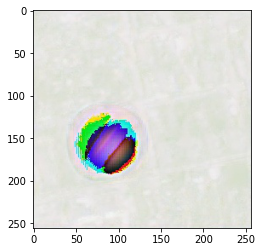

In [ ]:
import matplotlib.pyplot as plt

# img = plt.imread('./train_output/test_sample/map_translation_test/100.jpg')
img = plt.imread('./train_output/test_sample/map_translation_test/1097.jpg')
plt.imshow(img)

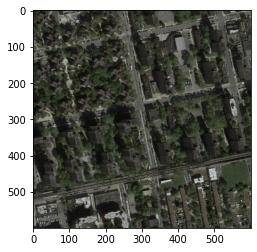

In [ ]:
img = plt.imread('./maps/val/1097.jpg')
plt.imshow(img)

### Generate Result Images from Test Set

In [22]:
opt = TestOptions().parse()
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.phase = 'test'

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./train_output/ckpt/          
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                     file: /root/.local/share/jupyter/runtime/kernel-5e2241b1-896a-4101-bf37-3cf8a8ea07ba.json	[default: useless]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                

In [28]:
opt.epoch = '195'

#trial 32 - resunet - add 2 dropout layers
opt.netG = 'res_unet_G'
opt.lr = 0.0002
opt.n_epochs = 200
opt.batch_size = 1
# opt.load_width = 286
# opt.load_height = 286
opt.ngf = 64
opt.ndf = 64
opt.gan_mode = 'lsgan'

opt.load_width = 256
opt.load_height = 256
opt.load_size = 256
opt.crop_size = 256
# opt.load_width = 512
# opt.load_height = 512
# opt.load_size = 512
# opt.crop_size = 512

In [29]:
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers

dataset [MapDataset] was created
initialize network with normal
map_translation
loading the model from ./train_output/ckpt/map_translation/195_net_G.pth
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 43.897 M
-----------------------------------------------


In [30]:
res = []
opt.num_test = 30000
for i, data in enumerate(dataset):
    start = time.time()
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader

    name = data['A_paths']
    name = name[0].split('/')[-1].split('.')[0]
    model.test(name)           # run inference
    end = time.time()
    res.append(end - start)
    if i % 100 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... ' % (i))
print('Finish the processing')

processing (0000)-th image... 
processing (0100)-th image... 
processing (0200)-th image... 
processing (0300)-th image... 
processing (0400)-th image... 
processing (0500)-th image... 
Finish the processing


## 2. Evaluate the generated results with SSIM

### 2.1 import some necessary tools

In [4]:
import time
import os
import numpy as np
import torch
from torch.autograd import Variable
import cv2
from pytorch_ssim import pytorch_ssim
from PIL import Image
import torchvision.transforms as transforms

### 2.2 prepare some parameters for evaluation

In [ ]:
gt_file ='./maps/val_tgt/'
results_file='./train_output/test_sample/map_translation_test/' 

transform = transforms.Compose([  \
      transforms.ToTensor(),   \
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])


### 2.3 evaluation loop

In [ ]:
loss_all = 0
step = 0
for name in os.listdir(gt_file):
    gt_img = transform(Image.open(os.path.join(gt_file,name))).unsqueeze(0)
    
    fake_img = transform(Image.open(os.path.join(results_file,name))).unsqueeze(0)


    gt_img = Variable(gt_img).cuda()
    fake_img = Variable(fake_img).cuda()

    loss_all = loss_all + pytorch_ssim.ssim(fake_img,gt_img)

    step += 1
    if step % 100 == 0:
        print('The current ssim score of step {} is {}'.format(step, loss_all/step))

print('-'*60)
print('The overall ssim score of step {} is {}'.format(step, loss_all/step))      
print('-'*60)

The current ssim score of step 100 is 0.4770144820213318
The current ssim score of step 200 is 0.47974857687950134
The current ssim score of step 300 is 0.4876457452774048
The current ssim score of step 400 is 0.4888530671596527
The current ssim score of step 500 is 0.48640069365501404
------------------------------------------------------------
The overall ssim score of step 549 is 0.48537975549697876
------------------------------------------------------------


### 2.4 evaluate all saved models

In [9]:
from options.test_options import TestOptions
opt = TestOptions().parse()
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./train_output/ckpt/          
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                     file: /root/.local/share/jupyter/runtime/kernel-5e2241b1-896a-4101-bf37-3cf8a8ea07ba.json	[default: useless]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                

In [10]:
#trial 32 - resunet - add 2 dropout layers
opt.netG = 'res_unet_G'
opt.lr = 0.0002
opt.n_epochs = 200
opt.batch_size = 1
# opt.load_width = 286
# opt.load_height = 286
opt.ngf = 64
opt.ndf = 64
opt.gan_mode = 'lsgan'

opt.load_width = 256
opt.load_height = 256
opt.load_size = 256
opt.crop_size = 256
# opt.load_width = 512
# opt.load_height = 512
# opt.load_size = 512
# opt.crop_size = 512

In [11]:
best_epoch = 0
best_ssim = 0

gt_file ='./maps/val_tgt/'
results_file='./train_output/test_sample/map_translation_test/' 

transform = transforms.Compose([  \
      transforms.ToTensor(),   \
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

transform_256 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([256,256]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_512 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([512,512]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# for epoch in range(10, opt.n_epochs+21, 5):
for epoch in range(195, 196, 10):
  print('processing model ', epoch)
  res = []
  opt.num_test = 30000
  opt.epoch = str(epoch)
  dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
  model = create_model(opt)      # create a model given opt.model and other options
  model.setup(opt)               # regular setup: load and print networks; create schedulers

  # generate image
  for i, data in enumerate(dataset):
      start = time.time()
      if i >= opt.num_test:  # only apply our model to opt.num_test images.
          break
      model.set_input(data)  # unpack data from data loader

      name = data['A_paths']
      name = name[0].split('/')[-1].split('.')[0]
      model.test(name)           # run inference
      end = time.time()
      res.append(end - start)

  # calculate ssim
  loss_all = 0
  step = 0
  for name in os.listdir(gt_file):
      # gt_img = transform_512(Image.open(os.path.join(gt_file,name))).unsqueeze(0)
      gt_img = transform(Image.open(os.path.join(gt_file,name))).unsqueeze(0)
      fake_img = transform(Image.open(os.path.join(results_file,name))).unsqueeze(0)

      gt_img = Variable(gt_img).cuda()
      fake_img = Variable(fake_img).cuda()

      loss_all = loss_all + pytorch_ssim.ssim(fake_img,gt_img)

      step += 1
      if step % 100 == 0:
          print('The current ssim score of step {} is {}'.format(step, loss_all/step))

  print('-'*60)
  print('The overall ssim score of step {} is {}'.format(step, loss_all/step))      
  print('-'*60)
  if loss_all/step > best_ssim:
    best_ssim = loss_all/step
    best_model = epoch

print("best_model: ", best_model)
print("best_ssim: ", best_ssim)

processing model  195
dataset [MapDataset] was created
initialize network with normal
map_translation
loading the model from ./train_output/ckpt/map_translation/195_net_G.pth
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 43.897 M
-----------------------------------------------
The current ssim score of step 100 is 0.6680616140365601
The current ssim score of step 200 is 0.6707431077957153
The current ssim score of step 300 is 0.6755526065826416
The current ssim score of step 400 is 0.6759927272796631
The current ssim score of step 500 is 0.6752306222915649
------------------------------------------------------------
The overall ssim score of step 549 is 0.6745600700378418
------------------------------------------------------------
best_model:  195
best_ssim:  tensor(0.6746, device='cuda:0')


``

-----

# Others
Once you are familar with runing the code. You can also use the following command for training in the remote terminal, which may be more simple and efficient for you.
- `bash train.sh`

and use the following command for inference,
- `bash test.sh`

Then, you can type the following script for SSIM evaluation (remeber to change the path in test.py file),
- `cd pytorch_ssim`
- `python test.py`

-----

# GOOD LUCK
For any questions about the assignment, please contact the TA (Chongjian GE) via email (rhettgee@connect.hku.hk).